## 학습시 인코더인풋과 디코더인풋을 줌

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
import os
import re
from torch.nn.utils.rnn import PackedSequence,pack_padded_sequence

In [2]:
import gensim
from gensim.models.word2vec import Word2Vec
import sys
import multiprocessing
from tqdm import tqdm

C:\Users\asd13\AppData\Local\Continuum\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Slow version of gensim.models.doc2vec is being used


In [3]:
import json
import time
from konlpy.tag import Twitter
twitter=Twitter()

In [4]:
import nltk

In [5]:
model = gensim.models.Word2Vec.load("./Word2vec_pad.model")

word2index=model.wv.index2word

word2index = {}
for i,j in enumerate(model.wv.index2word):
    word2index[j]=i
index2word=model.wv.index2word

model_embedding = []
for index in model.wv.index2word:
    model_embedding.append(model.wv[index])
model_embedding = np.array(model_embedding)

with open('input.txt', 'r') as f:
    input_dict=json.load(f)


song_names=list(input_dict.keys())

for song_name in song_names:
    for i, line in enumerate(input_dict[song_name]):
        for j, s in enumerate(line):
            input_dict[song_name][i][j]=word2index[s]
input_max_cnt = len(input_dict[song_name][i])
targets = []
max_cnt = 0
for target in song_names:
    if len((twitter.morphs(target))+["_EOS_"]) > max_cnt:
        max_cnt = len((twitter.morphs(target))+["_EOS_"])+1
    targets.append((twitter.morphs(target))+["_EOS_"])

for i,target in enumerate(targets):
    for j,s in enumerate(target):
        targets[i][j]=word2index[s]

for i, target in enumerate(targets):
    targets[i] = target+[word2index["_PAD_"]]*(input_max_cnt-len(target))
print ('input_max_cnt: '+ str(input_max_cnt))
print ('target_max_cnt: '+ str(max_cnt))
print ('total_songs: ' + str(len(input_dict)))

input_max_cnt: 30
target_max_cnt: 20
total_songs: 732


In [6]:
inputs = []
validations = []
for key in list(input_dict.keys()):
    if len(input_dict[key]) > 1:
        inputs.append(input_dict[key][:(len(input_dict[key])-1)//2])
        validations.append(input_dict[key][(len(input_dict[key])-1)//2:])

In [7]:
len(inputs),len(validations)#,input_lens

(717, 717)

In [8]:
input_lens = []
validations_lens = []
for key in inputs:
    input_lens.append(len(key))
for key in validations:
    validations_lens.append(len(key))

In [9]:
decode_inputs=[]
for i,input_len in enumerate(input_lens):
    decode_inputs += ([targets[i]]*input_len)

In [10]:
decode_vail=[]
for i,input_len in enumerate(validations_lens):
    decode_vail += ([targets[i]]*input_len)

In [11]:
USE_CUDA = torch.cuda.is_available()

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [12]:
input_var=[]
for key in inputs:
    input_var.append(Variable(LongTensor(key)))
input_var = torch.cat(input_var)

In [13]:
vali_var=[]
for key in validations:
    vali_var.append(Variable(LongTensor(key)))
vali_var = torch.cat(vali_var)

In [14]:
decode_var = Variable(LongTensor(decode_inputs))

In [15]:
decode_var_vail = Variable(LongTensor(decode_vail))

In [16]:
decode_var.size()

torch.Size([13912, 30])

In [17]:
embedding_size = 300
input_size     = len(index2word)

In [18]:
def batch(batch_size,input_var,target_var):
    start = 0
    end = batch_size
    #if len(input_var)%32 != 0:
    while end < len(input_var):
        batch_input = input_var[start:end]
        batch_target = target_var[start:end]
        temp = end
        end  = end + batch_size
        start = temp
        yield batch_input, batch_target
        
    if end >= len(input_var):
        batch_input  = input_var[start:]
        batch_target = target_var[start:]
        yield batch_input, batch_target

In [19]:
class Embedding(nn.Module):
    def __init__(self, input_size, embedding_size, numpy_embedding):
        super(Embedding, self).__init__()
        self.model_embedding = torch.from_numpy(numpy_embedding)
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.embedding.weight = nn.Parameter(self.model_embedding)
        self.embedding.cuda()
    
    def forward(self, x):
        if len(x.size())==1:
            out = self.embedding(x.unsqueeze(0))
        else:
            out = self.embedding(x)
        return out

In [185]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, n_layer, bidirec = False):
        super(Encoder, self).__init__()
        self.input_size     = input_size
        self.embedding_size = embedding_size
        self.hidden_size    = hidden_size
        self.n_layer        = n_layer
        self.bidirec        = bidirec
        
        if self.bidirec:
            self.n_direction = 2 
            self.gru = nn.GRU(embedding_size, hidden_size, n_layer, batch_first=True,bidirectional=True) #(b,s,f)
        else:
            self.n_direction = 1
            self.gru = nn.GRU(embedding_size, hidden_size, n_layer, batch_first=True)
    
    def init_hidden(self,inputs):
        hidden = Variable(torch.zeros(self.n_layer*self.n_direction,inputs.size(0),self.hidden_size))
        return hidden.cuda() if USE_CUDA else hidden
    
    def init_weight(self):
        self.gru.weight_hh_l0 = nn.init.xavier_uniform(self.gru.weight_hh_l0)
        self.gru.weight_ih_l0 = nn.init.xavier_uniform(self.gru.weight_ih_l0)
        
    def forward(self, inputs):
        hidden = self.init_hidden(inputs)
        outputs, hidden = self.gru(inputs, hidden)
       # print(hidden.size())
       # print(hidden[-1].resize(inputs.size(0),1,32) .size())
        
        if self.n_layer>1:
            if self.n_direction==2:
                hidden = hidden[-2:]
            else:
                hidden = hidden[-1]
        
        return outputs, hidden.resize(inputs.size(0),1,64), torch.cat((hidden,),1).unsqueeze(1)

In [186]:
class Decoder(nn.Module):
    def __init__(self, input_size, embedding, embedding_size, hidden_size, n_layers=1, dropout_p=0.1):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers  = n_layers
        self.embedding = embedding
        self.dropout = nn.Dropout(dropout_p)
    
        self.gru = nn.GRU(embedding_size+hidden_size, hidden_size, n_layers,batch_first=True)
        #self.linear = nn.Linear(hidden_size, input_size)
        self.linear = nn.Linear(hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, input_size)
        self.attn = nn.Linear(self.hidden_size,self.hidden_size) # Attention
        
    def init_weight(self):
        self.gru.weight_hh_l0 = nn.init.xavier_uniform(self.gru.weight_hh_l0)
        self.gru.weight_ih_l0 = nn.init.xavier_uniform(self.gru.weight_ih_l0)
        self.linear.weight = nn.init.xavier_uniform(self.linear.weight)
        self.linear2.weight = nn.init.xavier_uniform(self.linear2.weight)
        self.linear3.weight = nn.init.xavier_uniform(self.linear3.weight)
        self.attn.weight = nn.init.xavier_uniform(self.attn.weight)
        
    def init_hidden(self, inputs):
        hidden = Variable(torch.zeros(self.n_layers,inputs.size(0),self.hidden_size))
        return hidden.cuda() if USE_CUDA else hidden
    
    def Attention(self, hidden, encoder_outputs):
        hidden=hidden[0].unsqueeze(2)
        batch_size = encoder_outputs.size(0) # B
        max_len = encoder_outputs.size(1) # T
        energies= self.attn(encoder_outputs.contiguous().view(1,batch_size*max_len,-1))
        energies = energies.view(batch_size,max_len,-1) 
        attn_energies  = energies.bmm(hidden).squeeze(2)
        alpha = F.softmax(attn_energies)
        alpha = alpha.unsqueeze(1)
        context = alpha.bmm(output)
        return context, alpha
    
    def forward(self,inputs,context,max_length,encoder_outputs,is_training=False):
        """
        inputs : B,1 (LongTensor, START SYMBOL)
        context : B,1,D (FloatTensor, Last encoder hidden state)
        max_length : int, max length to decode # for batch
        encoder_outputs : B,T,D
        encoder_maskings : B,T # ByteTensor
        is_training : bool, this is because adapt dropout only training step.
        """
        # Get the embedding of the current input word
        embedded = self.embedding(inputs)
        hidden = self.init_hidden(inputs)
        if is_training:
            embedded = self.dropout(embedded)
        #print (str(embedded.size())+ "_output")
        #print (str(hidden.size())+ "_hidden")
        #print (str(context.size())+ "_context")
        decode=[]
        # Apply GRU to the output so far
        for i in range(max_length):
            #print (str(i)+'embedded: '+ str(embedded.size()))
            #print (str(i)+'context: '+ str(context.size()))
            #print (str(i)+'hidden: '+ str(hidden.size()))
            #print (str(i)+'torch.cat((embedded,context),2): '+ str(torch.cat((embedded,context),2).size()))
            #print(torch.cat((embedded,context),2))
            _, hidden = self.gru(torch.cat((embedded,context),2), hidden) # h_t = f(h_{t-1},y_{t-1},c)
            #print (str(i)+'hidden[-1].squeeze: '+ str(hidden[-1].squeeze(0).size()))
            #score = self.linear(hidden[-1].squeeze(0))
            linear1 = self.linear(hidden[-1].squeeze(0))
            linear2 = self.linear2(linear1)
            score   = self.linear3(linear2)
            #print (str(i)+'score: '+ str(score.size()))
            softmaxed = F.log_softmax(score) #{b,d}
            #print (str(i)+'softmaxed: '+ str(softmaxed.size()))
            decode.append(softmaxed)
            decoded = softmaxed.max(1)[1]
            #print (str(i)+':'+ str(softmaxed.size())+ "_softmaxed")
            #print (str(i)+':'+ str(decoded.size())+ "_decoded")
            embedded = self.embedding(decoded).transpose(0,1) # y_{t-1}
            #print (str(i)+':'+ str(embedded.size())+ "_output")
            if is_training:
                embedded = self.dropout(embedded)
            #print (str(i)+'hidden_A: '+ str(hidden[-1].unsqueeze(0).size()))
            # compute next context vector using attention
            context, alpha = self.Attention(hidden[-1].unsqueeze(0), encoder_outputs)
        
        #  column-wise concat, reshape!!
        scores = torch.cat(decode,1)
        #print (str(i)+'scores: '+ str(scores.view(inputs.size(0),).size()))  
        #print(max_length)
        return scores.view(inputs.size(0)*max_length,-1)
    
    def decode(self,context,encoder_outputs):
        start_decode = Variable(LongTensor([word2index['_STA_']]))
        embedded = self.embedding(start_decode)
        hidden = self.init_hidden(start_decode)
        #print (str(embedded.size())+ "_output")
        #print (str(hidden.size())+ "_hidden")
        #print (str(context.size())+ "_context")
        decodes=[]
        attentions=[]
        decoded = embedded
        length_ = 0
        #while len(decodes)<30: # until </s>
            #print(decoded.data.tolist()[0]!=word2index['_EOS_'])
        while decoded.data.tolist()[0]!=word2index['_EOS_']:
            length_ += 1 

            #print(decoded.data.tolist()[0])
            #print (str(i)+'embedded:'+ str(embedded.size()))
            #print (str(i)+'context:'+ str(context.size()))
            #print (str(i)+'hidden:'+ str(hidden.size()))
            
            _, hidden = self.gru(torch.cat((embedded,context),2), hidden) # h_t = f(h_{t-1},y_{t-1},c)
            #score = self.linear(hidden[-1].squeeze(0))
            linear1 = self.linear(hidden[-1].squeeze(0))
            linear2 = self.linear2(linear1)
            score   = self.linear3(linear2)
            softmaxed = F.log_softmax(score)
            #print (str(i)+'softmaxed:'+ str(softmaxed.size()))
            decodes.append(softmaxed)
            decoded = softmaxed.unsqueeze(0).max(1)[1]
            #print(decoded)
            embedded = self.embedding(decoded) # y_{t-1}
            context, alpha = self.Attention(hidden, encoder_outputs)
            attentions.append(alpha.squeeze(1))
            if length_ == 33:
                return torch.cat(decodes).view(length_,-1).max(1)[1], torch.cat(attentions)
        #print (str(i)+'decodes:'+ str(torch.cat(decodes).view(30,-1).size()))    
        return torch.cat(decodes).view(length_,-1).max(1)[1], torch.cat(attentions)

In [187]:
emb = Embedding(input_size=len(index2word),embedding_size= 300, numpy_embedding = model_embedding)
encoder = Encoder(input_size=len(index2word),embedding_size=300,hidden_size=32, n_layer=1, bidirec=True )
decoder = Decoder(input_size=len(index2word),embedding_size=300,embedding = emb,hidden_size=32*2, n_layers=1,dropout_p=0.5)
encoder.init_weight()
decoder.init_weight()

emb = emb.cuda()
encoder = encoder.cuda()
decoder = decoder.cuda()

In [188]:
LR = 0.001
DECODER_LEARNING_RATIO=5.0
RESCHEDULED=False
batch_size = 256

In [189]:
loss_function = nn.CrossEntropyLoss()
#emb_optimizer = optim.Adam(emb.parameters(),lr=LR)
enc_optimizer = optim.Adam(encoder.parameters(),lr=LR)
dec_optimizer = optim.Adam(decoder.parameters(),lr=LR*DECODER_LEARNING_RATIO)

In [190]:
encoder.load_state_dict(torch.load('encoder_bi_layer:2_hidden:32.pkl'))

decoder.load_state_dict(torch.load('decoder_bi_layer:1_hidden:32*2_linear:3.pkl'))

OSError: [Errno 22] Invalid argument: 'encoder_bi_layer:2_hidden:32.pkl'

In [191]:
encoder,decoder

(Encoder(
   (gru): GRU(300, 32, batch_first=True, bidirectional=True)
 ), Decoder(
   (embedding): Embedding(
     (embedding): Embedding(8375, 300)
   )
   (dropout): Dropout(p=0.5)
   (gru): GRU(364, 64, batch_first=True)
   (linear): Linear(in_features=64, out_features=64, bias=True)
   (linear2): Linear(in_features=64, out_features=64, bias=True)
   (linear3): Linear(in_features=64, out_features=8375, bias=True)
   (attn): Linear(in_features=64, out_features=64, bias=True)
 ))

def make_varidationset(input_var,target_var)
    var_input    = []
    var_target   = []
    if len(input_var) == len(target_var)
        for i in range(len(input_var)):
            if i%20==0:
                var_input.append(input_var[i])
                var_target.append(target_var[i])

In [195]:
EPOCH = 600

In [196]:
%%time
i=0
temp_list = []
loss_list = []
for epoch in tqdm(range(EPOCH)):
    losses=[]
    for batch_input, batch_target in batch(batch_size,input_var,decode_var):
        i +=1
        encoder.zero_grad()
        decoder.zero_grad()
        start_decode = Variable(LongTensor([[word2index["_STA_"]]*batch_input.size(0)])).transpose(0,1)
        
        input_embedding = emb(batch_target).cuda()
        output,hidden_c,_ = encoder(input_embedding)
        
        preds = decoder(start_decode,hidden_c,batch_input.size(1),output,True)
       
        loss = loss_function(preds,batch_input.view(-1))
        losses.append(loss.data.tolist()[0] )
        loss.backward()
        torch.nn.utils.clip_grad_norm(encoder.parameters(), 10.0) # gradient clipping
        torch.nn.utils.clip_grad_norm(decoder.parameters(), 10.0) # gradient clipping
        enc_optimizer.step()
        dec_optimizer.step()
        temp_list.append(np.mean(losses))
        if i% 50 ==0:
            print("Epoch : [%02d/%d] mean_loss : %0.9f" %(epoch+1, EPOCH,  np.mean(losses)))
            losses=[]
    loss_list.append(np.mean(temp_list))
    np.savez('loss.npz',loss=loss_list)
    
    # You can use http://pytorch.org/docs/master/optim.html#how-to-adjust-learning-rate
    if RESCHEDULED==False and epoch  == EPOCH//2:
        LR = LR*0.01
        enc_optimizer = optim.Adam(encoder.parameters(),lr=LR)
        dec_optimizer = optim.Adam(decoder.parameters(),lr=LR*DECODER_LEARNING_RATIO)
        RESCHEDULED=True
    torch.save(emb.state_dict(), 'emb.pkl')
    torch.save(encoder.state_dict(), './model/encoder_bi_layer.pkl')
    torch.save(decoder.state_dict(), './model/decoder_bi_layer.pkl')


  0%|                                                                                          | 0/600 [00:00<?, ?it/s]C:\Users\asd13\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\asd13\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

Exception in thread Thread-30:
Traceback (most recent call last):
  File "C:\Users\asd13\AppData\Local\Continuum\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\asd13\AppData\Local\Continuum\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\asd13\AppData\Local\Continuum\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for

Epoch : [01/600] mean_loss : 1.393003523


  0%|▏                                                                               | 1/600 [00:09<1:32:11,  9.23s/it]

Epoch : [02/600] mean_loss : 1.430777219


  0%|▎                                                                               | 2/600 [00:18<1:30:48,  9.11s/it]

Epoch : [03/600] mean_loss : 1.435727504


  0%|▍                                                                               | 3/600 [00:27<1:30:27,  9.09s/it]

Epoch : [04/600] mean_loss : 1.377263771


  1%|▌                                                                               | 4/600 [00:36<1:30:04,  9.07s/it]

Epoch : [05/600] mean_loss : 1.391651893


  1%|▋                                                                               | 5/600 [00:45<1:29:58,  9.07s/it]

Epoch : [06/600] mean_loss : 1.367632842


  1%|▊                                                                               | 6/600 [00:54<1:29:47,  9.07s/it]

Epoch : [07/600] mean_loss : 1.365474910


  1%|▉                                                                               | 7/600 [01:03<1:29:38,  9.07s/it]

Epoch : [08/600] mean_loss : 1.353122822


  1%|█                                                                               | 8/600 [01:12<1:29:25,  9.06s/it]

Epoch : [09/600] mean_loss : 1.360066628


  2%|█▏                                                                              | 9/600 [01:21<1:29:14,  9.06s/it]

Epoch : [10/600] mean_loss : 1.387178779
Epoch : [10/600] mean_loss : 1.334591208


  2%|█▎                                                                             | 10/600 [01:30<1:29:04,  9.06s/it]

Epoch : [11/600] mean_loss : 1.367808104


  2%|█▍                                                                             | 11/600 [01:39<1:28:54,  9.06s/it]

Epoch : [12/600] mean_loss : 1.379034797


  2%|█▌                                                                             | 12/600 [01:48<1:28:42,  9.05s/it]

Epoch : [13/600] mean_loss : 1.360420316


  2%|█▋                                                                             | 13/600 [01:57<1:28:28,  9.04s/it]

Epoch : [14/600] mean_loss : 1.340956116


  2%|█▊                                                                             | 14/600 [02:06<1:28:19,  9.04s/it]

Epoch : [15/600] mean_loss : 1.346431148


  2%|█▉                                                                             | 15/600 [02:15<1:28:23,  9.07s/it]

Epoch : [16/600] mean_loss : 1.358795233


  3%|██                                                                             | 16/600 [02:25<1:28:13,  9.06s/it]

Epoch : [17/600] mean_loss : 1.340624046


  3%|██▏                                                                            | 17/600 [02:34<1:28:03,  9.06s/it]

Epoch : [18/600] mean_loss : 1.341977501


  3%|██▎                                                                            | 18/600 [02:43<1:27:54,  9.06s/it]

Epoch : [19/600] mean_loss : 1.322995520


  3%|██▌                                                                            | 19/600 [02:52<1:27:47,  9.07s/it]

Epoch : [20/600] mean_loss : 1.346854925
Epoch : [20/600] mean_loss : 1.309939587


  3%|██▋                                                                            | 20/600 [03:01<1:27:38,  9.07s/it]

Epoch : [21/600] mean_loss : 1.319626651


  4%|██▊                                                                            | 21/600 [03:10<1:27:28,  9.07s/it]

Epoch : [22/600] mean_loss : 1.319519136


  4%|██▉                                                                            | 22/600 [03:19<1:27:19,  9.06s/it]

Epoch : [23/600] mean_loss : 1.325490448


  4%|███                                                                            | 23/600 [03:28<1:27:12,  9.07s/it]

Epoch : [24/600] mean_loss : 1.321452812


  4%|███▏                                                                           | 24/600 [03:37<1:27:05,  9.07s/it]

Epoch : [25/600] mean_loss : 1.322094921


  4%|███▎                                                                           | 25/600 [03:46<1:26:56,  9.07s/it]

Epoch : [26/600] mean_loss : 1.313047171


  4%|███▍                                                                           | 26/600 [03:55<1:26:47,  9.07s/it]

Epoch : [27/600] mean_loss : 1.300973272


  4%|███▌                                                                           | 27/600 [04:04<1:26:38,  9.07s/it]

Epoch : [28/600] mean_loss : 1.289262335


  5%|███▋                                                                           | 28/600 [04:14<1:26:31,  9.08s/it]

Epoch : [29/600] mean_loss : 1.284528720


  5%|███▊                                                                           | 29/600 [04:23<1:26:22,  9.08s/it]

Epoch : [30/600] mean_loss : 1.318681359
Epoch : [30/600] mean_loss : 1.275678518


  5%|███▉                                                                           | 30/600 [04:32<1:26:15,  9.08s/it]

Epoch : [31/600] mean_loss : 1.285353150


  5%|████                                                                           | 31/600 [04:41<1:26:05,  9.08s/it]

Epoch : [32/600] mean_loss : 1.290419104


  5%|████▏                                                                          | 32/600 [04:50<1:25:56,  9.08s/it]

Epoch : [33/600] mean_loss : 1.292689300


  6%|████▎                                                                          | 33/600 [04:59<1:25:47,  9.08s/it]

Epoch : [34/600] mean_loss : 1.281326304


  6%|████▍                                                                          | 34/600 [05:08<1:25:37,  9.08s/it]

Epoch : [35/600] mean_loss : 1.279267689


  6%|████▌                                                                          | 35/600 [05:17<1:25:28,  9.08s/it]

Epoch : [36/600] mean_loss : 1.296697707


  6%|████▋                                                                          | 36/600 [05:26<1:25:18,  9.08s/it]

Epoch : [37/600] mean_loss : 1.301269776


  6%|████▊                                                                          | 37/600 [05:35<1:25:09,  9.08s/it]

Epoch : [38/600] mean_loss : 1.296364220


  6%|█████                                                                          | 38/600 [05:44<1:25:00,  9.08s/it]

Epoch : [39/600] mean_loss : 1.274344790


  6%|█████▏                                                                         | 39/600 [05:54<1:24:52,  9.08s/it]

Epoch : [40/600] mean_loss : 1.276443124
Epoch : [40/600] mean_loss : 1.292265289


  7%|█████▎                                                                         | 40/600 [06:03<1:24:44,  9.08s/it]

Epoch : [41/600] mean_loss : 1.266251240


  7%|█████▍                                                                         | 41/600 [06:12<1:24:35,  9.08s/it]

Epoch : [42/600] mean_loss : 1.256453461


  7%|█████▌                                                                         | 42/600 [06:21<1:24:27,  9.08s/it]

Epoch : [43/600] mean_loss : 1.249052718


  7%|█████▋                                                                         | 43/600 [06:30<1:24:18,  9.08s/it]

Epoch : [44/600] mean_loss : 1.241750635


  7%|█████▊                                                                         | 44/600 [06:39<1:24:09,  9.08s/it]

Epoch : [45/600] mean_loss : 1.244479191


  8%|█████▉                                                                         | 45/600 [06:48<1:23:59,  9.08s/it]

Epoch : [46/600] mean_loss : 1.238771467


  8%|██████                                                                         | 46/600 [06:57<1:23:51,  9.08s/it]

Epoch : [47/600] mean_loss : 1.224572533


  8%|██████▏                                                                        | 47/600 [07:06<1:23:42,  9.08s/it]

Epoch : [48/600] mean_loss : 1.207307696


  8%|██████▎                                                                        | 48/600 [07:16<1:23:34,  9.08s/it]

Epoch : [49/600] mean_loss : 1.201444006


  8%|██████▍                                                                        | 49/600 [07:25<1:23:27,  9.09s/it]

Epoch : [50/600] mean_loss : 1.238494921
Epoch : [50/600] mean_loss : 1.197875863


  8%|██████▌                                                                        | 50/600 [07:34<1:23:21,  9.09s/it]

Epoch : [51/600] mean_loss : 1.208464735


  8%|██████▋                                                                        | 51/600 [07:44<1:23:18,  9.10s/it]

Epoch : [52/600] mean_loss : 1.210904654


  9%|██████▊                                                                        | 52/600 [07:53<1:23:09,  9.10s/it]

Epoch : [53/600] mean_loss : 1.205270511


  9%|██████▉                                                                        | 53/600 [08:03<1:23:06,  9.12s/it]

Epoch : [54/600] mean_loss : 1.190347205


  9%|███████                                                                        | 54/600 [08:12<1:23:00,  9.12s/it]

Epoch : [55/600] mean_loss : 1.189092962


  9%|███████▏                                                                       | 55/600 [08:21<1:22:50,  9.12s/it]

Epoch : [56/600] mean_loss : 1.188690491


  9%|███████▎                                                                       | 56/600 [08:30<1:22:41,  9.12s/it]

Epoch : [57/600] mean_loss : 1.192243701


 10%|███████▌                                                                       | 57/600 [08:40<1:22:35,  9.13s/it]

Epoch : [58/600] mean_loss : 1.185675486


 10%|███████▋                                                                       | 58/600 [08:49<1:22:29,  9.13s/it]

Epoch : [59/600] mean_loss : 1.168545568


 10%|███████▊                                                                       | 59/600 [08:59<1:22:22,  9.14s/it]

Epoch : [60/600] mean_loss : 1.187545991
Epoch : [60/600] mean_loss : 1.184985147


 10%|███████▉                                                                       | 60/600 [09:08<1:22:15,  9.14s/it]

Epoch : [61/600] mean_loss : 1.190864024


 10%|████████                                                                       | 61/600 [09:17<1:22:05,  9.14s/it]

Epoch : [62/600] mean_loss : 1.186000729


 10%|████████▏                                                                      | 62/600 [09:26<1:21:55,  9.14s/it]

Epoch : [63/600] mean_loss : 1.178989694


 10%|████████▎                                                                      | 63/600 [09:35<1:21:46,  9.14s/it]

Epoch : [64/600] mean_loss : 1.171732518


 11%|████████▍                                                                      | 64/600 [09:44<1:21:36,  9.14s/it]

Epoch : [65/600] mean_loss : 1.168078407


 11%|████████▌                                                                      | 65/600 [09:53<1:21:27,  9.13s/it]

Epoch : [66/600] mean_loss : 1.154140885


 11%|████████▋                                                                      | 66/600 [10:03<1:21:20,  9.14s/it]

Epoch : [67/600] mean_loss : 1.140073460


 11%|████████▊                                                                      | 67/600 [10:13<1:21:17,  9.15s/it]

Epoch : [68/600] mean_loss : 1.144792565


 11%|████████▉                                                                      | 68/600 [10:23<1:21:15,  9.16s/it]

Epoch : [69/600] mean_loss : 1.134630519


 12%|█████████                                                                      | 69/600 [10:32<1:21:09,  9.17s/it]

Epoch : [70/600] mean_loss : 1.178006148
Epoch : [70/600] mean_loss : 1.143078163


 12%|█████████▏                                                                     | 70/600 [10:42<1:21:01,  9.17s/it]

Epoch : [71/600] mean_loss : 1.154365052


 12%|█████████▎                                                                     | 71/600 [10:51<1:20:55,  9.18s/it]

Epoch : [72/600] mean_loss : 1.152011731


 12%|█████████▍                                                                     | 72/600 [11:01<1:20:49,  9.18s/it]

Epoch : [73/600] mean_loss : 1.149843767


 12%|█████████▌                                                                     | 73/600 [11:11<1:20:44,  9.19s/it]

Epoch : [74/600] mean_loss : 1.143234319


 12%|█████████▋                                                                     | 74/600 [11:20<1:20:40,  9.20s/it]

Epoch : [75/600] mean_loss : 1.137431924


 12%|█████████▉                                                                     | 75/600 [11:30<1:20:36,  9.21s/it]

Epoch : [76/600] mean_loss : 1.126332810


 13%|██████████                                                                     | 76/600 [11:40<1:20:29,  9.22s/it]

Epoch : [77/600] mean_loss : 1.123764154


 13%|██████████▏                                                                    | 77/600 [11:50<1:20:23,  9.22s/it]

Epoch : [78/600] mean_loss : 1.132715166


 13%|██████████▎                                                                    | 78/600 [11:59<1:20:15,  9.22s/it]

Epoch : [79/600] mean_loss : 1.102587616


 13%|██████████▍                                                                    | 79/600 [12:09<1:20:08,  9.23s/it]

Epoch : [80/600] mean_loss : 1.119299865
Epoch : [80/600] mean_loss : 1.105439550


 13%|██████████▌                                                                    | 80/600 [12:18<1:20:02,  9.24s/it]

Epoch : [81/600] mean_loss : 1.112995167


 14%|██████████▋                                                                    | 81/600 [12:28<1:19:54,  9.24s/it]

Epoch : [82/600] mean_loss : 1.118081025


 14%|██████████▊                                                                    | 82/600 [12:37<1:19:47,  9.24s/it]

Epoch : [83/600] mean_loss : 1.112001978


 14%|██████████▉                                                                    | 83/600 [12:47<1:19:38,  9.24s/it]

Epoch : [84/600] mean_loss : 1.104191329


 14%|███████████                                                                    | 84/600 [12:56<1:19:30,  9.25s/it]

Epoch : [85/600] mean_loss : 1.104624079


 14%|███████████▏                                                                   | 85/600 [13:06<1:19:22,  9.25s/it]

Epoch : [86/600] mean_loss : 1.097785237


 14%|███████████▎                                                                   | 86/600 [13:15<1:19:15,  9.25s/it]

Epoch : [87/600] mean_loss : 1.084707117


 14%|███████████▍                                                                   | 87/600 [13:25<1:19:06,  9.25s/it]

Epoch : [88/600] mean_loss : 1.077038332


 15%|███████████▌                                                                   | 88/600 [13:34<1:18:58,  9.26s/it]

Epoch : [89/600] mean_loss : 1.063162965


 15%|███████████▋                                                                   | 89/600 [13:43<1:18:50,  9.26s/it]

Epoch : [90/600] mean_loss : 1.084452176
Epoch : [90/600] mean_loss : 1.059936932


 15%|███████████▊                                                                   | 90/600 [13:53<1:18:41,  9.26s/it]

Epoch : [91/600] mean_loss : 1.068047986


 15%|███████████▉                                                                   | 91/600 [14:02<1:18:32,  9.26s/it]

Epoch : [92/600] mean_loss : 1.069037002


 15%|████████████                                                                   | 92/600 [14:11<1:18:22,  9.26s/it]

Epoch : [93/600] mean_loss : 1.068148026


 16%|████████████▏                                                                  | 93/600 [14:20<1:18:13,  9.26s/it]

Epoch : [94/600] mean_loss : 1.064999339


 16%|████████████▍                                                                  | 94/600 [14:30<1:18:04,  9.26s/it]

Epoch : [95/600] mean_loss : 1.064647269


 16%|████████████▌                                                                  | 95/600 [14:39<1:17:56,  9.26s/it]

Epoch : [96/600] mean_loss : 1.060086501


 16%|████████████▋                                                                  | 96/600 [14:49<1:17:49,  9.26s/it]

Epoch : [97/600] mean_loss : 1.046061507


 16%|████████████▊                                                                  | 97/600 [14:59<1:17:43,  9.27s/it]

Epoch : [98/600] mean_loss : 1.046541341


 16%|████████████▉                                                                  | 98/600 [15:11<1:17:48,  9.30s/it]

Epoch : [99/600] mean_loss : 1.032153428


 16%|█████████████                                                                  | 99/600 [15:22<1:17:48,  9.32s/it]

Epoch : [100/600] mean_loss : 1.053261590
Epoch : [100/600] mean_loss : 1.040811468


 17%|█████████████                                                                 | 100/600 [15:33<1:17:48,  9.34s/it]

Epoch : [101/600] mean_loss : 1.050876664


 17%|█████████████▏                                                                | 101/600 [15:45<1:17:49,  9.36s/it]

Epoch : [102/600] mean_loss : 1.047346968


 17%|█████████████▎                                                                | 102/600 [15:56<1:17:49,  9.38s/it]

Epoch : [103/600] mean_loss : 1.045719765


 17%|█████████████▍                                                                | 103/600 [16:07<1:17:49,  9.40s/it]

Epoch : [104/600] mean_loss : 1.042236735


 17%|█████████████▌                                                                | 104/600 [16:19<1:17:50,  9.42s/it]

Epoch : [105/600] mean_loss : 1.042721174


 18%|█████████████▋                                                                | 105/600 [16:30<1:17:49,  9.43s/it]

Epoch : [106/600] mean_loss : 1.042272158


 18%|█████████████▊                                                                | 106/600 [16:42<1:17:49,  9.45s/it]

Epoch : [107/600] mean_loss : 1.041630945


 18%|█████████████▉                                                                | 107/600 [16:53<1:17:48,  9.47s/it]

Epoch : [108/600] mean_loss : 1.030070432


 18%|██████████████                                                                | 108/600 [17:04<1:17:47,  9.49s/it]

Epoch : [109/600] mean_loss : 1.008502364


 18%|██████████████▏                                                               | 109/600 [17:15<1:17:46,  9.50s/it]

Epoch : [110/600] mean_loss : 1.022330689
Epoch : [110/600] mean_loss : 1.011708370


 18%|██████████████▎                                                               | 110/600 [17:27<1:17:44,  9.52s/it]

Epoch : [111/600] mean_loss : 1.021182641


 18%|██████████████▍                                                               | 111/600 [17:38<1:17:42,  9.53s/it]

Epoch : [112/600] mean_loss : 1.020190075


 19%|██████████████▌                                                               | 112/600 [17:49<1:17:40,  9.55s/it]

Epoch : [113/600] mean_loss : 1.021138942


 19%|██████████████▋                                                               | 113/600 [18:00<1:17:38,  9.57s/it]

Epoch : [114/600] mean_loss : 1.020837450


 19%|██████████████▊                                                               | 114/600 [18:12<1:17:36,  9.58s/it]

Epoch : [115/600] mean_loss : 1.025964806


 19%|██████████████▉                                                               | 115/600 [18:23<1:17:33,  9.60s/it]

Epoch : [116/600] mean_loss : 1.023224175


 19%|███████████████                                                               | 116/600 [18:34<1:17:31,  9.61s/it]

Epoch : [117/600] mean_loss : 1.018037489


 20%|███████████████▏                                                              | 117/600 [18:46<1:17:29,  9.63s/it]

Epoch : [118/600] mean_loss : 1.017065899


 20%|███████████████▎                                                              | 118/600 [18:57<1:17:26,  9.64s/it]

Epoch : [119/600] mean_loss : 0.989852720


 20%|███████████████▍                                                              | 119/600 [19:08<1:17:22,  9.65s/it]

Epoch : [120/600] mean_loss : 1.004345977
Epoch : [120/600] mean_loss : 0.991122882


 20%|███████████████▌                                                              | 120/600 [19:19<1:17:18,  9.66s/it]

Epoch : [121/600] mean_loss : 1.003292208


 20%|███████████████▋                                                              | 121/600 [19:30<1:17:14,  9.68s/it]

Epoch : [122/600] mean_loss : 1.005361429


 20%|███████████████▊                                                              | 122/600 [19:42<1:17:12,  9.69s/it]

Epoch : [123/600] mean_loss : 1.008286320


 20%|███████████████▉                                                              | 123/600 [19:53<1:17:09,  9.71s/it]

Epoch : [124/600] mean_loss : 1.006279717


 21%|████████████████                                                              | 124/600 [20:05<1:17:06,  9.72s/it]

Epoch : [125/600] mean_loss : 1.004811492


 21%|████████████████▎                                                             | 125/600 [20:16<1:17:02,  9.73s/it]

Epoch : [126/600] mean_loss : 1.003603930


 21%|████████████████▍                                                             | 126/600 [20:27<1:16:59,  9.75s/it]

Epoch : [127/600] mean_loss : 1.001485303


 21%|████████████████▌                                                             | 127/600 [20:39<1:16:55,  9.76s/it]

Epoch : [128/600] mean_loss : 0.999495618


 21%|████████████████▋                                                             | 128/600 [20:50<1:16:51,  9.77s/it]

Epoch : [129/600] mean_loss : 0.983802396


 22%|████████████████▊                                                             | 129/600 [21:01<1:16:47,  9.78s/it]

Epoch : [130/600] mean_loss : 1.002383316
Epoch : [130/600] mean_loss : 0.988488605


 22%|████████████████▉                                                             | 130/600 [21:13<1:16:42,  9.79s/it]

Epoch : [131/600] mean_loss : 0.999234595


 22%|█████████████████                                                             | 131/600 [21:24<1:16:37,  9.80s/it]

Epoch : [132/600] mean_loss : 1.001795443


 22%|█████████████████▏                                                            | 132/600 [21:35<1:16:33,  9.81s/it]

Epoch : [133/600] mean_loss : 1.000255102


 22%|█████████████████▎                                                            | 133/600 [21:46<1:16:27,  9.82s/it]

Epoch : [134/600] mean_loss : 0.989525877


 22%|█████████████████▍                                                            | 134/600 [21:57<1:16:22,  9.83s/it]

Epoch : [135/600] mean_loss : 0.986725831


 22%|█████████████████▌                                                            | 135/600 [22:08<1:16:17,  9.84s/it]

Epoch : [136/600] mean_loss : 0.985034478


 23%|█████████████████▋                                                            | 136/600 [22:20<1:16:13,  9.86s/it]

Epoch : [137/600] mean_loss : 0.984658149


 23%|█████████████████▊                                                            | 137/600 [22:31<1:16:07,  9.87s/it]

Epoch : [138/600] mean_loss : 0.982483733


 23%|█████████████████▉                                                            | 138/600 [22:42<1:16:02,  9.88s/it]

Epoch : [139/600] mean_loss : 0.964876664


 23%|██████████████████                                                            | 139/600 [22:53<1:15:56,  9.88s/it]

Epoch : [140/600] mean_loss : 0.983900011
Epoch : [140/600] mean_loss : 0.967652898


 23%|██████████████████▏                                                           | 140/600 [23:05<1:15:51,  9.89s/it]

Epoch : [141/600] mean_loss : 0.980111917


 24%|██████████████████▎                                                           | 141/600 [23:16<1:15:46,  9.90s/it]

Epoch : [142/600] mean_loss : 0.976479370


 24%|██████████████████▍                                                           | 142/600 [23:27<1:15:40,  9.91s/it]

Epoch : [143/600] mean_loss : 0.972573546


 24%|██████████████████▌                                                           | 143/600 [23:39<1:15:35,  9.92s/it]

Epoch : [144/600] mean_loss : 0.970359675


 24%|██████████████████▋                                                           | 144/600 [23:50<1:15:30,  9.93s/it]

Epoch : [145/600] mean_loss : 0.970989150


 24%|██████████████████▊                                                           | 145/600 [24:01<1:15:24,  9.94s/it]

Epoch : [146/600] mean_loss : 0.970690126


 24%|██████████████████▉                                                           | 146/600 [24:13<1:15:19,  9.96s/it]

Epoch : [147/600] mean_loss : 0.968251488


 24%|███████████████████                                                           | 147/600 [24:24<1:15:13,  9.96s/it]

Epoch : [148/600] mean_loss : 0.966933469


 25%|███████████████████▏                                                          | 148/600 [24:35<1:15:07,  9.97s/it]

Epoch : [149/600] mean_loss : 0.947559530


 25%|███████████████████▎                                                          | 149/600 [24:47<1:15:01,  9.98s/it]

Epoch : [150/600] mean_loss : 0.960032284
Epoch : [150/600] mean_loss : 0.953960614


 25%|███████████████████▌                                                          | 150/600 [24:58<1:14:55,  9.99s/it]

Epoch : [151/600] mean_loss : 0.964941945


 25%|███████████████████▋                                                          | 151/600 [25:09<1:14:49, 10.00s/it]

Epoch : [152/600] mean_loss : 0.966312518


 25%|███████████████████▊                                                          | 152/600 [25:21<1:14:43, 10.01s/it]

Epoch : [153/600] mean_loss : 0.973180039


 26%|███████████████████▉                                                          | 153/600 [25:32<1:14:36, 10.02s/it]

Epoch : [154/600] mean_loss : 0.973512098


 26%|████████████████████                                                          | 154/600 [25:43<1:14:30, 10.02s/it]

Epoch : [155/600] mean_loss : 0.972634067


 26%|████████████████████▏                                                         | 155/600 [25:54<1:14:23, 10.03s/it]

Epoch : [156/600] mean_loss : 0.971499877


 26%|████████████████████▎                                                         | 156/600 [26:06<1:14:17, 10.04s/it]

Epoch : [157/600] mean_loss : 0.964876372


 26%|████████████████████▍                                                         | 157/600 [26:17<1:14:10, 10.05s/it]

Epoch : [158/600] mean_loss : 0.957650189


 26%|████████████████████▌                                                         | 158/600 [26:28<1:14:04, 10.05s/it]

Epoch : [159/600] mean_loss : 0.943976325


 26%|████████████████████▋                                                         | 159/600 [26:39<1:13:56, 10.06s/it]

Epoch : [160/600] mean_loss : 0.947096145
Epoch : [160/600] mean_loss : 0.943046982


 27%|████████████████████▊                                                         | 160/600 [26:51<1:13:50, 10.07s/it]

Epoch : [161/600] mean_loss : 0.952942178


 27%|████████████████████▉                                                         | 161/600 [27:02<1:13:43, 10.08s/it]

Epoch : [162/600] mean_loss : 0.953958488


 27%|█████████████████████                                                         | 162/600 [27:13<1:13:36, 10.08s/it]

Epoch : [163/600] mean_loss : 0.957055174


 27%|█████████████████████▏                                                        | 163/600 [27:24<1:13:29, 10.09s/it]

Epoch : [164/600] mean_loss : 0.953464447


 27%|█████████████████████▎                                                        | 164/600 [27:36<1:13:22, 10.10s/it]

Epoch : [165/600] mean_loss : 0.955045760


 28%|█████████████████████▍                                                        | 165/600 [27:47<1:13:16, 10.11s/it]

Epoch : [166/600] mean_loss : 0.957331979


 28%|█████████████████████▌                                                        | 166/600 [27:58<1:13:09, 10.11s/it]

Epoch : [167/600] mean_loss : 0.951993892


 28%|█████████████████████▋                                                        | 167/600 [28:10<1:13:02, 10.12s/it]

Epoch : [168/600] mean_loss : 0.946922700


 28%|█████████████████████▊                                                        | 168/600 [28:21<1:12:54, 10.13s/it]

Epoch : [169/600] mean_loss : 0.922309816


 28%|█████████████████████▉                                                        | 169/600 [28:32<1:12:46, 10.13s/it]

Epoch : [170/600] mean_loss : 0.947119498
Epoch : [170/600] mean_loss : 0.938922216


 28%|██████████████████████                                                        | 170/600 [28:43<1:12:39, 10.14s/it]

Epoch : [171/600] mean_loss : 0.953887247


 28%|██████████████████████▏                                                       | 171/600 [28:54<1:12:31, 10.14s/it]

Epoch : [172/600] mean_loss : 0.952062527


 29%|██████████████████████▎                                                       | 172/600 [29:05<1:12:24, 10.15s/it]

Epoch : [173/600] mean_loss : 0.953161094


 29%|██████████████████████▍                                                       | 173/600 [29:17<1:12:16, 10.16s/it]

Epoch : [174/600] mean_loss : 0.948944390


 29%|██████████████████████▌                                                       | 174/600 [29:28<1:12:09, 10.16s/it]

Epoch : [175/600] mean_loss : 0.950063578


 29%|██████████████████████▊                                                       | 175/600 [29:39<1:12:01, 10.17s/it]

Epoch : [176/600] mean_loss : 0.947827463


 29%|██████████████████████▉                                                       | 176/600 [29:50<1:11:53, 10.17s/it]

Epoch : [177/600] mean_loss : 0.938809487


 30%|███████████████████████                                                       | 177/600 [30:01<1:11:45, 10.18s/it]

Epoch : [178/600] mean_loss : 0.937463943


 30%|███████████████████████▏                                                      | 178/600 [30:13<1:11:38, 10.19s/it]

Epoch : [179/600] mean_loss : 0.919470036


 30%|███████████████████████▎                                                      | 179/600 [30:24<1:11:30, 10.19s/it]

Epoch : [180/600] mean_loss : 0.932659793
Epoch : [180/600] mean_loss : 0.926752849


 30%|███████████████████████▍                                                      | 180/600 [30:35<1:11:23, 10.20s/it]

Epoch : [181/600] mean_loss : 0.938534797


 30%|███████████████████████▌                                                      | 181/600 [30:46<1:11:15, 10.20s/it]

Epoch : [182/600] mean_loss : 0.937386612


 30%|███████████████████████▋                                                      | 182/600 [30:57<1:11:07, 10.21s/it]

Epoch : [183/600] mean_loss : 0.941251478


 30%|███████████████████████▊                                                      | 183/600 [31:09<1:10:59, 10.21s/it]

Epoch : [184/600] mean_loss : 0.940659583


 31%|███████████████████████▉                                                      | 184/600 [31:20<1:10:51, 10.22s/it]

Epoch : [185/600] mean_loss : 0.940489177


 31%|████████████████████████                                                      | 185/600 [31:31<1:10:43, 10.22s/it]

Epoch : [186/600] mean_loss : 0.935390394


 31%|████████████████████████▏                                                     | 186/600 [31:42<1:10:35, 10.23s/it]

Epoch : [187/600] mean_loss : 0.945505932


 31%|████████████████████████▎                                                     | 187/600 [31:53<1:10:26, 10.23s/it]

Epoch : [188/600] mean_loss : 0.957850194


 31%|████████████████████████▍                                                     | 188/600 [32:05<1:10:18, 10.24s/it]

Epoch : [189/600] mean_loss : 0.935468620


 32%|████████████████████████▌                                                     | 189/600 [32:16<1:10:10, 10.24s/it]

Epoch : [190/600] mean_loss : 0.934310901
Epoch : [190/600] mean_loss : 0.922359208


 32%|████████████████████████▋                                                     | 190/600 [32:27<1:10:01, 10.25s/it]

Epoch : [191/600] mean_loss : 0.926760573


 32%|████████████████████████▊                                                     | 191/600 [32:38<1:09:53, 10.25s/it]

Epoch : [192/600] mean_loss : 0.926409725


 32%|████████████████████████▉                                                     | 192/600 [32:49<1:09:44, 10.26s/it]

Epoch : [193/600] mean_loss : 0.925624378


 32%|█████████████████████████                                                     | 193/600 [33:00<1:09:36, 10.26s/it]

Epoch : [194/600] mean_loss : 0.922860556


 32%|█████████████████████████▏                                                    | 194/600 [33:11<1:09:27, 10.27s/it]

Epoch : [195/600] mean_loss : 0.929411395


 32%|█████████████████████████▎                                                    | 195/600 [33:22<1:09:19, 10.27s/it]

Epoch : [196/600] mean_loss : 0.930551991


 33%|█████████████████████████▍                                                    | 196/600 [33:32<1:09:08, 10.27s/it]

Epoch : [197/600] mean_loss : 0.935404241


 33%|█████████████████████████▌                                                    | 197/600 [33:42<1:08:58, 10.27s/it]

Epoch : [198/600] mean_loss : 0.936432707


 33%|█████████████████████████▋                                                    | 198/600 [33:52<1:08:47, 10.27s/it]

Epoch : [199/600] mean_loss : 0.918685967


 33%|█████████████████████████▊                                                    | 199/600 [34:02<1:08:36, 10.26s/it]

Epoch : [200/600] mean_loss : 0.926465499
Epoch : [200/600] mean_loss : 0.917556214


 33%|██████████████████████████                                                    | 200/600 [34:12<1:08:24, 10.26s/it]

Epoch : [201/600] mean_loss : 0.923903984


 34%|██████████████████████████▏                                                   | 201/600 [34:22<1:08:13, 10.26s/it]

Epoch : [202/600] mean_loss : 0.923749102


 34%|██████████████████████████▎                                                   | 202/600 [34:32<1:08:02, 10.26s/it]

Epoch : [203/600] mean_loss : 0.927965431


 34%|██████████████████████████▍                                                   | 203/600 [34:41<1:07:51, 10.26s/it]

Epoch : [204/600] mean_loss : 0.929036726


 34%|██████████████████████████▌                                                   | 204/600 [34:51<1:07:40, 10.25s/it]

Epoch : [205/600] mean_loss : 0.929722395


 34%|██████████████████████████▋                                                   | 205/600 [35:01<1:07:29, 10.25s/it]

Epoch : [206/600] mean_loss : 0.924320040


 34%|██████████████████████████▊                                                   | 206/600 [35:11<1:07:18, 10.25s/it]

Epoch : [207/600] mean_loss : 0.921045354


 34%|██████████████████████████▉                                                   | 207/600 [35:21<1:07:06, 10.25s/it]

Epoch : [208/600] mean_loss : 0.920140239


 35%|███████████████████████████                                                   | 208/600 [35:30<1:06:55, 10.24s/it]

Epoch : [209/600] mean_loss : 0.898940057


 35%|███████████████████████████▏                                                  | 209/600 [35:40<1:06:44, 10.24s/it]

Epoch : [210/600] mean_loss : 0.907912517
Epoch : [210/600] mean_loss : 0.905654304


 35%|███████████████████████████▎                                                  | 210/600 [35:50<1:06:33, 10.24s/it]

Epoch : [211/600] mean_loss : 0.914892857


 35%|███████████████████████████▍                                                  | 211/600 [35:59<1:06:21, 10.23s/it]

Epoch : [212/600] mean_loss : 0.917406280


 35%|███████████████████████████▌                                                  | 212/600 [36:08<1:06:09, 10.23s/it]

Epoch : [213/600] mean_loss : 0.919671574


 36%|███████████████████████████▋                                                  | 213/600 [36:18<1:05:57, 10.23s/it]

Epoch : [214/600] mean_loss : 0.922241473


 36%|███████████████████████████▊                                                  | 214/600 [36:28<1:05:46, 10.22s/it]

Epoch : [215/600] mean_loss : 0.917745676


 36%|███████████████████████████▉                                                  | 215/600 [36:37<1:05:35, 10.22s/it]

Epoch : [216/600] mean_loss : 0.916768112


 36%|████████████████████████████                                                  | 216/600 [36:47<1:05:24, 10.22s/it]

Epoch : [217/600] mean_loss : 0.911726144


 36%|████████████████████████████▏                                                 | 217/600 [36:57<1:05:13, 10.22s/it]

Epoch : [218/600] mean_loss : 0.910279206


 36%|████████████████████████████▎                                                 | 218/600 [37:06<1:05:02, 10.22s/it]

Epoch : [219/600] mean_loss : 0.891297823


 36%|████████████████████████████▍                                                 | 219/600 [37:16<1:04:51, 10.21s/it]

Epoch : [220/600] mean_loss : 0.904346466
Epoch : [220/600] mean_loss : 0.902926174


 37%|████████████████████████████▌                                                 | 220/600 [37:26<1:04:40, 10.21s/it]

Epoch : [221/600] mean_loss : 0.914514494


 37%|████████████████████████████▋                                                 | 221/600 [37:36<1:04:29, 10.21s/it]

Epoch : [222/600] mean_loss : 0.915697029


 37%|████████████████████████████▊                                                 | 222/600 [37:46<1:04:18, 10.21s/it]

Epoch : [223/600] mean_loss : 0.918728173


 37%|████████████████████████████▉                                                 | 223/600 [37:55<1:04:07, 10.20s/it]

Epoch : [224/600] mean_loss : 0.915434958


 37%|█████████████████████████████                                                 | 224/600 [38:04<1:03:55, 10.20s/it]

Epoch : [225/600] mean_loss : 0.915875043


 38%|█████████████████████████████▎                                                | 225/600 [38:14<1:03:43, 10.20s/it]

Epoch : [226/600] mean_loss : 0.915599012


 38%|█████████████████████████████▍                                                | 226/600 [38:23<1:03:32, 10.19s/it]

Epoch : [227/600] mean_loss : 0.912844640


 38%|█████████████████████████████▌                                                | 227/600 [38:32<1:03:20, 10.19s/it]

Epoch : [228/600] mean_loss : 0.908646576


 38%|█████████████████████████████▋                                                | 228/600 [38:42<1:03:09, 10.19s/it]

Epoch : [229/600] mean_loss : 0.890383995


 38%|█████████████████████████████▊                                                | 229/600 [38:54<1:03:01, 10.19s/it]

Epoch : [230/600] mean_loss : 0.905946195
Epoch : [230/600] mean_loss : 0.898245003


 38%|█████████████████████████████▉                                                | 230/600 [39:05<1:02:52, 10.20s/it]

Epoch : [231/600] mean_loss : 0.909117901


 38%|██████████████████████████████                                                | 231/600 [39:16<1:02:43, 10.20s/it]

Epoch : [232/600] mean_loss : 0.910133410


 39%|██████████████████████████████▏                                               | 232/600 [39:27<1:02:35, 10.21s/it]

Epoch : [233/600] mean_loss : 0.910244548


 39%|██████████████████████████████▎                                               | 233/600 [39:38<1:02:26, 10.21s/it]

Epoch : [234/600] mean_loss : 0.904750104


 39%|██████████████████████████████▍                                               | 234/600 [39:50<1:02:18, 10.21s/it]

Epoch : [235/600] mean_loss : 0.902970656


 39%|██████████████████████████████▌                                               | 235/600 [40:01<1:02:10, 10.22s/it]

Epoch : [236/600] mean_loss : 0.903569994


 39%|██████████████████████████████▋                                               | 236/600 [40:13<1:02:02, 10.23s/it]

Epoch : [237/600] mean_loss : 0.904308927


 40%|██████████████████████████████▊                                               | 237/600 [40:24<1:01:53, 10.23s/it]

Epoch : [238/600] mean_loss : 0.902883911


 40%|██████████████████████████████▉                                               | 238/600 [40:36<1:01:46, 10.24s/it]

Epoch : [239/600] mean_loss : 0.884272683


 40%|███████████████████████████████                                               | 239/600 [40:48<1:01:38, 10.24s/it]

Epoch : [240/600] mean_loss : 0.906541955
Epoch : [240/600] mean_loss : 0.897407873


 40%|███████████████████████████████▏                                              | 240/600 [41:00<1:01:30, 10.25s/it]

Epoch : [241/600] mean_loss : 0.908000932


 40%|███████████████████████████████▎                                              | 241/600 [41:11<1:01:22, 10.26s/it]

Epoch : [242/600] mean_loss : 0.907472952


 40%|███████████████████████████████▍                                              | 242/600 [41:23<1:01:13, 10.26s/it]

Epoch : [243/600] mean_loss : 0.906359233


 40%|███████████████████████████████▌                                              | 243/600 [41:34<1:01:04, 10.27s/it]

Epoch : [244/600] mean_loss : 0.903157956


 41%|███████████████████████████████▋                                              | 244/600 [41:46<1:00:56, 10.27s/it]

Epoch : [245/600] mean_loss : 0.902576121


 41%|███████████████████████████████▊                                              | 245/600 [41:57<1:00:47, 10.27s/it]

Epoch : [246/600] mean_loss : 0.909294250


 41%|███████████████████████████████▉                                              | 246/600 [42:08<1:00:39, 10.28s/it]

Epoch : [247/600] mean_loss : 0.901937029


 41%|████████████████████████████████                                              | 247/600 [42:20<1:00:30, 10.28s/it]

Epoch : [248/600] mean_loss : 0.896213202


 41%|████████████████████████████████▏                                             | 248/600 [42:31<1:00:21, 10.29s/it]

Epoch : [249/600] mean_loss : 0.880227554


 42%|████████████████████████████████▎                                             | 249/600 [42:43<1:00:13, 10.29s/it]

Epoch : [250/600] mean_loss : 0.901850092
Epoch : [250/600] mean_loss : 0.889501671


 42%|████████████████████████████████▌                                             | 250/600 [42:54<1:00:04, 10.30s/it]

Epoch : [251/600] mean_loss : 0.902405428


 42%|█████████████████████████████████▍                                              | 251/600 [43:06<59:55, 10.30s/it]

Epoch : [252/600] mean_loss : 0.899067651


 42%|█████████████████████████████████▌                                              | 252/600 [43:17<59:47, 10.31s/it]

Epoch : [253/600] mean_loss : 0.903227046


 42%|█████████████████████████████████▋                                              | 253/600 [43:28<59:38, 10.31s/it]

Epoch : [254/600] mean_loss : 0.900841655


 42%|█████████████████████████████████▊                                              | 254/600 [43:40<59:29, 10.32s/it]

Epoch : [255/600] mean_loss : 0.900470457


 42%|██████████████████████████████████                                              | 255/600 [43:51<59:20, 10.32s/it]

Epoch : [256/600] mean_loss : 0.906138527


 43%|██████████████████████████████████▏                                             | 256/600 [44:02<59:11, 10.32s/it]

Epoch : [257/600] mean_loss : 0.899706700


 43%|██████████████████████████████████▎                                             | 257/600 [44:14<59:02, 10.33s/it]

Epoch : [258/600] mean_loss : 0.898720654


 43%|██████████████████████████████████▍                                             | 258/600 [44:25<58:53, 10.33s/it]

Epoch : [259/600] mean_loss : 0.876289046


 43%|██████████████████████████████████▌                                             | 259/600 [44:37<58:45, 10.34s/it]

Epoch : [260/600] mean_loss : 0.885509312
Epoch : [260/600] mean_loss : 0.882194817


 43%|██████████████████████████████████▋                                             | 260/600 [44:49<58:36, 10.34s/it]

Epoch : [261/600] mean_loss : 0.891982965


 44%|██████████████████████████████████▊                                             | 261/600 [45:00<58:27, 10.35s/it]

Epoch : [262/600] mean_loss : 0.896725837


 44%|██████████████████████████████████▉                                             | 262/600 [45:12<58:18, 10.35s/it]

Epoch : [263/600] mean_loss : 0.898666285


 44%|███████████████████████████████████                                             | 263/600 [45:23<58:09, 10.36s/it]

Epoch : [264/600] mean_loss : 0.899644857


 44%|███████████████████████████████████▏                                            | 264/600 [45:35<58:00, 10.36s/it]

Epoch : [265/600] mean_loss : 0.897114911


 44%|███████████████████████████████████▎                                            | 265/600 [45:46<57:52, 10.36s/it]

Epoch : [266/600] mean_loss : 0.897826257


 44%|███████████████████████████████████▍                                            | 266/600 [45:57<57:42, 10.37s/it]

Epoch : [267/600] mean_loss : 0.893653640


 44%|███████████████████████████████████▌                                            | 267/600 [46:09<57:34, 10.37s/it]

Epoch : [268/600] mean_loss : 0.892657582


 45%|███████████████████████████████████▋                                            | 268/600 [46:20<57:25, 10.38s/it]

Epoch : [269/600] mean_loss : 0.874256361


 45%|███████████████████████████████████▊                                            | 269/600 [46:32<57:15, 10.38s/it]

Epoch : [270/600] mean_loss : 0.893406057
Epoch : [270/600] mean_loss : 0.879876752


 45%|████████████████████████████████████                                            | 270/600 [46:43<57:06, 10.38s/it]

Epoch : [271/600] mean_loss : 0.890656931


 45%|████████████████████████████████████▏                                           | 271/600 [46:54<56:57, 10.39s/it]

Epoch : [272/600] mean_loss : 0.891742861


 45%|████████████████████████████████████▎                                           | 272/600 [47:06<56:48, 10.39s/it]

Epoch : [273/600] mean_loss : 0.891947968


 46%|████████████████████████████████████▍                                           | 273/600 [47:17<56:39, 10.40s/it]

Epoch : [274/600] mean_loss : 0.891753481


 46%|████████████████████████████████████▌                                           | 274/600 [47:29<56:30, 10.40s/it]

Epoch : [275/600] mean_loss : 0.890351441


 46%|████████████████████████████████████▋                                           | 275/600 [47:40<56:21, 10.40s/it]

Epoch : [276/600] mean_loss : 0.892608995


 46%|████████████████████████████████████▊                                           | 276/600 [47:52<56:11, 10.41s/it]

Epoch : [277/600] mean_loss : 0.890434930


 46%|████████████████████████████████████▉                                           | 277/600 [48:03<56:02, 10.41s/it]

Epoch : [278/600] mean_loss : 0.890170121


 46%|█████████████████████████████████████                                           | 278/600 [48:14<55:52, 10.41s/it]

Epoch : [279/600] mean_loss : 0.876454115


 46%|█████████████████████████████████████▏                                          | 279/600 [48:25<55:42, 10.41s/it]

Epoch : [280/600] mean_loss : 0.893920755
Epoch : [280/600] mean_loss : 0.894004498


 47%|█████████████████████████████████████▎                                          | 280/600 [48:36<55:33, 10.42s/it]

Epoch : [281/600] mean_loss : 0.903415301


 47%|█████████████████████████████████████▍                                          | 281/600 [48:48<55:24, 10.42s/it]

Epoch : [282/600] mean_loss : 0.902559002


 47%|█████████████████████████████████████▌                                          | 282/600 [48:59<55:15, 10.42s/it]

Epoch : [283/600] mean_loss : 0.894774936


 47%|█████████████████████████████████████▋                                          | 283/600 [49:11<55:05, 10.43s/it]

Epoch : [284/600] mean_loss : 0.885209312


 47%|█████████████████████████████████████▊                                          | 284/600 [49:22<54:56, 10.43s/it]

Epoch : [285/600] mean_loss : 0.884485463


 48%|██████████████████████████████████████                                          | 285/600 [49:33<54:46, 10.43s/it]

Epoch : [286/600] mean_loss : 0.882845068


 48%|██████████████████████████████████████▏                                         | 286/600 [49:45<54:37, 10.44s/it]

Epoch : [287/600] mean_loss : 0.880377263


 48%|██████████████████████████████████████▎                                         | 287/600 [49:56<54:27, 10.44s/it]

Epoch : [288/600] mean_loss : 0.879168367


 48%|██████████████████████████████████████▍                                         | 288/600 [50:07<54:18, 10.44s/it]

Epoch : [289/600] mean_loss : 0.861132360


 48%|██████████████████████████████████████▌                                         | 289/600 [50:18<54:08, 10.45s/it]

Epoch : [290/600] mean_loss : 0.876331186
Epoch : [290/600] mean_loss : 0.871254504


 48%|██████████████████████████████████████▋                                         | 290/600 [50:30<53:59, 10.45s/it]

Epoch : [291/600] mean_loss : 0.885687433


 48%|██████████████████████████████████████▊                                         | 291/600 [50:41<53:49, 10.45s/it]

Epoch : [292/600] mean_loss : 0.884567491


 49%|██████████████████████████████████████▉                                         | 292/600 [50:52<53:40, 10.45s/it]

Epoch : [293/600] mean_loss : 0.887223923


 49%|███████████████████████████████████████                                         | 293/600 [51:04<53:30, 10.46s/it]

Epoch : [294/600] mean_loss : 0.887585117


 49%|███████████████████████████████████████▏                                        | 294/600 [51:15<53:21, 10.46s/it]

Epoch : [295/600] mean_loss : 0.885591306


 49%|███████████████████████████████████████▎                                        | 295/600 [51:27<53:11, 10.46s/it]

Epoch : [296/600] mean_loss : 0.884552212


 49%|███████████████████████████████████████▍                                        | 296/600 [51:38<53:01, 10.47s/it]

Epoch : [297/600] mean_loss : 0.889496812


 50%|███████████████████████████████████████▌                                        | 297/600 [51:49<52:52, 10.47s/it]

Epoch : [298/600] mean_loss : 0.883254902


 50%|███████████████████████████████████████▋                                        | 298/600 [52:01<52:42, 10.47s/it]

Epoch : [299/600] mean_loss : 0.862803698


 50%|███████████████████████████████████████▊                                        | 299/600 [52:12<52:33, 10.48s/it]

Epoch : [300/600] mean_loss : 0.884779978
Epoch : [300/600] mean_loss : 0.869750522


 50%|████████████████████████████████████████                                        | 300/600 [52:23<52:23, 10.48s/it]

Epoch : [301/600] mean_loss : 0.882505388


 50%|████████████████████████████████████████▏                                       | 301/600 [52:34<52:13, 10.48s/it]

Epoch : [302/600] mean_loss : 0.879667029


 50%|████████████████████████████████████████▎                                       | 302/600 [52:45<52:03, 10.48s/it]

Epoch : [303/600] mean_loss : 0.873716152


 50%|████████████████████████████████████████▍                                       | 303/600 [52:57<51:54, 10.49s/it]

Epoch : [304/600] mean_loss : 0.868925829


 51%|████████████████████████████████████████▌                                       | 304/600 [53:08<51:44, 10.49s/it]

Epoch : [305/600] mean_loss : 0.866908167


 51%|████████████████████████████████████████▋                                       | 305/600 [53:19<51:34, 10.49s/it]

Epoch : [306/600] mean_loss : 0.864617357


 51%|████████████████████████████████████████▊                                       | 306/600 [53:31<51:25, 10.49s/it]

Epoch : [307/600] mean_loss : 0.860472727


 51%|████████████████████████████████████████▉                                       | 307/600 [53:42<51:15, 10.50s/it]

Epoch : [308/600] mean_loss : 0.857290316


 51%|█████████████████████████████████████████                                       | 308/600 [53:53<51:05, 10.50s/it]

Epoch : [309/600] mean_loss : 0.838251048


 52%|█████████████████████████████████████████▏                                      | 309/600 [54:04<50:55, 10.50s/it]

Epoch : [310/600] mean_loss : 0.850513828
Epoch : [310/600] mean_loss : 0.836064873


 52%|█████████████████████████████████████████▎                                      | 310/600 [54:15<50:45, 10.50s/it]

Epoch : [311/600] mean_loss : 0.846860476


 52%|█████████████████████████████████████████▍                                      | 311/600 [54:27<50:36, 10.51s/it]

Epoch : [312/600] mean_loss : 0.847975160


 52%|█████████████████████████████████████████▌                                      | 312/600 [54:38<50:26, 10.51s/it]

Epoch : [313/600] mean_loss : 0.848658355


 52%|█████████████████████████████████████████▋                                      | 313/600 [54:49<50:15, 10.51s/it]

Epoch : [314/600] mean_loss : 0.847040815


 52%|█████████████████████████████████████████▊                                      | 314/600 [55:00<50:05, 10.51s/it]

Epoch : [315/600] mean_loss : 0.847994761


 52%|██████████████████████████████████████████                                      | 315/600 [55:11<49:55, 10.51s/it]

Epoch : [316/600] mean_loss : 0.847405963


 53%|██████████████████████████████████████████▏                                     | 316/600 [55:22<49:46, 10.51s/it]

Epoch : [317/600] mean_loss : 0.843334556


 53%|██████████████████████████████████████████▎                                     | 317/600 [55:33<49:36, 10.52s/it]

Epoch : [318/600] mean_loss : 0.841523608


 53%|██████████████████████████████████████████▍                                     | 318/600 [55:45<49:26, 10.52s/it]

Epoch : [319/600] mean_loss : 0.824379534


 53%|██████████████████████████████████████████▌                                     | 319/600 [55:56<49:16, 10.52s/it]

Epoch : [320/600] mean_loss : 0.838447094
Epoch : [320/600] mean_loss : 0.824768317


 53%|██████████████████████████████████████████▋                                     | 320/600 [56:08<49:07, 10.53s/it]

Epoch : [321/600] mean_loss : 0.835701028


 54%|██████████████████████████████████████████▊                                     | 321/600 [56:19<48:57, 10.53s/it]

Epoch : [322/600] mean_loss : 0.837056053


 54%|██████████████████████████████████████████▉                                     | 322/600 [56:30<48:47, 10.53s/it]

Epoch : [323/600] mean_loss : 0.837927362


 54%|███████████████████████████████████████████                                     | 323/600 [56:42<48:37, 10.53s/it]

Epoch : [324/600] mean_loss : 0.836884333


 54%|███████████████████████████████████████████▏                                    | 324/600 [56:53<48:27, 10.53s/it]

Epoch : [325/600] mean_loss : 0.838008245


 54%|███████████████████████████████████████████▎                                    | 325/600 [57:04<48:17, 10.54s/it]

Epoch : [326/600] mean_loss : 0.838728700


 54%|███████████████████████████████████████████▍                                    | 326/600 [57:15<48:07, 10.54s/it]

Epoch : [327/600] mean_loss : 0.834632555


 55%|███████████████████████████████████████████▌                                    | 327/600 [57:26<47:57, 10.54s/it]

Epoch : [328/600] mean_loss : 0.834024489


 55%|███████████████████████████████████████████▋                                    | 328/600 [57:37<47:47, 10.54s/it]

Epoch : [329/600] mean_loss : 0.816898358


 55%|███████████████████████████████████████████▊                                    | 329/600 [57:48<47:37, 10.54s/it]

Epoch : [330/600] mean_loss : 0.828912914
Epoch : [330/600] mean_loss : 0.817998356


 55%|████████████████████████████████████████████                                    | 330/600 [57:58<47:26, 10.54s/it]

Epoch : [331/600] mean_loss : 0.829464388


 55%|████████████████████████████████████████████▏                                   | 331/600 [58:08<47:15, 10.54s/it]

Epoch : [332/600] mean_loss : 0.830200300


 55%|████████████████████████████████████████████▎                                   | 332/600 [58:18<47:04, 10.54s/it]

Epoch : [333/600] mean_loss : 0.831886101


 56%|████████████████████████████████████████████▍                                   | 333/600 [58:28<46:53, 10.54s/it]

Epoch : [334/600] mean_loss : 0.830614201


 56%|████████████████████████████████████████████▌                                   | 334/600 [58:38<46:41, 10.53s/it]

Epoch : [335/600] mean_loss : 0.832018505


 56%|████████████████████████████████████████████▋                                   | 335/600 [58:47<46:30, 10.53s/it]

Epoch : [336/600] mean_loss : 0.831734831


 56%|████████████████████████████████████████████▊                                   | 336/600 [58:57<46:19, 10.53s/it]

Epoch : [337/600] mean_loss : 0.828821656


 56%|████████████████████████████████████████████▉                                   | 337/600 [59:06<46:07, 10.52s/it]

Epoch : [338/600] mean_loss : 0.826796814


 56%|█████████████████████████████████████████████                                   | 338/600 [59:16<45:56, 10.52s/it]

Epoch : [339/600] mean_loss : 0.810677791


 56%|█████████████████████████████████████████████▏                                  | 339/600 [59:25<45:45, 10.52s/it]

Epoch : [340/600] mean_loss : 0.825833547
Epoch : [340/600] mean_loss : 0.813554330


 57%|█████████████████████████████████████████████▎                                  | 340/600 [59:35<45:33, 10.52s/it]

Epoch : [341/600] mean_loss : 0.824766390


 57%|█████████████████████████████████████████████▍                                  | 341/600 [59:44<45:22, 10.51s/it]

Epoch : [342/600] mean_loss : 0.825657980


 57%|█████████████████████████████████████████████▌                                  | 342/600 [59:53<45:11, 10.51s/it]

Epoch : [343/600] mean_loss : 0.826926559


 57%|████████████████████████████████████████████▌                                 | 343/600 [1:00:03<44:59, 10.50s/it]

Epoch : [344/600] mean_loss : 0.826371016


 57%|████████████████████████████████████████████▋                                 | 344/600 [1:00:13<44:48, 10.50s/it]

Epoch : [345/600] mean_loss : 0.827221406


 57%|████████████████████████████████████████████▊                                 | 345/600 [1:00:23<44:37, 10.50s/it]

Epoch : [346/600] mean_loss : 0.827081044


 58%|████████████████████████████████████████████▉                                 | 346/600 [1:00:32<44:26, 10.50s/it]

Epoch : [347/600] mean_loss : 0.823919952


 58%|█████████████████████████████████████████████                                 | 347/600 [1:00:42<44:15, 10.50s/it]

Epoch : [348/600] mean_loss : 0.823144813


 58%|█████████████████████████████████████████████▏                                | 348/600 [1:00:52<44:04, 10.50s/it]

Epoch : [349/600] mean_loss : 0.806241584


 58%|█████████████████████████████████████████████▎                                | 349/600 [1:01:02<43:53, 10.49s/it]

Epoch : [350/600] mean_loss : 0.818770623
Epoch : [350/600] mean_loss : 0.809857275


 58%|█████████████████████████████████████████████▌                                | 350/600 [1:01:11<43:42, 10.49s/it]

Epoch : [351/600] mean_loss : 0.820771729


 58%|█████████████████████████████████████████████▋                                | 351/600 [1:01:21<43:31, 10.49s/it]

Epoch : [352/600] mean_loss : 0.821921678


 59%|█████████████████████████████████████████████▊                                | 352/600 [1:01:32<43:21, 10.49s/it]

Epoch : [353/600] mean_loss : 0.823239003


 59%|█████████████████████████████████████████████▉                                | 353/600 [1:01:41<43:10, 10.49s/it]

Epoch : [354/600] mean_loss : 0.822456888


 59%|██████████████████████████████████████████████                                | 354/600 [1:01:51<42:59, 10.48s/it]

Epoch : [355/600] mean_loss : 0.823576909


 59%|██████████████████████████████████████████████▏                               | 355/600 [1:02:01<42:48, 10.48s/it]

Epoch : [356/600] mean_loss : 0.824269965


 59%|██████████████████████████████████████████████▎                               | 356/600 [1:02:10<42:36, 10.48s/it]

Epoch : [357/600] mean_loss : 0.820473555


 60%|██████████████████████████████████████████████▍                               | 357/600 [1:02:20<42:25, 10.48s/it]

Epoch : [358/600] mean_loss : 0.820190386


 60%|██████████████████████████████████████████████▌                               | 358/600 [1:02:30<42:14, 10.47s/it]

Epoch : [359/600] mean_loss : 0.802754331


 60%|██████████████████████████████████████████████▋                               | 359/600 [1:02:39<42:03, 10.47s/it]

Epoch : [360/600] mean_loss : 0.815771997
Epoch : [360/600] mean_loss : 0.807060098


 60%|██████████████████████████████████████████████▊                               | 360/600 [1:02:48<41:52, 10.47s/it]

Epoch : [361/600] mean_loss : 0.817916011


 60%|██████████████████████████████████████████████▉                               | 361/600 [1:02:58<41:41, 10.47s/it]

Epoch : [362/600] mean_loss : 0.818967880


 60%|███████████████████████████████████████████████                               | 362/600 [1:03:07<41:30, 10.46s/it]

Epoch : [363/600] mean_loss : 0.820513158


 60%|███████████████████████████████████████████████▏                              | 363/600 [1:03:17<41:19, 10.46s/it]

Epoch : [364/600] mean_loss : 0.819638818


 61%|███████████████████████████████████████████████▎                              | 364/600 [1:03:29<41:09, 10.46s/it]

Epoch : [365/600] mean_loss : 0.820630860


 61%|███████████████████████████████████████████████▍                              | 365/600 [1:03:40<40:59, 10.47s/it]

Epoch : [366/600] mean_loss : 0.821075473


 61%|███████████████████████████████████████████████▌                              | 366/600 [1:03:52<40:50, 10.47s/it]

Epoch : [367/600] mean_loss : 0.817665580


 61%|███████████████████████████████████████████████▋                              | 367/600 [1:04:03<40:40, 10.47s/it]

Epoch : [368/600] mean_loss : 0.816496126


 61%|███████████████████████████████████████████████▊                              | 368/600 [1:04:15<40:30, 10.48s/it]

Epoch : [369/600] mean_loss : 0.800289357


 62%|███████████████████████████████████████████████▉                              | 369/600 [1:04:26<40:20, 10.48s/it]

Epoch : [370/600] mean_loss : 0.813030529
Epoch : [370/600] mean_loss : 0.804604011


 62%|████████████████████████████████████████████████                              | 370/600 [1:04:38<40:10, 10.48s/it]

Epoch : [371/600] mean_loss : 0.815501797


 62%|████████████████████████████████████████████████▏                             | 371/600 [1:04:49<40:01, 10.48s/it]

Epoch : [372/600] mean_loss : 0.816278487


 62%|████████████████████████████████████████████████▎                             | 372/600 [1:05:01<39:51, 10.49s/it]

Epoch : [373/600] mean_loss : 0.817717053


 62%|████████████████████████████████████████████████▍                             | 373/600 [1:05:13<39:41, 10.49s/it]

Epoch : [374/600] mean_loss : 0.816698847


 62%|████████████████████████████████████████████████▌                             | 374/600 [1:05:24<39:31, 10.49s/it]

Epoch : [375/600] mean_loss : 0.817561102


 62%|████████████████████████████████████████████████▊                             | 375/600 [1:05:35<39:21, 10.50s/it]

Epoch : [376/600] mean_loss : 0.818255172


 63%|████████████████████████████████████████████████▉                             | 376/600 [1:05:47<39:11, 10.50s/it]

Epoch : [377/600] mean_loss : 0.815355793


 63%|█████████████████████████████████████████████████                             | 377/600 [1:05:58<39:01, 10.50s/it]

Epoch : [378/600] mean_loss : 0.813801571


 63%|█████████████████████████████████████████████████▏                            | 378/600 [1:06:09<38:51, 10.50s/it]

Epoch : [379/600] mean_loss : 0.797792464


 63%|█████████████████████████████████████████████████▎                            | 379/600 [1:06:20<38:41, 10.50s/it]

Epoch : [380/600] mean_loss : 0.810896599
Epoch : [380/600] mean_loss : 0.802719786


 63%|█████████████████████████████████████████████████▍                            | 380/600 [1:06:32<38:31, 10.51s/it]

Epoch : [381/600] mean_loss : 0.813117255


 64%|█████████████████████████████████████████████████▌                            | 381/600 [1:06:44<38:21, 10.51s/it]

Epoch : [382/600] mean_loss : 0.814591098


 64%|█████████████████████████████████████████████████▋                            | 382/600 [1:06:55<38:11, 10.51s/it]

Epoch : [383/600] mean_loss : 0.815914319


 64%|█████████████████████████████████████████████████▊                            | 383/600 [1:07:07<38:01, 10.52s/it]

Epoch : [384/600] mean_loss : 0.815066988


 64%|█████████████████████████████████████████████████▉                            | 384/600 [1:07:18<37:51, 10.52s/it]

Epoch : [385/600] mean_loss : 0.815772090


 64%|██████████████████████████████████████████████████                            | 385/600 [1:07:30<37:41, 10.52s/it]

Epoch : [386/600] mean_loss : 0.816082981


 64%|██████████████████████████████████████████████████▏                           | 386/600 [1:07:41<37:31, 10.52s/it]

Epoch : [387/600] mean_loss : 0.812549859


 64%|██████████████████████████████████████████████████▎                           | 387/600 [1:07:53<37:21, 10.53s/it]

Epoch : [388/600] mean_loss : 0.811180731


 65%|██████████████████████████████████████████████████▍                           | 388/600 [1:08:04<37:11, 10.53s/it]

Epoch : [389/600] mean_loss : 0.796095240


 65%|██████████████████████████████████████████████████▌                           | 389/600 [1:08:15<37:01, 10.53s/it]

Epoch : [390/600] mean_loss : 0.809298825
Epoch : [390/600] mean_loss : 0.800437647


 65%|██████████████████████████████████████████████████▋                           | 390/600 [1:08:27<36:51, 10.53s/it]

Epoch : [391/600] mean_loss : 0.811110884


 65%|██████████████████████████████████████████████████▊                           | 391/600 [1:08:38<36:41, 10.53s/it]

Epoch : [392/600] mean_loss : 0.812598259


 65%|██████████████████████████████████████████████████▉                           | 392/600 [1:08:50<36:31, 10.54s/it]

Epoch : [393/600] mean_loss : 0.813866511


 66%|███████████████████████████████████████████████████                           | 393/600 [1:09:01<36:21, 10.54s/it]

Epoch : [394/600] mean_loss : 0.812877396


 66%|███████████████████████████████████████████████████▏                          | 394/600 [1:09:13<36:11, 10.54s/it]

Epoch : [395/600] mean_loss : 0.813629538


 66%|███████████████████████████████████████████████████▎                          | 395/600 [1:09:24<36:01, 10.54s/it]

Epoch : [396/600] mean_loss : 0.814247015


 66%|███████████████████████████████████████████████████▍                          | 396/600 [1:09:36<35:51, 10.55s/it]

Epoch : [397/600] mean_loss : 0.810784236


 66%|███████████████████████████████████████████████████▌                          | 397/600 [1:09:47<35:41, 10.55s/it]

Epoch : [398/600] mean_loss : 0.809574942


 66%|███████████████████████████████████████████████████▋                          | 398/600 [1:09:58<35:31, 10.55s/it]

Epoch : [399/600] mean_loss : 0.793887705


 66%|███████████████████████████████████████████████████▊                          | 399/600 [1:10:09<35:20, 10.55s/it]

Epoch : [400/600] mean_loss : 0.808409595
Epoch : [400/600] mean_loss : 0.798541936


 67%|████████████████████████████████████████████████████                          | 400/600 [1:10:21<35:10, 10.55s/it]

Epoch : [401/600] mean_loss : 0.809787327


 67%|████████████████████████████████████████████████████▏                         | 401/600 [1:10:31<34:59, 10.55s/it]

Epoch : [402/600] mean_loss : 0.811001601


 67%|████████████████████████████████████████████████████▎                         | 402/600 [1:10:41<34:49, 10.55s/it]

Epoch : [403/600] mean_loss : 0.812953322


 67%|████████████████████████████████████████████████████▍                         | 403/600 [1:10:52<34:38, 10.55s/it]

Epoch : [404/600] mean_loss : 0.811527130


 67%|████████████████████████████████████████████████████▌                         | 404/600 [1:11:04<34:28, 10.55s/it]

Epoch : [405/600] mean_loss : 0.812413007


 68%|████████████████████████████████████████████████████▋                         | 405/600 [1:11:15<34:18, 10.56s/it]

Epoch : [406/600] mean_loss : 0.812734246


 68%|████████████████████████████████████████████████████▊                         | 406/600 [1:11:27<34:08, 10.56s/it]

Epoch : [407/600] mean_loss : 0.809428978


 68%|████████████████████████████████████████████████████▉                         | 407/600 [1:11:39<33:58, 10.56s/it]

Epoch : [408/600] mean_loss : 0.808319819


 68%|█████████████████████████████████████████████████████                         | 408/600 [1:11:50<33:48, 10.56s/it]

Epoch : [409/600] mean_loss : 0.792182618


 68%|█████████████████████████████████████████████████████▏                        | 409/600 [1:12:01<33:38, 10.57s/it]

Epoch : [410/600] mean_loss : 0.805854940
Epoch : [410/600] mean_loss : 0.797660877


 68%|█████████████████████████████████████████████████████▎                        | 410/600 [1:12:13<33:28, 10.57s/it]

Epoch : [411/600] mean_loss : 0.808519707


 68%|█████████████████████████████████████████████████████▍                        | 411/600 [1:12:24<33:17, 10.57s/it]

Epoch : [412/600] mean_loss : 0.809611391


 69%|█████████████████████████████████████████████████████▌                        | 412/600 [1:12:35<33:07, 10.57s/it]

Epoch : [413/600] mean_loss : 0.811108351


 69%|█████████████████████████████████████████████████████▋                        | 413/600 [1:12:47<32:57, 10.57s/it]

Epoch : [414/600] mean_loss : 0.810235647


 69%|█████████████████████████████████████████████████████▊                        | 414/600 [1:12:58<32:47, 10.58s/it]

Epoch : [415/600] mean_loss : 0.811210509


 69%|█████████████████████████████████████████████████████▉                        | 415/600 [1:13:09<32:36, 10.58s/it]

Epoch : [416/600] mean_loss : 0.810387044


 69%|██████████████████████████████████████████████████████                        | 416/600 [1:13:19<32:26, 10.58s/it]

Epoch : [417/600] mean_loss : 0.807852885


 70%|██████████████████████████████████████████████████████▏                       | 417/600 [1:13:29<32:15, 10.57s/it]

Epoch : [418/600] mean_loss : 0.806206683


 70%|██████████████████████████████████████████████████████▎                       | 418/600 [1:13:40<32:04, 10.58s/it]

Epoch : [419/600] mean_loss : 0.790911561


 70%|██████████████████████████████████████████████████████▍                       | 419/600 [1:13:51<31:54, 10.58s/it]

Epoch : [420/600] mean_loss : 0.804711103
Epoch : [420/600] mean_loss : 0.796397451


 70%|██████████████████████████████████████████████████████▌                       | 420/600 [1:14:03<31:44, 10.58s/it]

Epoch : [421/600] mean_loss : 0.807543327


 70%|██████████████████████████████████████████████████████▋                       | 421/600 [1:14:14<31:33, 10.58s/it]

Epoch : [422/600] mean_loss : 0.808948387


 70%|██████████████████████████████████████████████████████▊                       | 422/600 [1:14:25<31:23, 10.58s/it]

Epoch : [423/600] mean_loss : 0.810343984


 70%|██████████████████████████████████████████████████████▉                       | 423/600 [1:14:37<31:13, 10.58s/it]

Epoch : [424/600] mean_loss : 0.808993661


 71%|███████████████████████████████████████████████████████                       | 424/600 [1:14:48<31:03, 10.59s/it]

Epoch : [425/600] mean_loss : 0.809528764


 71%|███████████████████████████████████████████████████████▎                      | 425/600 [1:14:59<30:52, 10.59s/it]

Epoch : [426/600] mean_loss : 0.810094275


 71%|███████████████████████████████████████████████████████▍                      | 426/600 [1:15:10<30:42, 10.59s/it]

Epoch : [427/600] mean_loss : 0.806456786


 71%|███████████████████████████████████████████████████████▌                      | 427/600 [1:15:22<30:32, 10.59s/it]

Epoch : [428/600] mean_loss : 0.806161960


 71%|███████████████████████████████████████████████████████▋                      | 428/600 [1:15:33<30:21, 10.59s/it]

Epoch : [429/600] mean_loss : 0.789994955


 72%|███████████████████████████████████████████████████████▊                      | 429/600 [1:15:43<30:11, 10.59s/it]

Epoch : [430/600] mean_loss : 0.802916241
Epoch : [430/600] mean_loss : 0.795605717


 72%|███████████████████████████████████████████████████████▉                      | 430/600 [1:15:53<30:00, 10.59s/it]

Epoch : [431/600] mean_loss : 0.806737555


 72%|████████████████████████████████████████████████████████                      | 431/600 [1:16:02<29:49, 10.59s/it]

Epoch : [432/600] mean_loss : 0.807551679


 72%|████████████████████████████████████████████████████████▏                     | 432/600 [1:16:13<29:38, 10.59s/it]

Epoch : [433/600] mean_loss : 0.808321571


 72%|████████████████████████████████████████████████████████▎                     | 433/600 [1:16:25<29:28, 10.59s/it]

Epoch : [434/600] mean_loss : 0.807882864


 72%|████████████████████████████████████████████████████████▍                     | 434/600 [1:16:36<29:18, 10.59s/it]

Epoch : [435/600] mean_loss : 0.808015949


 72%|████████████████████████████████████████████████████████▌                     | 435/600 [1:16:47<29:07, 10.59s/it]

Epoch : [436/600] mean_loss : 0.808149188


 73%|████████████████████████████████████████████████████████▋                     | 436/600 [1:16:58<28:57, 10.59s/it]

Epoch : [437/600] mean_loss : 0.804989389


 73%|████████████████████████████████████████████████████████▊                     | 437/600 [1:17:10<28:47, 10.60s/it]

Epoch : [438/600] mean_loss : 0.803849661


 73%|████████████████████████████████████████████████████████▉                     | 438/600 [1:17:21<28:36, 10.60s/it]

Epoch : [439/600] mean_loss : 0.790099156


 73%|█████████████████████████████████████████████████████████                     | 439/600 [1:17:30<28:25, 10.59s/it]

Epoch : [440/600] mean_loss : 0.801611495
Epoch : [440/600] mean_loss : 0.794395729


 73%|█████████████████████████████████████████████████████████▏                    | 440/600 [1:17:41<28:15, 10.59s/it]

Epoch : [441/600] mean_loss : 0.805679789


 74%|█████████████████████████████████████████████████████████▎                    | 441/600 [1:17:52<28:04, 10.60s/it]

Epoch : [442/600] mean_loss : 0.806379808


 74%|█████████████████████████████████████████████████████████▍                    | 442/600 [1:18:04<27:54, 10.60s/it]

Epoch : [443/600] mean_loss : 0.807856421


 74%|█████████████████████████████████████████████████████████▌                    | 443/600 [1:18:16<27:44, 10.60s/it]

Epoch : [444/600] mean_loss : 0.807082983


 74%|█████████████████████████████████████████████████████████▋                    | 444/600 [1:18:27<27:33, 10.60s/it]

Epoch : [445/600] mean_loss : 0.807284892


 74%|█████████████████████████████████████████████████████████▊                    | 445/600 [1:18:38<27:23, 10.60s/it]

Epoch : [446/600] mean_loss : 0.807575576


 74%|█████████████████████████████████████████████████████████▉                    | 446/600 [1:18:49<27:13, 10.60s/it]

Epoch : [447/600] mean_loss : 0.805112970


 74%|██████████████████████████████████████████████████████████                    | 447/600 [1:19:00<27:02, 10.61s/it]

Epoch : [448/600] mean_loss : 0.802554870


 75%|██████████████████████████████████████████████████████████▏                   | 448/600 [1:19:12<26:52, 10.61s/it]

Epoch : [449/600] mean_loss : 0.787544096


 75%|██████████████████████████████████████████████████████████▎                   | 449/600 [1:19:23<26:41, 10.61s/it]

Epoch : [450/600] mean_loss : 0.800401676
Epoch : [450/600] mean_loss : 0.793269870


 75%|██████████████████████████████████████████████████████████▌                   | 450/600 [1:19:33<26:31, 10.61s/it]

Epoch : [451/600] mean_loss : 0.804614398


 75%|██████████████████████████████████████████████████████████▋                   | 451/600 [1:19:43<26:20, 10.61s/it]

Epoch : [452/600] mean_loss : 0.805746542


 75%|██████████████████████████████████████████████████████████▊                   | 452/600 [1:19:53<26:09, 10.61s/it]

Epoch : [453/600] mean_loss : 0.807172193


 76%|██████████████████████████████████████████████████████████▉                   | 453/600 [1:20:03<25:58, 10.60s/it]

Epoch : [454/600] mean_loss : 0.805828675


 76%|███████████████████████████████████████████████████████████                   | 454/600 [1:20:13<25:47, 10.60s/it]

Epoch : [455/600] mean_loss : 0.806681720


 76%|███████████████████████████████████████████████████████████▏                  | 455/600 [1:20:23<25:37, 10.60s/it]

Epoch : [456/600] mean_loss : 0.806940989


 76%|███████████████████████████████████████████████████████████▎                  | 456/600 [1:20:33<25:26, 10.60s/it]

Epoch : [457/600] mean_loss : 0.803090170


 76%|███████████████████████████████████████████████████████████▍                  | 457/600 [1:20:42<25:15, 10.60s/it]

Epoch : [458/600] mean_loss : 0.802377756


 76%|███████████████████████████████████████████████████████████▌                  | 458/600 [1:20:52<25:04, 10.59s/it]

Epoch : [459/600] mean_loss : 0.786882961


 76%|███████████████████████████████████████████████████████████▋                  | 459/600 [1:21:02<24:53, 10.59s/it]

Epoch : [460/600] mean_loss : 0.799152386
Epoch : [460/600] mean_loss : 0.792483962


 77%|███████████████████████████████████████████████████████████▊                  | 460/600 [1:21:11<24:42, 10.59s/it]

Epoch : [461/600] mean_loss : 0.803493768


 77%|███████████████████████████████████████████████████████████▉                  | 461/600 [1:21:20<24:31, 10.59s/it]

Epoch : [462/600] mean_loss : 0.804385405


 77%|████████████████████████████████████████████████████████████                  | 462/600 [1:21:29<24:20, 10.58s/it]

Epoch : [463/600] mean_loss : 0.806502433


 77%|████████████████████████████████████████████████████████████▏                 | 463/600 [1:21:39<24:09, 10.58s/it]

Epoch : [464/600] mean_loss : 0.804833441


 77%|████████████████████████████████████████████████████████████▎                 | 464/600 [1:21:48<23:58, 10.58s/it]

Epoch : [465/600] mean_loss : 0.805415207


 78%|████████████████████████████████████████████████████████████▍                 | 465/600 [1:21:58<23:47, 10.58s/it]

Epoch : [466/600] mean_loss : 0.805557785


 78%|████████████████████████████████████████████████████████████▌                 | 466/600 [1:22:07<23:37, 10.57s/it]

Epoch : [467/600] mean_loss : 0.802182582


 78%|████████████████████████████████████████████████████████████▋                 | 467/600 [1:22:17<23:26, 10.57s/it]

Epoch : [468/600] mean_loss : 0.801513449


 78%|████████████████████████████████████████████████████████████▊                 | 468/600 [1:22:26<23:15, 10.57s/it]

Epoch : [469/600] mean_loss : 0.785821170


 78%|████████████████████████████████████████████████████████████▉                 | 469/600 [1:22:36<23:04, 10.57s/it]

Epoch : [470/600] mean_loss : 0.798914027
Epoch : [470/600] mean_loss : 0.792005773


 78%|█████████████████████████████████████████████████████████████                 | 470/600 [1:22:45<22:53, 10.57s/it]

Epoch : [471/600] mean_loss : 0.802710941


 78%|█████████████████████████████████████████████████████████████▏                | 471/600 [1:22:55<22:42, 10.56s/it]

Epoch : [472/600] mean_loss : 0.804052868


 79%|█████████████████████████████████████████████████████████████▎                | 472/600 [1:23:04<22:31, 10.56s/it]

Epoch : [473/600] mean_loss : 0.805592631


 79%|█████████████████████████████████████████████████████████████▍                | 473/600 [1:23:14<22:20, 10.56s/it]

Epoch : [474/600] mean_loss : 0.804348777


 79%|█████████████████████████████████████████████████████████████▌                | 474/600 [1:23:23<22:10, 10.56s/it]

Epoch : [475/600] mean_loss : 0.804738677


 79%|█████████████████████████████████████████████████████████████▊                | 475/600 [1:23:34<21:59, 10.56s/it]

Epoch : [476/600] mean_loss : 0.805049922


 79%|█████████████████████████████████████████████████████████████▉                | 476/600 [1:23:44<21:48, 10.55s/it]

Epoch : [477/600] mean_loss : 0.801188359


 80%|██████████████████████████████████████████████████████████████                | 477/600 [1:23:53<21:38, 10.55s/it]

Epoch : [478/600] mean_loss : 0.800722853


 80%|██████████████████████████████████████████████████████████████▏               | 478/600 [1:24:03<21:27, 10.55s/it]

Epoch : [479/600] mean_loss : 0.784855020


 80%|██████████████████████████████████████████████████████████████▎               | 479/600 [1:24:12<21:16, 10.55s/it]

Epoch : [480/600] mean_loss : 0.798227310
Epoch : [480/600] mean_loss : 0.791221140


 80%|██████████████████████████████████████████████████████████████▍               | 480/600 [1:24:22<21:05, 10.55s/it]

Epoch : [481/600] mean_loss : 0.801921211


 80%|██████████████████████████████████████████████████████████████▌               | 481/600 [1:24:31<20:54, 10.54s/it]

Epoch : [482/600] mean_loss : 0.803145973


 80%|██████████████████████████████████████████████████████████████▋               | 482/600 [1:24:41<20:44, 10.54s/it]

Epoch : [483/600] mean_loss : 0.804376498


 80%|██████████████████████████████████████████████████████████████▊               | 483/600 [1:24:51<20:33, 10.54s/it]

Epoch : [484/600] mean_loss : 0.803122502


 81%|██████████████████████████████████████████████████████████████▉               | 484/600 [1:25:00<20:22, 10.54s/it]

Epoch : [485/600] mean_loss : 0.804079872


 81%|███████████████████████████████████████████████████████████████               | 485/600 [1:25:10<20:11, 10.54s/it]

Epoch : [486/600] mean_loss : 0.804104369


 81%|███████████████████████████████████████████████████████████████▏              | 486/600 [1:25:19<20:00, 10.53s/it]

Epoch : [487/600] mean_loss : 0.800916982


 81%|███████████████████████████████████████████████████████████████▎              | 487/600 [1:25:28<19:50, 10.53s/it]

Epoch : [488/600] mean_loss : 0.799208899


 81%|███████████████████████████████████████████████████████████████▍              | 488/600 [1:25:38<19:39, 10.53s/it]

Epoch : [489/600] mean_loss : 0.784876502


 82%|███████████████████████████████████████████████████████████████▌              | 489/600 [1:25:47<19:28, 10.53s/it]

Epoch : [490/600] mean_loss : 0.798130906
Epoch : [490/600] mean_loss : 0.790330422


 82%|███████████████████████████████████████████████████████████████▋              | 490/600 [1:25:56<19:17, 10.52s/it]

Epoch : [491/600] mean_loss : 0.801347414


 82%|███████████████████████████████████████████████████████████████▊              | 491/600 [1:26:06<19:06, 10.52s/it]

Epoch : [492/600] mean_loss : 0.802694853


 82%|███████████████████████████████████████████████████████████████▉              | 492/600 [1:26:15<18:56, 10.52s/it]

Epoch : [493/600] mean_loss : 0.803703170


 82%|████████████████████████████████████████████████████████████████              | 493/600 [1:26:24<18:45, 10.52s/it]

Epoch : [494/600] mean_loss : 0.802593572


 82%|████████████████████████████████████████████████████████████████▏             | 494/600 [1:26:34<18:34, 10.51s/it]

Epoch : [495/600] mean_loss : 0.802663702


 82%|████████████████████████████████████████████████████████████████▎             | 495/600 [1:26:43<18:23, 10.51s/it]

Epoch : [496/600] mean_loss : 0.803146789


 83%|████████████████████████████████████████████████████████████████▍             | 496/600 [1:26:52<18:13, 10.51s/it]

Epoch : [497/600] mean_loss : 0.799123120


 83%|████████████████████████████████████████████████████████████████▌             | 497/600 [1:27:02<18:02, 10.51s/it]

Epoch : [498/600] mean_loss : 0.798494470


 83%|████████████████████████████████████████████████████████████████▋             | 498/600 [1:27:14<17:52, 10.51s/it]

Epoch : [499/600] mean_loss : 0.783756870


 83%|████████████████████████████████████████████████████████████████▊             | 499/600 [1:27:25<17:41, 10.51s/it]

Epoch : [500/600] mean_loss : 0.795977473
Epoch : [500/600] mean_loss : 0.789687881


 83%|█████████████████████████████████████████████████████████████████             | 500/600 [1:27:37<17:31, 10.51s/it]

Epoch : [501/600] mean_loss : 0.800353544


 84%|█████████████████████████████████████████████████████████████████▏            | 501/600 [1:27:48<17:21, 10.52s/it]

Epoch : [502/600] mean_loss : 0.801532925


 84%|█████████████████████████████████████████████████████████████████▎            | 502/600 [1:27:59<17:10, 10.52s/it]

Epoch : [503/600] mean_loss : 0.803074600


 84%|█████████████████████████████████████████████████████████████████▍            | 503/600 [1:28:10<17:00, 10.52s/it]

Epoch : [504/600] mean_loss : 0.802303650


 84%|█████████████████████████████████████████████████████████████████▌            | 504/600 [1:28:22<16:49, 10.52s/it]

Epoch : [505/600] mean_loss : 0.801869680


 84%|█████████████████████████████████████████████████████████████████▋            | 505/600 [1:28:33<16:39, 10.52s/it]

Epoch : [506/600] mean_loss : 0.802467537


 84%|█████████████████████████████████████████████████████████████████▊            | 506/600 [1:28:45<16:29, 10.52s/it]

Epoch : [507/600] mean_loss : 0.799769968


 84%|█████████████████████████████████████████████████████████████████▉            | 507/600 [1:28:56<16:18, 10.53s/it]

Epoch : [508/600] mean_loss : 0.798288663


 85%|██████████████████████████████████████████████████████████████████            | 508/600 [1:29:08<16:08, 10.53s/it]

Epoch : [509/600] mean_loss : 0.783307511


 85%|██████████████████████████████████████████████████████████████████▏           | 509/600 [1:29:19<15:58, 10.53s/it]

Epoch : [510/600] mean_loss : 0.796087193
Epoch : [510/600] mean_loss : 0.789482899


 85%|██████████████████████████████████████████████████████████████████▎           | 510/600 [1:29:30<15:47, 10.53s/it]

Epoch : [511/600] mean_loss : 0.799695113


 85%|██████████████████████████████████████████████████████████████████▍           | 511/600 [1:29:42<15:37, 10.53s/it]

Epoch : [512/600] mean_loss : 0.801019790


 85%|██████████████████████████████████████████████████████████████████▌           | 512/600 [1:29:53<15:27, 10.53s/it]

Epoch : [513/600] mean_loss : 0.802044785


 86%|██████████████████████████████████████████████████████████████████▋           | 513/600 [1:30:04<15:16, 10.54s/it]

Epoch : [514/600] mean_loss : 0.801434474


 86%|██████████████████████████████████████████████████████████████████▊           | 514/600 [1:30:16<15:06, 10.54s/it]

Epoch : [515/600] mean_loss : 0.801652342


 86%|██████████████████████████████████████████████████████████████████▉           | 515/600 [1:30:27<14:55, 10.54s/it]

Epoch : [516/600] mean_loss : 0.802053943


 86%|███████████████████████████████████████████████████████████████████           | 516/600 [1:30:39<14:45, 10.54s/it]

Epoch : [517/600] mean_loss : 0.798233247


 86%|███████████████████████████████████████████████████████████████████▏          | 517/600 [1:30:50<14:35, 10.54s/it]

Epoch : [518/600] mean_loss : 0.797362832


 86%|███████████████████████████████████████████████████████████████████▎          | 518/600 [1:31:01<14:24, 10.54s/it]

Epoch : [519/600] mean_loss : 0.782684928


 86%|███████████████████████████████████████████████████████████████████▍          | 519/600 [1:31:13<14:14, 10.55s/it]

Epoch : [520/600] mean_loss : 0.795184064
Epoch : [520/600] mean_loss : 0.788206522


 87%|███████████████████████████████████████████████████████████████████▌          | 520/600 [1:31:24<14:03, 10.55s/it]

Epoch : [521/600] mean_loss : 0.799136975


 87%|███████████████████████████████████████████████████████████████████▋          | 521/600 [1:31:35<13:53, 10.55s/it]

Epoch : [522/600] mean_loss : 0.800372819


 87%|███████████████████████████████████████████████████████████████████▊          | 522/600 [1:31:47<13:42, 10.55s/it]

Epoch : [523/600] mean_loss : 0.801563071


 87%|███████████████████████████████████████████████████████████████████▉          | 523/600 [1:31:58<13:32, 10.55s/it]

Epoch : [524/600] mean_loss : 0.800599607


 87%|████████████████████████████████████████████████████████████████████          | 524/600 [1:32:09<13:22, 10.55s/it]

Epoch : [525/600] mean_loss : 0.801399783


 88%|████████████████████████████████████████████████████████████████████▎         | 525/600 [1:32:21<13:11, 10.56s/it]

Epoch : [526/600] mean_loss : 0.800505226


 88%|████████████████████████████████████████████████████████████████████▍         | 526/600 [1:32:32<13:01, 10.56s/it]

Epoch : [527/600] mean_loss : 0.797949505


 88%|████████████████████████████████████████████████████████████████████▌         | 527/600 [1:32:44<12:50, 10.56s/it]

Epoch : [528/600] mean_loss : 0.796722762


 88%|████████████████████████████████████████████████████████████████████▋         | 528/600 [1:32:55<12:40, 10.56s/it]

Epoch : [529/600] mean_loss : 0.782328987


 88%|████████████████████████████████████████████████████████████████████▊         | 529/600 [1:33:06<12:29, 10.56s/it]

Epoch : [530/600] mean_loss : 0.795255888
Epoch : [530/600] mean_loss : 0.788036327


 88%|████████████████████████████████████████████████████████████████████▉         | 530/600 [1:33:18<12:19, 10.56s/it]

Epoch : [531/600] mean_loss : 0.798549690


 88%|█████████████████████████████████████████████████████████████████████         | 531/600 [1:33:29<12:08, 10.56s/it]

Epoch : [532/600] mean_loss : 0.799954490


 89%|█████████████████████████████████████████████████████████████████████▏        | 532/600 [1:33:41<11:58, 10.57s/it]

Epoch : [533/600] mean_loss : 0.801150808


 89%|█████████████████████████████████████████████████████████████████████▎        | 533/600 [1:33:52<11:48, 10.57s/it]

Epoch : [534/600] mean_loss : 0.800061658


 89%|█████████████████████████████████████████████████████████████████████▍        | 534/600 [1:34:03<11:37, 10.57s/it]

Epoch : [535/600] mean_loss : 0.800344392


 89%|█████████████████████████████████████████████████████████████████████▌        | 535/600 [1:34:15<11:27, 10.57s/it]

Epoch : [536/600] mean_loss : 0.800566719


 89%|█████████████████████████████████████████████████████████████████████▋        | 536/600 [1:34:26<11:16, 10.57s/it]

Epoch : [537/600] mean_loss : 0.797924238


 90%|█████████████████████████████████████████████████████████████████████▊        | 537/600 [1:34:37<11:06, 10.57s/it]

Epoch : [538/600] mean_loss : 0.795673323


 90%|█████████████████████████████████████████████████████████████████████▉        | 538/600 [1:34:49<10:55, 10.57s/it]

Epoch : [539/600] mean_loss : 0.780723685


 90%|██████████████████████████████████████████████████████████████████████        | 539/600 [1:35:00<10:45, 10.58s/it]

Epoch : [540/600] mean_loss : 0.793635941
Epoch : [540/600] mean_loss : 0.786973432


 90%|██████████████████████████████████████████████████████████████████████▏       | 540/600 [1:35:11<10:34, 10.58s/it]

Epoch : [541/600] mean_loss : 0.798080485


 90%|██████████████████████████████████████████████████████████████████████▎       | 541/600 [1:35:23<10:24, 10.58s/it]

Epoch : [542/600] mean_loss : 0.799430239


 90%|██████████████████████████████████████████████████████████████████████▍       | 542/600 [1:35:34<10:13, 10.58s/it]

Epoch : [543/600] mean_loss : 0.800793600


 90%|██████████████████████████████████████████████████████████████████████▌       | 543/600 [1:35:45<10:03, 10.58s/it]

Epoch : [544/600] mean_loss : 0.799398717


 91%|██████████████████████████████████████████████████████████████████████▋       | 544/600 [1:35:56<09:52, 10.58s/it]

Epoch : [545/600] mean_loss : 0.800236187


 91%|██████████████████████████████████████████████████████████████████████▊       | 545/600 [1:36:07<09:42, 10.58s/it]

Epoch : [546/600] mean_loss : 0.800410316


 91%|██████████████████████████████████████████████████████████████████████▉       | 546/600 [1:36:18<09:31, 10.58s/it]

Epoch : [547/600] mean_loss : 0.796473685


 91%|███████████████████████████████████████████████████████████████████████       | 547/600 [1:36:29<09:20, 10.58s/it]

Epoch : [548/600] mean_loss : 0.795025376


 91%|███████████████████████████████████████████████████████████████████████▏      | 548/600 [1:36:40<09:10, 10.59s/it]

Epoch : [549/600] mean_loss : 0.781359190


 92%|███████████████████████████████████████████████████████████████████████▎      | 549/600 [1:36:52<08:59, 10.59s/it]

Epoch : [550/600] mean_loss : 0.792792118
Epoch : [550/600] mean_loss : 0.786883127


 92%|███████████████████████████████████████████████████████████████████████▌      | 550/600 [1:37:03<08:49, 10.59s/it]

Epoch : [551/600] mean_loss : 0.797780783


 92%|███████████████████████████████████████████████████████████████████████▋      | 551/600 [1:37:14<08:38, 10.59s/it]

Epoch : [552/600] mean_loss : 0.798866447


 92%|███████████████████████████████████████████████████████████████████████▊      | 552/600 [1:37:26<08:28, 10.59s/it]

Epoch : [553/600] mean_loss : 0.800126056


 92%|███████████████████████████████████████████████████████████████████████▉      | 553/600 [1:37:37<08:17, 10.59s/it]

Epoch : [554/600] mean_loss : 0.799344896


 92%|████████████████████████████████████████████████████████████████████████      | 554/600 [1:37:49<08:07, 10.59s/it]

Epoch : [555/600] mean_loss : 0.798768878


 92%|████████████████████████████████████████████████████████████████████████▏     | 555/600 [1:38:00<07:56, 10.60s/it]

Epoch : [556/600] mean_loss : 0.799652507


 93%|████████████████████████████████████████████████████████████████████████▎     | 556/600 [1:38:11<07:46, 10.60s/it]

Epoch : [557/600] mean_loss : 0.795902863


 93%|████████████████████████████████████████████████████████████████████████▍     | 557/600 [1:38:22<07:35, 10.60s/it]

Epoch : [558/600] mean_loss : 0.794919535


 93%|████████████████████████████████████████████████████████████████████████▌     | 558/600 [1:38:33<07:25, 10.60s/it]

Epoch : [559/600] mean_loss : 0.778587300


 93%|████████████████████████████████████████████████████████████████████████▋     | 559/600 [1:38:44<07:14, 10.60s/it]

Epoch : [560/600] mean_loss : 0.791603184
Epoch : [560/600] mean_loss : 0.786519828


 93%|████████████████████████████████████████████████████████████████████████▊     | 560/600 [1:38:55<07:03, 10.60s/it]

Epoch : [561/600] mean_loss : 0.797555453


 94%|████████████████████████████████████████████████████████████████████████▉     | 561/600 [1:39:07<06:53, 10.60s/it]

Epoch : [562/600] mean_loss : 0.798018511


 94%|█████████████████████████████████████████████████████████████████████████     | 562/600 [1:39:18<06:42, 10.60s/it]

Epoch : [563/600] mean_loss : 0.799412538


 94%|█████████████████████████████████████████████████████████████████████████▏    | 563/600 [1:39:29<06:32, 10.60s/it]

Epoch : [564/600] mean_loss : 0.797898316


 94%|█████████████████████████████████████████████████████████████████████████▎    | 564/600 [1:39:40<06:21, 10.60s/it]

Epoch : [565/600] mean_loss : 0.799110881


 94%|█████████████████████████████████████████████████████████████████████████▍    | 565/600 [1:39:52<06:11, 10.61s/it]

Epoch : [566/600] mean_loss : 0.798924701


 94%|█████████████████████████████████████████████████████████████████████████▌    | 566/600 [1:40:03<06:00, 10.61s/it]

Epoch : [567/600] mean_loss : 0.795478842


 94%|█████████████████████████████████████████████████████████████████████████▋    | 567/600 [1:40:14<05:50, 10.61s/it]

Epoch : [568/600] mean_loss : 0.794699538


 95%|█████████████████████████████████████████████████████████████████████████▊    | 568/600 [1:40:25<05:39, 10.61s/it]

Epoch : [569/600] mean_loss : 0.778651762


 95%|█████████████████████████████████████████████████████████████████████████▉    | 569/600 [1:40:37<05:28, 10.61s/it]

Epoch : [570/600] mean_loss : 0.792976499
Epoch : [570/600] mean_loss : 0.785676656


 95%|██████████████████████████████████████████████████████████████████████████    | 570/600 [1:40:48<05:18, 10.61s/it]

Epoch : [571/600] mean_loss : 0.796889910


 95%|██████████████████████████████████████████████████████████████████████████▏   | 571/600 [1:40:59<05:07, 10.61s/it]

Epoch : [572/600] mean_loss : 0.797634068


 95%|██████████████████████████████████████████████████████████████████████████▎   | 572/600 [1:41:11<04:57, 10.61s/it]

Epoch : [573/600] mean_loss : 0.798468231


 96%|██████████████████████████████████████████████████████████████████████████▍   | 573/600 [1:41:22<04:46, 10.62s/it]

Epoch : [574/600] mean_loss : 0.797858194


 96%|██████████████████████████████████████████████████████████████████████████▌   | 574/600 [1:41:33<04:36, 10.62s/it]

Epoch : [575/600] mean_loss : 0.797752120


 96%|██████████████████████████████████████████████████████████████████████████▊   | 575/600 [1:41:44<04:25, 10.62s/it]

Epoch : [576/600] mean_loss : 0.798136411


 96%|██████████████████████████████████████████████████████████████████████████▉   | 576/600 [1:41:54<04:14, 10.62s/it]

Epoch : [577/600] mean_loss : 0.795219511


 96%|███████████████████████████████████████████████████████████████████████████   | 577/600 [1:42:04<04:04, 10.61s/it]

Epoch : [578/600] mean_loss : 0.793816745


 96%|███████████████████████████████████████████████████████████████████████████▏  | 578/600 [1:42:14<03:53, 10.61s/it]

Epoch : [579/600] mean_loss : 0.778724939


 96%|███████████████████████████████████████████████████████████████████████████▎  | 579/600 [1:42:24<03:42, 10.61s/it]

Epoch : [580/600] mean_loss : 0.789971793
Epoch : [580/600] mean_loss : 0.785555686


 97%|███████████████████████████████████████████████████████████████████████████▍  | 580/600 [1:42:35<03:32, 10.61s/it]

Epoch : [581/600] mean_loss : 0.796076944


 97%|███████████████████████████████████████████████████████████████████████████▌  | 581/600 [1:42:45<03:21, 10.61s/it]

Epoch : [582/600] mean_loss : 0.797233203


 97%|███████████████████████████████████████████████████████████████████████████▋  | 582/600 [1:42:55<03:10, 10.61s/it]

Epoch : [583/600] mean_loss : 0.798106822


 97%|███████████████████████████████████████████████████████████████████████████▊  | 583/600 [1:43:04<03:00, 10.61s/it]

Epoch : [584/600] mean_loss : 0.797544396


 97%|███████████████████████████████████████████████████████████████████████████▉  | 584/600 [1:43:14<02:49, 10.61s/it]

Epoch : [585/600] mean_loss : 0.797723375


 98%|████████████████████████████████████████████████████████████████████████████  | 585/600 [1:43:24<02:39, 10.61s/it]

Epoch : [586/600] mean_loss : 0.798172824


 98%|████████████████████████████████████████████████████████████████████████████▏ | 586/600 [1:43:34<02:28, 10.60s/it]

Epoch : [587/600] mean_loss : 0.794505432


 98%|████████████████████████████████████████████████████████████████████████████▎ | 587/600 [1:43:44<02:17, 10.60s/it]

Epoch : [588/600] mean_loss : 0.793964640


 98%|████████████████████████████████████████████████████████████████████████████▍ | 588/600 [1:43:54<02:07, 10.60s/it]

Epoch : [589/600] mean_loss : 0.778178316


 98%|████████████████████████████████████████████████████████████████████████████▌ | 589/600 [1:44:04<01:56, 10.60s/it]

Epoch : [590/600] mean_loss : 0.790886879
Epoch : [590/600] mean_loss : 0.785201945


 98%|████████████████████████████████████████████████████████████████████████████▋ | 590/600 [1:44:14<01:46, 10.60s/it]

Epoch : [591/600] mean_loss : 0.795912095


 98%|████████████████████████████████████████████████████████████████████████████▊ | 591/600 [1:44:24<01:35, 10.60s/it]

Epoch : [592/600] mean_loss : 0.796867104


 99%|████████████████████████████████████████████████████████████████████████████▉ | 592/600 [1:44:33<01:24, 10.60s/it]

Epoch : [593/600] mean_loss : 0.798175558


 99%|█████████████████████████████████████████████████████████████████████████████ | 593/600 [1:44:43<01:14, 10.60s/it]

Epoch : [594/600] mean_loss : 0.796598010


 99%|█████████████████████████████████████████████████████████████████████████████▏| 594/600 [1:44:53<01:03, 10.60s/it]

Epoch : [595/600] mean_loss : 0.796510551


 99%|█████████████████████████████████████████████████████████████████████████████▎| 595/600 [1:45:03<00:52, 10.59s/it]

Epoch : [596/600] mean_loss : 0.797729039


 99%|█████████████████████████████████████████████████████████████████████████████▍| 596/600 [1:45:13<00:42, 10.59s/it]

Epoch : [597/600] mean_loss : 0.793299612


100%|█████████████████████████████████████████████████████████████████████████████▌| 597/600 [1:45:22<00:31, 10.59s/it]

Epoch : [598/600] mean_loss : 0.792541130


100%|█████████████████████████████████████████████████████████████████████████████▋| 598/600 [1:45:32<00:21, 10.59s/it]

Epoch : [599/600] mean_loss : 0.777583861


100%|█████████████████████████████████████████████████████████████████████████████▊| 599/600 [1:45:41<00:10, 10.59s/it]

Epoch : [600/600] mean_loss : 0.791220939
Epoch : [600/600] mean_loss : 0.784736695


100%|██████████████████████████████████████████████████████████████████████████████| 600/600 [1:45:51<00:00, 10.59s/it]


Wall time: 1h 45min 51s


In [ ]:
%%time
i=0
temp_list = []
loss_list = []
for epoch in tqdm(range(EPOCH)):
    losses=[]
    for batch_input, batch_target in batch(batch_size,input_var,decode_var):
        i +=1
        encoder.zero_grad()
        decoder.zero_grad()
        start_decode = Variable(LongTensor([[word2index["_STA_"]]*batch_target.size(0)])).transpose(0,1)
        
        input_embedding = emb(batch_input).cuda()
        output,hidden_c = encoder(input_embedding)
        
        preds = decoder(start_decode,hidden_c,batch_target.size(1),output,True)
       
        loss = loss_function(preds,batch_target.view(-1))
        losses.append(loss.data.tolist()[0] )
        loss.backward()
        torch.nn.utils.clip_grad_norm(encoder.parameters(), 10.0) # gradient clipping
        torch.nn.utils.clip_grad_norm(decoder.parameters(), 10.0) # gradient clipping
        enc_optimizer.step()
        dec_optimizer.step()
        temp_list.append(np.mean(losses))
        if i% 50 ==0:
            print("Epoch : [%02d/%d] mean_loss : %0.9f" %(epoch+1, EPOCH,  np.mean(losses)))
            losses=[]
    loss_list.append(np.mean(temp_list))
    np.savez('loss.npz',loss=loss_list)
    
    # You can use http://pytorch.org/docs/master/optim.html#how-to-adjust-learning-rate
    if RESCHEDULED==False and epoch  == EPOCH//2:
        LR = LR*0.01
        enc_optimizer = optim.Adam(encoder.parameters(),lr=LR)
        dec_optimizer = optim.Adam(decoder.parameters(),lr=LR*DECODER_LEARNING_RATIO)
        RESCHEDULED=True
    torch.save(emb.state_dict(), 'emb.pkl')
    torch.save(encoder.state_dict(), './model/encoder_bi_layer:3_hidden:32.pkl')
    torch.save(decoder.state_dict(), './model/decoder_bi_layer:2_hidden:32*2_linear:3_drop_out:0.5.pkl')

In [ ]:
    torch.save(encoder.state_dict(), 'encoder_bi_layer:3_hidden:32.pkl')
    torch.save(decoder.state_dict(), 'decoder_bi_layer:2_hidden:32*2_linear:3.pkl')

In [197]:
LR

1e-05

In [198]:
from matplotlib import font_manager,rc

font_manager.get_fontconfig_fonts()

font_name = font_manager.FontProperties(fname='/usr/share/fonts/truetype/nanum/NanumGothic.ttf').get_name()

rc('font',family=font_name)

FileNotFoundError: [Errno 2] No such file or directory: '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

In [199]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

# borrowed code from https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation-batched.ipynb

def show_attention(input_words, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_words, rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#     show_plot_visdom()
    plt.show()
    plt.close()


In [200]:
for i in vali_var[0].data.tolist():
    print(index2word[i])

_STA_
나
의
곁
에
있어
줘
_PAD_
_PAD_
_PAD_
_PAD_
_PAD_
_PAD_
_PAD_
_PAD_
_PAD_
_PAD_
_PAD_
_PAD_
_PAD_
_PAD_
_PAD_
_PAD_
_PAD_
_PAD_
_PAD_
_PAD_
_PAD_
_PAD_
_PAD_


C:\Users\asd13\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:118: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\asd13\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0 Source :  After You ` ve Gone _EOS_
0 Truth :  _STA_ 나 의 곁 에 있어 줘
0 Prediction :  _STA_ 가야 끌어안 가야 가야 거니
0 BLEU Score :  0


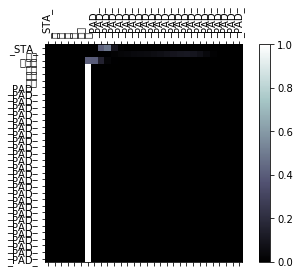

8 Source :  After You ` ve Gone _EOS_
8 Truth :  _STA_ 내 앞 에 이별 을 가져 다 준 거야
8 Prediction :  _STA_ 가야 끌어안 가야 가야 거니
8 BLEU Score :  0


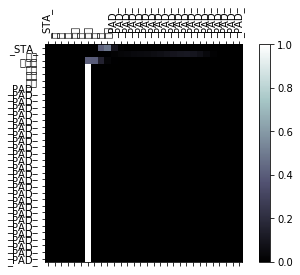

16 Source :  만약 에 말 야 ( 화생방 실 클레오파트라 ) ( Bonus Track ) _EOS_
16 Truth :  _STA_ 세월 에 닫혀 진 우리 의 날 이
16 Prediction :  솔직히 그렇 조금 그렇 인연
16 BLEU Score :  0


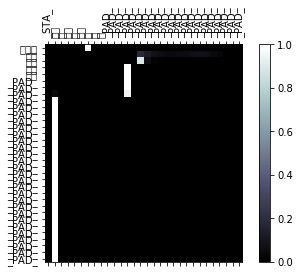

24 Source :  만약 에 말 야 ( 화생방 실 클레오파트라 ) ( Bonus Track ) _EOS_
24 Truth :  _STA_ 만약 에 말 야 만약 에 말 야
24 Prediction :  솔직히 그렇 조금 그렇 인연
24 BLEU Score :  0


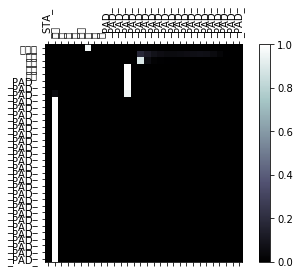

32 Source :  세상 의 중심 에서 사랑 을 외치 다 _EOS_
32 Truth :  _STA_ 너 의 길이 짧았 지만
32 Prediction :  _STA_ 너 웃고
32 BLEU Score :  0


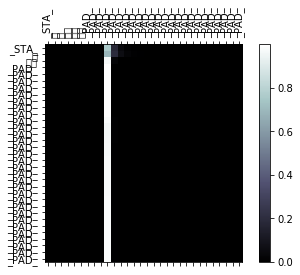

40 Source :  세상 의 중심 에서 사랑 을 외치 다 _EOS_
40 Truth :  _STA_ 그 걸 로 행복해 난
40 Prediction :  _STA_ 너 웃고
40 BLEU Score :  0


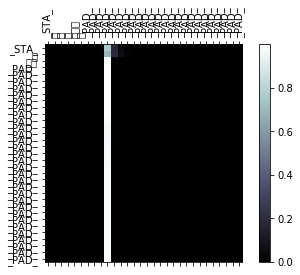

48 Source :  세상 의 중심 에서 사랑 을 외치 다 _EOS_
48 Truth :  _STA_ 내게 사랑 이란 건 오직 너 하나
48 Prediction :  _STA_ 너 웃고
48 BLEU Score :  0


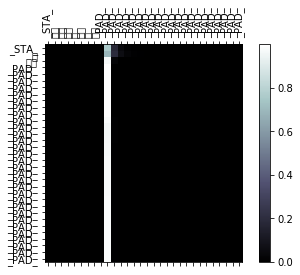

56 Source :  사랑 참 나쁘 다 _EOS_
56 Truth :  _STA_ 다 가져가
56 Prediction :  _STA_ 부족한 을 을 있게
56 BLEU Score :  0


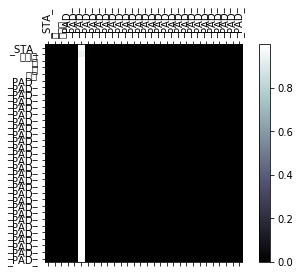

64 Source :  사랑 참 나쁘 다 _EOS_
64 Truth :  _STA_ 사랑 참 나쁘 다
64 Prediction :  _STA_ 부족한 을 을 있게
64 BLEU Score :  0


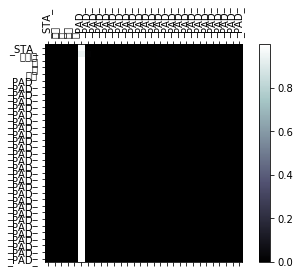

72 Source :  돌아오지 마 ( Acoustic Ver .) _EOS_
72 Truth :  _STA_ 넌 나 에게 돌아오지 마
72 Prediction :  _STA_ 여전히 다시 다시
72 BLEU Score :  0


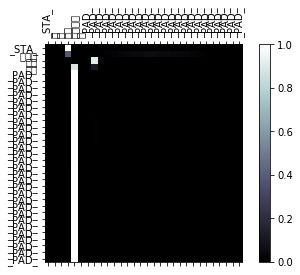

80 Source :  돌아오지 마 ( Acoustic Ver .) _EOS_
80 Truth :  _STA_ 맘 약해지 지 말고 잘 생각해
80 Prediction :  _STA_ 여전히 다시 다시
80 BLEU Score :  0


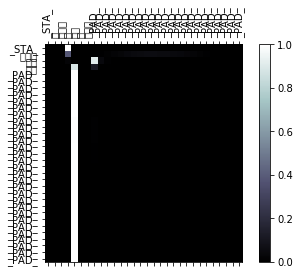

88 Source :  돌아오지 마 ( Acoustic Ver .) _EOS_
88 Truth :  _STA_ 너 에게 바라진 않아 이해
88 Prediction :  _STA_ 여전히 다시 다시
88 BLEU Score :  0


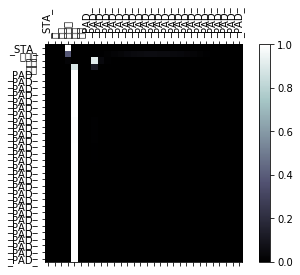

96 Source :  바보 _EOS_
96 Truth :  _STA_ 부탁해 요 곁 에 없어 도 몸조심 하세 요 참 힘겨워 했 잖 아요
96 Prediction :  _STA_ 그대 를 올 그대 걷고
96 BLEU Score :  0


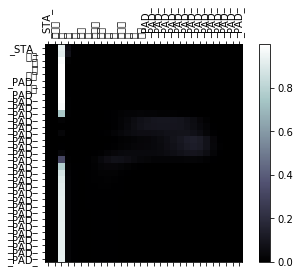

104 Source :  Promise U _EOS_
104 Truth :  _STA_ 난 너 를 잊어 갈 께
104 Prediction :  _STA_ 너 를 너 아름다운
104 BLEU Score :  0


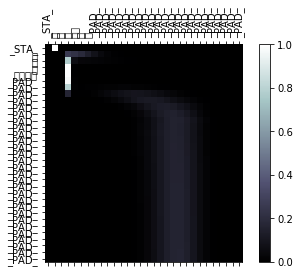

112 Source :  Promise U _EOS_
112 Truth :  _STA_ 믿고 살아왔 고
112 Prediction :  _STA_ 너 를 너 아름다운
112 BLEU Score :  0


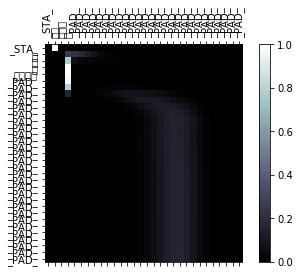

120 Source :  Promise U _EOS_
120 Truth :  _STA_ hold me Now cause
120 Prediction :  _STA_ 너 를 너 아름다운
120 BLEU Score :  0


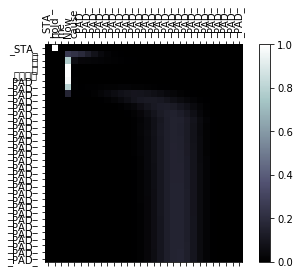

128 Source :  Promise U _EOS_
128 Truth :  _STA_ 가라 했 어 잊으 라 했 어
128 Prediction :  _STA_ 너 를 너 아름다운
128 BLEU Score :  0


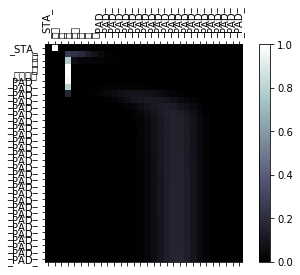

136 Source :  Promise U _EOS_
136 Truth :  _STA_ 알 겠 어 벌써 나 의 기억 속 에서
136 Prediction :  _STA_ 너 를 너 아름다운
136 BLEU Score :  0


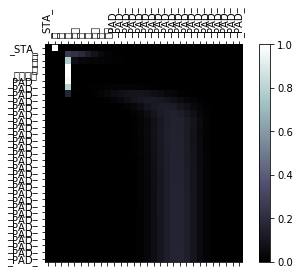

144 Source :  너무 깊이 생각하지 마 _EOS_
144 Truth :  _STA_ 가시 돋힌 폐허 속 에 남겨 진
144 Prediction :  _STA_ 그녀 어느새 기다리 기다리 기다리
144 BLEU Score :  0


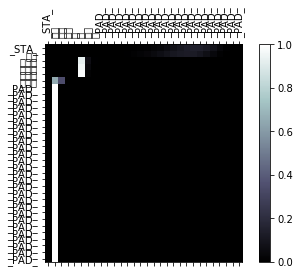

152 Source :  너무 깊이 생각하지 마 _EOS_
152 Truth :  _STA_ 그대 와 나누지 못 했 던 사랑
152 Prediction :  _STA_ 그녀 어느새 기다리 기다리 기다리
152 BLEU Score :  0


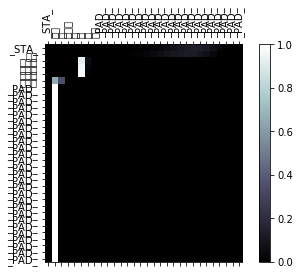

160 Source :  너무 깊이 생각하지 마 _EOS_
160 Truth :  _STA_ 아주 쉽 게 아주 쉽 게 잊 을 수 있어
160 Prediction :  _STA_ 그녀 어느새 기다리 기다리 기다리
160 BLEU Score :  0


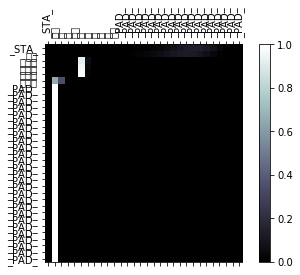

168 Source :  날 닮은 너 _EOS_
168 Truth :  _STA_ 니 가 지내 온 또 다른 시간 도
168 Prediction :  _STA_ 우리 를 마주
168 BLEU Score :  0


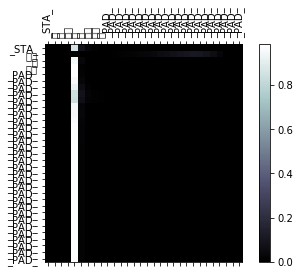

176 Source :  희망 _EOS_
176 Truth :  _STA_ 다시 걸어가지 새벽 을 향해서 그렇게
176 Prediction :  _STA_ 하얀 하얀 취한 본
176 BLEU Score :  0


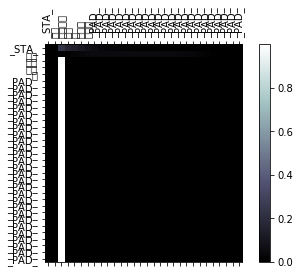

184 Source :  희망 _EOS_
184 Truth :  _STA_ 날개 로 너 를 감싸 주겠 어
184 Prediction :  _STA_ 하얀 하얀 취한 본
184 BLEU Score :  0


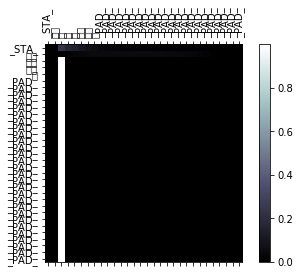

192 Source :  돌아오지 마 ( Feat . 용준형 Of 비스트 ) _EOS_
192 Truth :  _STA_ 널 위한 이별 같은 소리
192 Prediction :  _STA_ 너 게 너
192 BLEU Score :  0


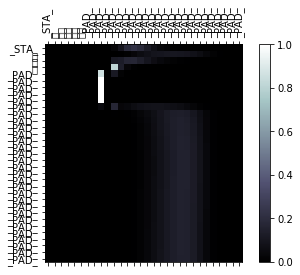

200 Source :  돌아오지 마 ( Feat . 용준형 Of 비스트 ) _EOS_
200 Truth :  _STA_ 만약 에 내 가 너 에게 전활 걸거 나
200 Prediction :  _STA_ 너 게 너
200 BLEU Score :  0


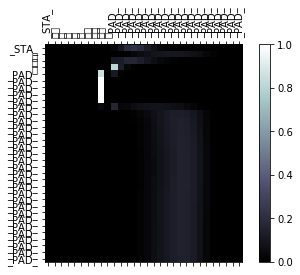

208 Source :  돌아오지 마 ( Feat . 용준형 Of 비스트 ) _EOS_
208 Truth :  _STA_ 말투 와 행동
208 Prediction :  _STA_ 너 게 너
208 BLEU Score :  0


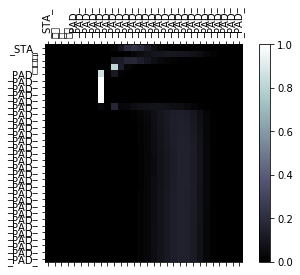

216 Source :  돌아오지 마 ( Feat . 용준형 Of 비스트 ) _EOS_
216 Truth :  _STA_ 방법 이 없어
216 Prediction :  _STA_ 너 게 너
216 BLEU Score :  0


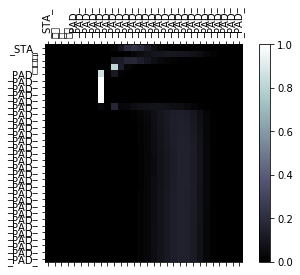

224 Source :  사랑하기 전 에는 _EOS_
224 Truth :  _STA_ 그대 사랑하기 전 에는
224 Prediction :  _STA_ 내 이 이
224 BLEU Score :  0


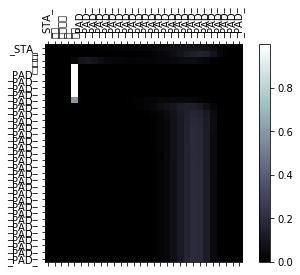

232 Source :  사랑하기 전 에는 _EOS_
232 Truth :  _STA_ 내 가 가진 사랑 모두 그대 에게
232 Prediction :  _STA_ 내 이 이
232 BLEU Score :  0


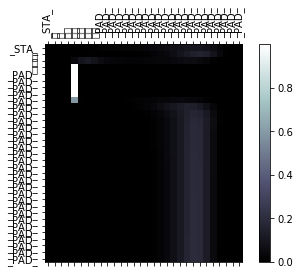

240 Source :  축가 ( Celebrate Love ) _EOS_
240 Truth :  _STA_ 알 아 가 게 되 겠 지
240 Prediction :  _STA_ 나 의
240 BLEU Score :  0


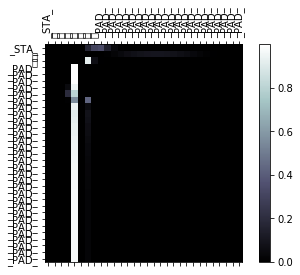

248 Source :  축가 ( Celebrate Love ) _EOS_
248 Truth :  _STA_ 아픔 을 함께 하고
248 Prediction :  _STA_ 나 의
248 BLEU Score :  0


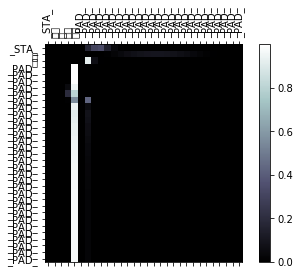

256 Source :  축가 ( Celebrate Love ) _EOS_
256 Truth :  _STA_ 두 손 을 잡고 서
256 Prediction :  _STA_ 나 의
256 BLEU Score :  0


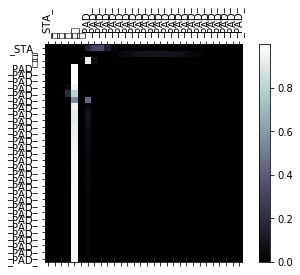

264 Source :  축가 ( Celebrate Love ) _EOS_
264 Truth :  _STA_ 서로 의 길이 돼 주고
264 Prediction :  _STA_ 나 의
264 BLEU Score :  0


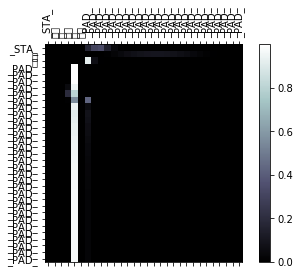

272 Source :  언제나 _EOS_
272 Truth :  _STA_ 무뎌진 기억 너머 로 너 를 그 리다
272 Prediction :  _STA_ 눈부신 길
272 BLEU Score :  0


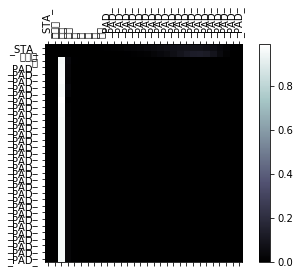

280 Source :  언제나 _EOS_
280 Truth :  _STA_ 아름다웠 던 그 추억
280 Prediction :  _STA_ 눈부신 길
280 BLEU Score :  0


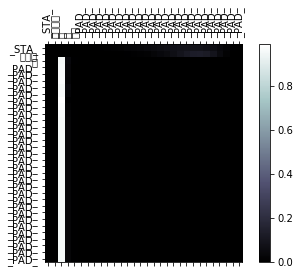

288 Source :  언제나 _EOS_
288 Truth :  _STA_ 누구 를 만나도 행복해야 만 해
288 Prediction :  _STA_ 눈부신 길
288 BLEU Score :  0


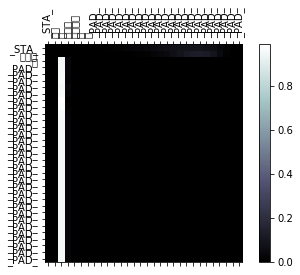

296 Source :  향기 만 남아 _EOS_
296 Truth :  _STA_ 니 가 없는 세상 에
296 Prediction :  _STA_ 너 를 을
296 BLEU Score :  0


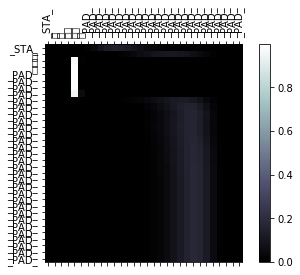

304 Source :  향기 만 남아 _EOS_
304 Truth :  _STA_ 너 를 따라 가고 싶어
304 Prediction :  _STA_ 너 를 을
304 BLEU Score :  0


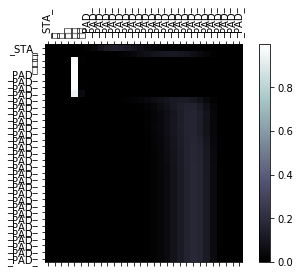

312 Source :  왜 하늘 은 ... _EOS_
312 Truth :  _STA_ 정말 아니었 는데
312 Prediction :  _STA_ 어떻 잖아 주기
312 BLEU Score :  0


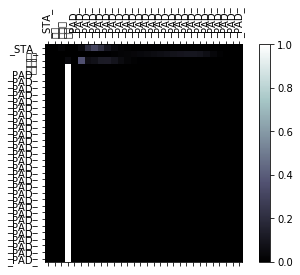

320 Source :  왜 하늘 은 ... _EOS_
320 Truth :  _STA_ 오 오오
320 Prediction :  _STA_ 어떻 잖아 주기
320 BLEU Score :  0


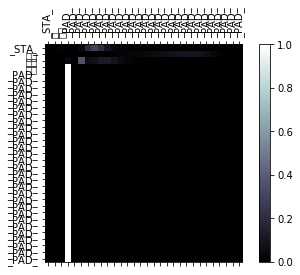

328 Source :  왜 하늘 은 ... _EOS_
328 Truth :  _STA_ 내 가 웃게 해 줄 게요
328 Prediction :  _STA_ 어떻 잖아 주기
328 BLEU Score :  0


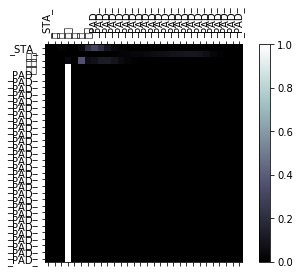

336 Source :  매일 매일 _EOS_
336 Truth :  _STA_ 아무런 말 없이 이대로
336 Prediction :  _STA_ 으니 하나로
336 BLEU Score :  0


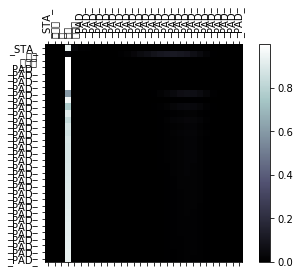

344 Source :  매일 매일 _EOS_
344 Truth :  _STA_ 아무런 말 없이 이대로
344 Prediction :  _STA_ 으니 하나로
344 BLEU Score :  0


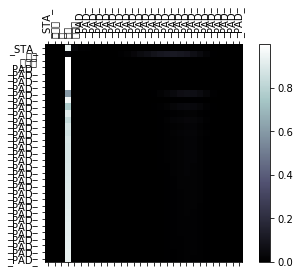

352 Source :  이 밤 이 지나면 ( 화생방 실 클레오파트라 ) ( Bonus Track ) _EOS_
352 Truth :  _STA_ 너 떠나는 날 흐르 던 눈물
352 Prediction :  시간 생각하면 지
352 BLEU Score :  0


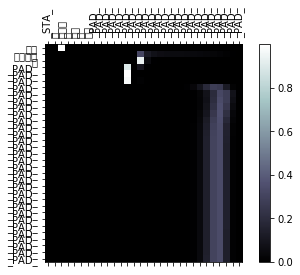

360 Source :  이 밤 이 지나면 ( 화생방 실 클레오파트라 ) ( Bonus Track ) _EOS_
360 Truth :  _STA_ 너무나 초라해 미칠 것 같아
360 Prediction :  시간 생각하면 지
360 BLEU Score :  0


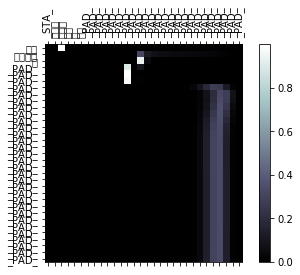

368 Source :  왜 하늘 은 _EOS_
368 Truth :  _STA_ 추억 을 모두 다 지워 도 지워 낼 수
368 Prediction :  _STA_ 그래 야만
368 BLEU Score :  0


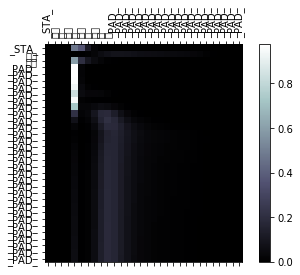

376 Source :  왜 하늘 은 _EOS_
376 Truth :  _STA_ 우리 다시 사랑할 수 없다 면
376 Prediction :  _STA_ 그래 야만
376 BLEU Score :  0


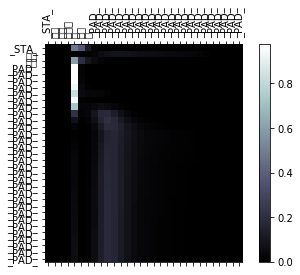

384 Source :  전화하지 말 아요 _EOS_
384 Truth :  _STA_ 애써 감추고 돌아서네 요
384 Prediction :  _STA_ 자 보지
384 BLEU Score :  0


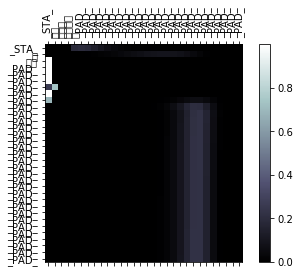

392 Source :  전화하지 말 아요 _EOS_
392 Truth :  _STA_ 다시 누군가 를 만나서
392 Prediction :  _STA_ 자 보지
392 BLEU Score :  0


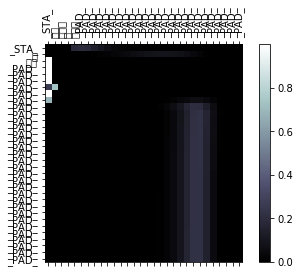

400 Source :  전화하지 말 아요 _EOS_
400 Truth :  _STA_ 다가 갈수록 미워 지 니까
400 Prediction :  _STA_ 자 보지
400 BLEU Score :  0


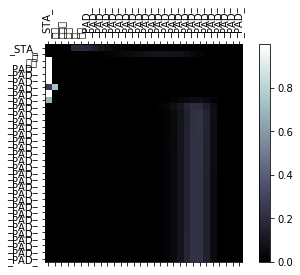

408 Source :  어디 에도 _EOS_
408 Truth :  _STA_ 솔직한 내 맘 을 고백 을 해
408 Prediction :  _STA_ 내 를 이
408 BLEU Score :  0


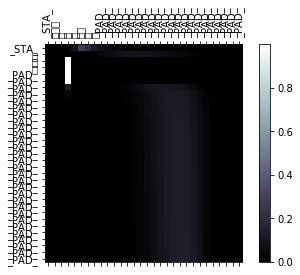

416 Source :  어디 에도 _EOS_
416 Truth :  _STA_ 계속 된 꿈 인 걸 까
416 Prediction :  _STA_ 내 를 이
416 BLEU Score :  0


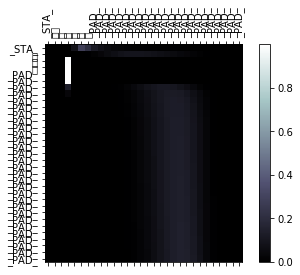

424 Source :  어디 에도 _EOS_
424 Truth :  _STA_ 믿 을 수 없 을 만큼 너 를 사랑해
424 Prediction :  _STA_ 내 를 이
424 BLEU Score :  0


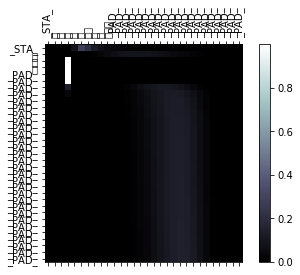

432 Source :  가슴 이 뛴 다 _EOS_
432 Truth :  _STA_ 얼마만큼 특별한 건지
432 Prediction :  _STA_ 그만 이란 해봐 하기
432 BLEU Score :  0


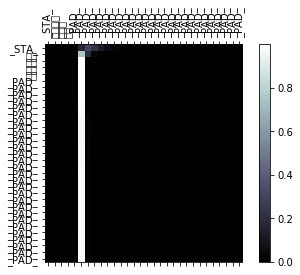

440 Source :  가슴 이 뛴 다 _EOS_
440 Truth :  _STA_ 그 꽃 한 송이 가
440 Prediction :  _STA_ 그만 이란 해봐 하기
440 BLEU Score :  0


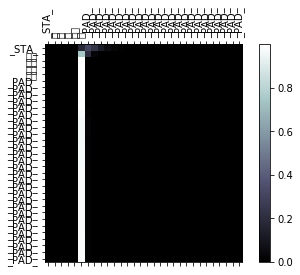

448 Source :  가슴 이 뛴 다 _EOS_
448 Truth :  _STA_ 그게 어려운 거야
448 Prediction :  _STA_ 그만 이란 해봐 하기
448 BLEU Score :  0


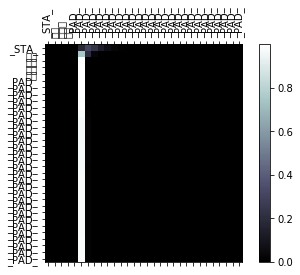

456 Source :  꽃송이 가 _EOS_
456 Truth :  _STA_ 세월 이 흩어 가는 것
456 Prediction :  _STA_ 이제 가 이


C:\Users\asd13\AppData\Local\Continuum\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


456 BLEU Score :  3.449648675961182e-05


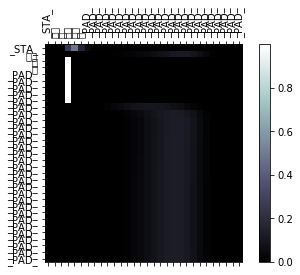

464 Source :  꽃송이 가 _EOS_
464 Truth :  _STA_ 세월 이 흩어 가는 것
464 Prediction :  _STA_ 이제 가 이
464 BLEU Score :  3.449648675961182e-05


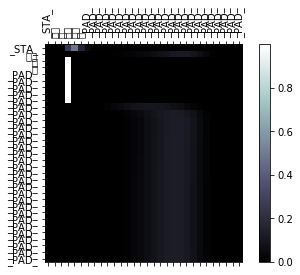

472 Source :  그녀 의 웃음소리 뿐 ( Feat . 하림 ) _EOS_
472 Truth :  _STA_ 두 눈 크게 뜨 고서
472 Prediction :  설레 고픈
472 BLEU Score :  0


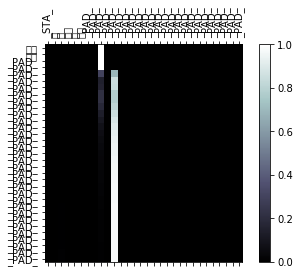

480 Source :  그녀 의 웃음소리 뿐 ( Feat . 하림 ) _EOS_
480 Truth :  _STA_ 하지만 너무 늦진 않길 바 래
480 Prediction :  설레 고픈
480 BLEU Score :  0


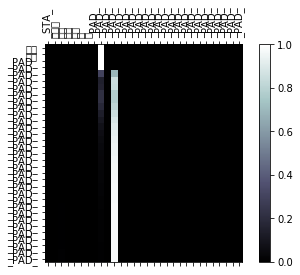

488 Source :  그녀 의 웃음소리 뿐 ( Feat . 하림 ) _EOS_
488 Truth :  _STA_ 어디 쯤 왔 니
488 Prediction :  설레 고픈
488 BLEU Score :  0


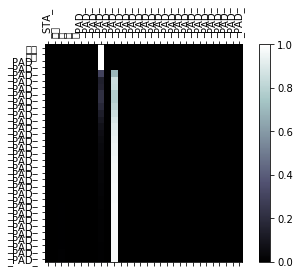

496 Source :  어디 쯤 왔 니 _EOS_
496 Truth :  _STA_ 가장 널 사랑할 게
496 Prediction :  _STA_ 다시 한번
496 BLEU Score :  0


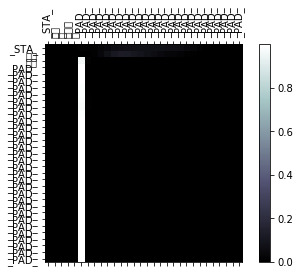

504 Source :  어디 쯤 왔 니 _EOS_
504 Truth :  _STA_ 우리 키스 할 까
504 Prediction :  _STA_ 다시 한번
504 BLEU Score :  0


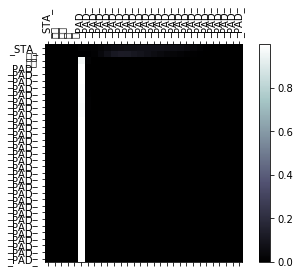

512 Source :  어디 쯤 왔 니 _EOS_
512 Truth :  _STA_ 오랫동안 홀로 누군지 도 모를
512 Prediction :  _STA_ 다시 한번
512 BLEU Score :  0


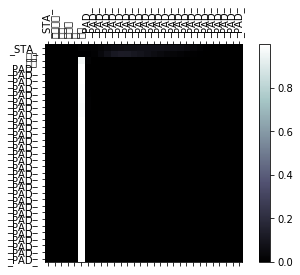

520 Source :  어디 쯤 왔 니 _EOS_
520 Truth :  _STA_ 나 용기 있는 남자 되어
520 Prediction :  _STA_ 다시 한번
520 BLEU Score :  0


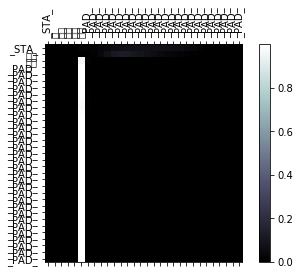

528 Source :  연애시대 ( Feat . Ra . D ) ( Narr . 한효주 ) _EOS_
528 Truth :  _STA_ 여자 에겐 힘든 건 가요
528 Prediction :  _STA_ 이런 버리 록 건가 니까
528 BLEU Score :  0


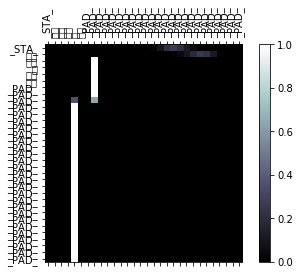

536 Source :  연애시대 ( Feat . Ra . D ) ( Narr . 한효주 ) _EOS_
536 Truth :  _STA_ 함께 해줄 사람 그대 인가요
536 Prediction :  _STA_ 이런 버리 록 건가 니까
536 BLEU Score :  0


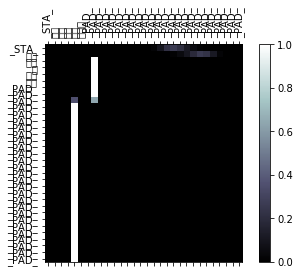

544 Source :  그런 사람 ( Duet Ver .) _EOS_
544 Truth :  _STA_ 원망 하고 미워하면 서
544 Prediction :  _STA_ 감고 얘길 거
544 BLEU Score :  0


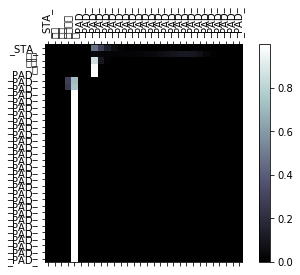

552 Source :  그런 사람 ( Duet Ver .) _EOS_
552 Truth :  _STA_ 내 곁 에 머물러 줘
552 Prediction :  _STA_ 감고 얘길 거
552 BLEU Score :  0


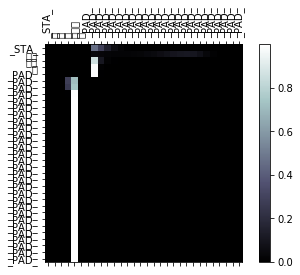

560 Source :  사랑한 다 할 수 있기 에 _EOS_
560 Truth :  _STA_ 목소리 와 passion 다 tension
560 Prediction :  _STA_ Turn up down up nd
560 BLEU Score :  0


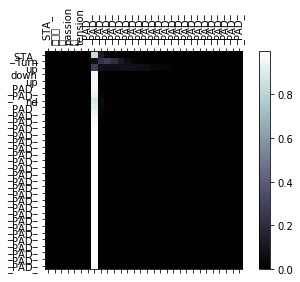

568 Source :  사랑한 다 할 수 있기 에 _EOS_
568 Truth :  _STA_ Prove me you are real 그리고
568 Prediction :  _STA_ Turn up down up nd
568 BLEU Score :  0


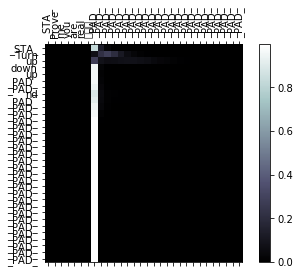

576 Source :  사랑한 다 할 수 있기 에 _EOS_
576 Truth :  _STA_ 두 근대
576 Prediction :  _STA_ Turn up down up nd
576 BLEU Score :  0


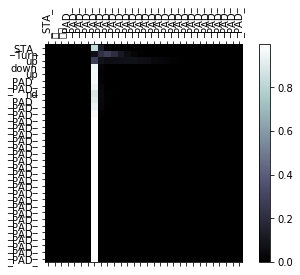

584 Source :  사랑한 다 할 수 있기 에 _EOS_
584 Truth :  _STA_ We the best Call me master Don ' t
584 Prediction :  _STA_ Turn up down up nd
584 BLEU Score :  0


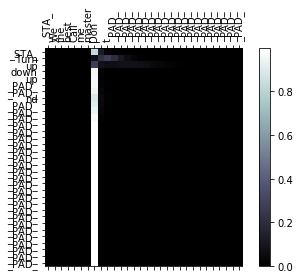

592 Source :  사랑한 다 할 수 있기 에 _EOS_
592 Truth :  _STA_ 묶었 지 이건 겨우 준비 운동
592 Prediction :  _STA_ Turn up down up nd
592 BLEU Score :  0


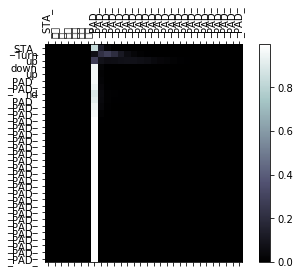

600 Source :  사랑한 다 할 수 있기 에 _EOS_
600 Truth :  _STA_ 기름 만땅 의 Bulldozer 느리 게
600 Prediction :  _STA_ Turn up down up nd
600 BLEU Score :  0


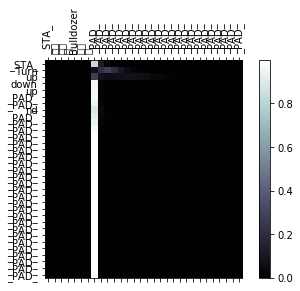

608 Source :  사랑한 다 할 수 있기 에 _EOS_
608 Truth :  _STA_ through the 1 st and 2 nd round
608 Prediction :  _STA_ Turn up down up nd
608 BLEU Score :  0


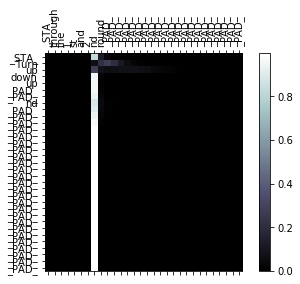

616 Source :  사랑한 다 할 수 있기 에 _EOS_
616 Truth :  _STA_ through the 1 st and 2 nd round
616 Prediction :  _STA_ Turn up down up nd
616 BLEU Score :  0


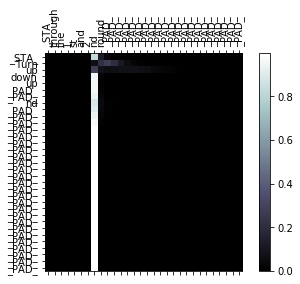

624 Source :  사랑한 다 할 수 있기 에 _EOS_
624 Truth :  _STA_ 니 맘 가는 대로 버튼 을 눌러
624 Prediction :  _STA_ Turn up down up nd
624 BLEU Score :  0


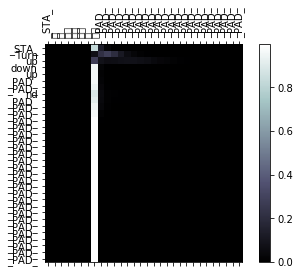

632 Source :  Show Me The Money _EOS_
632 Truth :  _STA_ 그리워 더 그리워
632 Prediction :  _STA_ 나 가 이
632 BLEU Score :  0


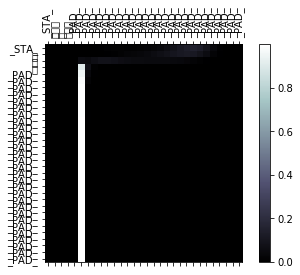

640 Source :  Show Me The Money _EOS_
640 Truth :  _STA_ 알 아 난 나 보다
640 Prediction :  _STA_ 나 가 이
640 BLEU Score :  0


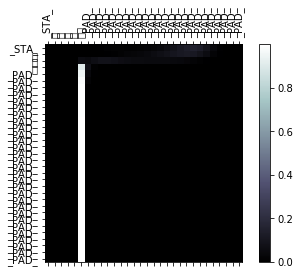

648 Source :  Show Me The Money _EOS_
648 Truth :  _STA_ 사랑해 널 사랑해
648 Prediction :  _STA_ 나 가 이
648 BLEU Score :  0


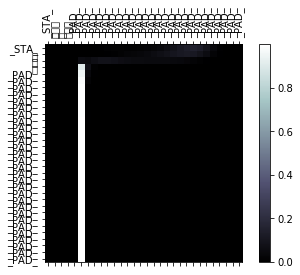

656 Source :  모노드라마 ( With 유승우 ) _EOS_
656 Truth :  _STA_ 그런 것 들 만 생각나
656 Prediction :  _STA_ 오직 가 들어
656 BLEU Score :  0


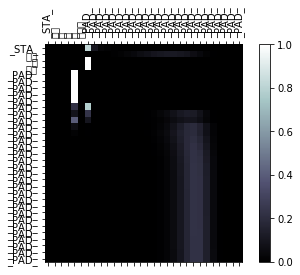

664 Source :  모노드라마 ( With 유승우 ) _EOS_
664 Truth :  _STA_ 지금 달려가
664 Prediction :  _STA_ 오직 가 들어
664 BLEU Score :  0


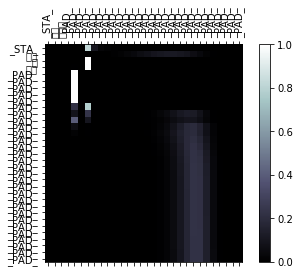

672 Source :  모노드라마 ( With 유승우 ) _EOS_
672 Truth :  _STA_ 약속할 게 난 영원 토록
672 Prediction :  _STA_ 오직 가 들어
672 BLEU Score :  0


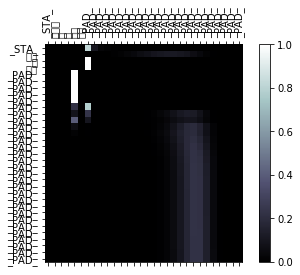

680 Source :  니 가 필요해 ( I Need You ) _EOS_
680 Truth :  _STA_ 그런 드라마 같은
680 Prediction :  _STA_ 나 이 기다리 기다리
680 BLEU Score :  0


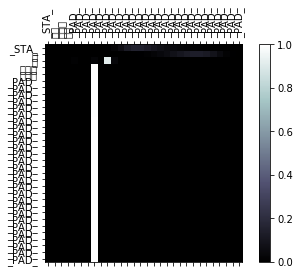

688 Source :  니 가 필요해 ( I Need You ) _EOS_
688 Truth :  _STA_ 만들 지 마 요
688 Prediction :  _STA_ 나 이 기다리 기다리
688 BLEU Score :  0


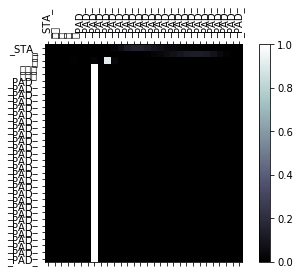

696 Source :  말꼬리 _EOS_
696 Truth :  _STA_ 그리워하면 언젠가 만나게 되는
696 Prediction :  _STA_ 나 의 에
696 BLEU Score :  0


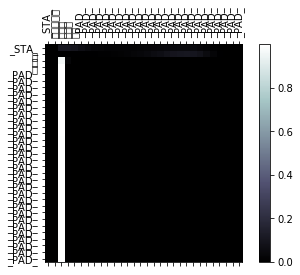

704 Source :  Never Ending Story _EOS_
704 Truth :  _STA_ 지금 이 순간 에 난 세상 가장 나약 한
704 Prediction :  내 맘속
704 BLEU Score :  0


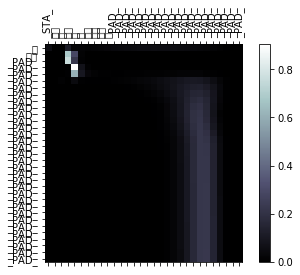

712 Source :  Never Ending Story _EOS_
712 Truth :  _STA_ 내 가 할 수 있는 것 이 란 단 한 가지 뿐 이야
712 Prediction :  내 맘속
712 BLEU Score :  0


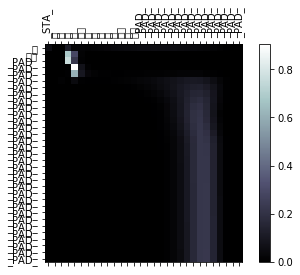

720 Source :  Never Ending Story _EOS_
720 Truth :  _STA_ 알 고 있 어 괜찮 아 너 떠나가지 만
720 Prediction :  내 맘속
720 BLEU Score :  0


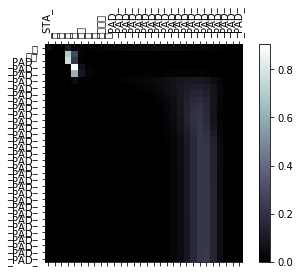

728 Source :  바보 같은 내게 _EOS_
728 Truth :  _STA_ 꿈길 에 그리는 곳 엔
728 Prediction :  _STA_ 겠죠 테 지만 지만
728 BLEU Score :  0


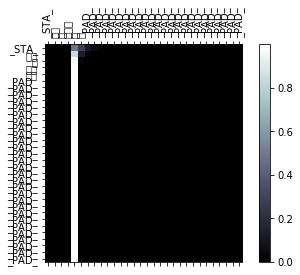

736 Source :  당신 이 날 불러 주 기 전 에는 _EOS_
736 Truth :  _STA_ 기 나 긴 내 외로움 들 도 이 젠
736 Prediction :  _STA_ 안되는 ’ 되돌려
736 BLEU Score :  0


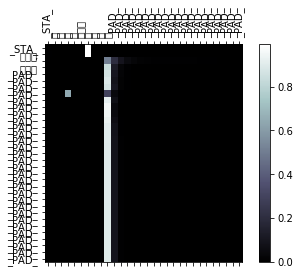

744 Source :  당신 이 날 불러 주 기 전 에는 _EOS_
744 Truth :  _STA_ 있 을 거 라 생각해
744 Prediction :  _STA_ 안되는 ’ 되돌려
744 BLEU Score :  0


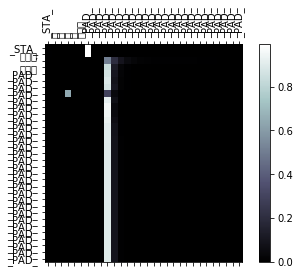

752 Source :  당신 이 날 불러 주 기 전 에는 _EOS_
752 Truth :  _STA_ 나 만의 신부 가 되는 꿈 을
752 Prediction :  _STA_ 안되는 ’ 되돌려
752 BLEU Score :  0


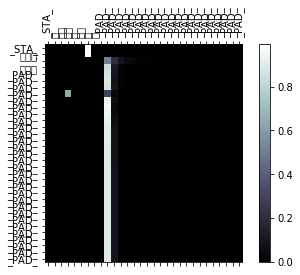

760 Source :  당신 이 날 불러 주 기 전 에는 _EOS_
760 Truth :  _STA_ 매일 꾸는 데
760 Prediction :  _STA_ 안되는 ’ 되돌려
760 BLEU Score :  0


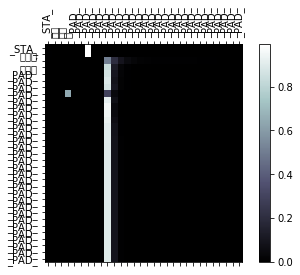

768 Source :  나 만의 신부 _EOS_
768 Truth :  _STA_ 처음 만난 그때 가 그리워 진 사람
768 Prediction :  만나 뭐라고 줄 모르
768 BLEU Score :  0


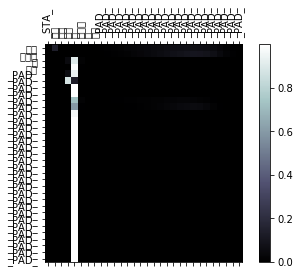

776 Source :  나 만의 신부 _EOS_
776 Truth :  _STA_ 왜
776 Prediction :  만나 뭐라고 줄 모르
776 BLEU Score :  0


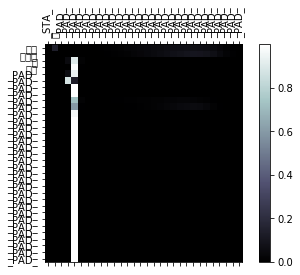

784 Source :  내 가 저지른 사랑 _EOS_
784 Truth :  _STA_ 오랜만 이 죠
784 Prediction :  _STA_ 안녕 야만 기다리 바램
784 BLEU Score :  0


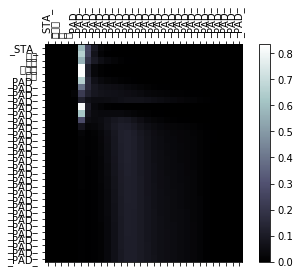

792 Source :  내 가 저지른 사랑 _EOS_
792 Truth :  _STA_ 오랜만 이네 요
792 Prediction :  _STA_ 안녕 야만 기다리 바램
792 BLEU Score :  0


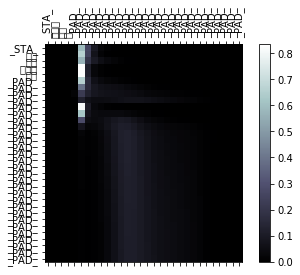

800 Source :  내 가 저지른 사랑 _EOS_
800 Truth :  _STA_ 난 어제 같은 데
800 Prediction :  _STA_ 안녕 야만 기다리 바램
800 BLEU Score :  0


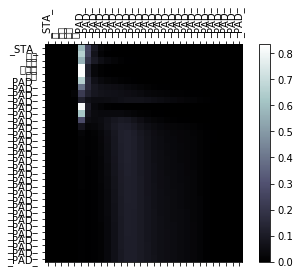

808 Source :  내 가 저지른 사랑 _EOS_
808 Truth :  _STA_ 정말 오랜만 이 죠
808 Prediction :  _STA_ 안녕 야만 기다리 바램
808 BLEU Score :  0


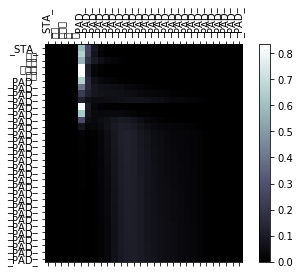

816 Source :  오랜만 이 죠 ( Feat . 신지수 ) _EOS_
816 Truth :  _STA_ 사랑하게 된 후 부터
816 Prediction :  _STA_ 만나고 허 말하고 점점
816 BLEU Score :  0


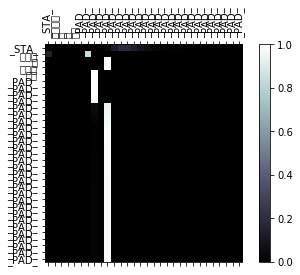

824 Source :  오랜만 이 죠 ( Feat . 신지수 ) _EOS_
824 Truth :  _STA_ 우 너무 빨리 변해 가 네
824 Prediction :  _STA_ 만나고 허 말하고 점점
824 BLEU Score :  0


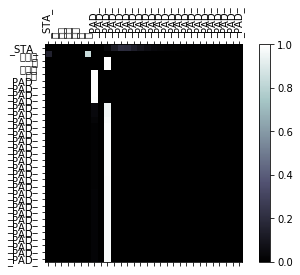

832 Source :  오랜만 이 죠 ( Feat . 신지수 ) _EOS_
832 Truth :  _STA_ 우 너무 빨리 변해 가 네
832 Prediction :  _STA_ 만나고 허 말하고 점점
832 BLEU Score :  0


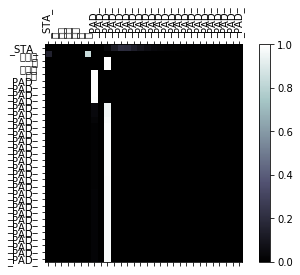

840 Source :  변해 가 네 _EOS_
840 Truth :  _STA_ 어린 왕자 Your Melody 찾아 떠날 래
840 Prediction :  _STA_ 커피 선명해 겨울
840 BLEU Score :  0


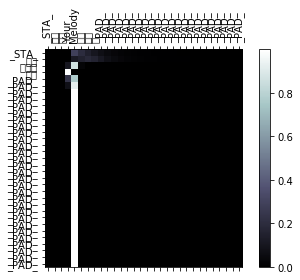

848 Source :  변해 가 네 _EOS_
848 Truth :  _STA_ Far away Ure my sunshine
848 Prediction :  _STA_ 커피 선명해 겨울
848 BLEU Score :  0


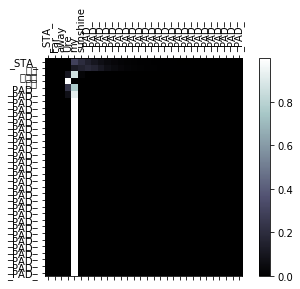

856 Source :  나 에게로 떠나는 여행 _EOS_
856 Truth :  _STA_ 매일 이별 하며 살 고 있구 나
856 Prediction :  _STA_ 나 이 에
856 BLEU Score :  0.0024729105095220414


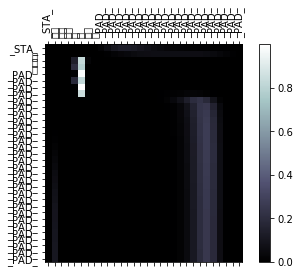

864 Source :  나 에게로 떠나는 여행 _EOS_
864 Truth :  _STA_ 내 가 떠나 보낸 것 도 아닌 데
864 Prediction :  _STA_ 나 이 에
864 BLEU Score :  0.0024729105095220414


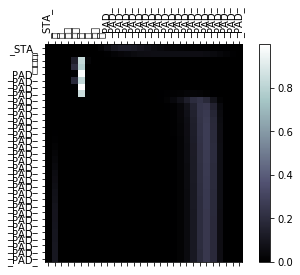

872 Source :  서른 즈음 에 _EOS_
872 Truth :  _STA_ 그리 울 네 얼굴 한 번 더 새긴 다
872 Prediction :  나 나 모르
872 BLEU Score :  0


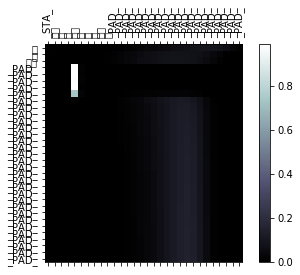

880 Source :  서른 즈음 에 _EOS_
880 Truth :  _STA_ 사랑한 다 사랑한 다 이 말 만 남긴 다
880 Prediction :  나 나 모르
880 BLEU Score :  0


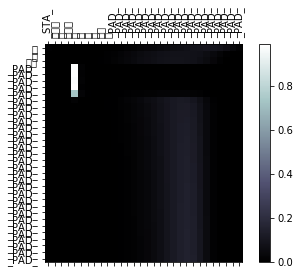

888 Source :  나 군대 간다 _EOS_
888 Truth :  _STA_ 내 마음 알아주게
888 Prediction :  _STA_ 슬퍼 이란
888 BLEU Score :  0


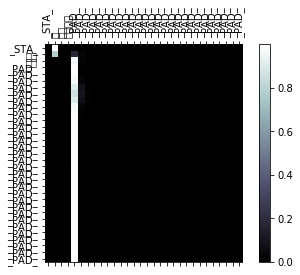

896 Source :  꽃비 _EOS_
896 Truth :  _STA_ 모른 척 살 았 던 니 얼굴 떠 올라 우리 함께했 던 그 시간 이 다시 떠 올라
896 Prediction :  _STA_ 그대 날 어때
896 BLEU Score :  0


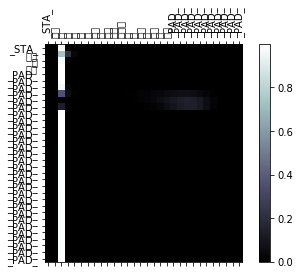

904 Source :  비 가 오는 날 엔 _EOS_
904 Truth :  _STA_ 시원한 바람 나를 반기 네
904 Prediction :  I 곳 얼굴
904 BLEU Score :  0


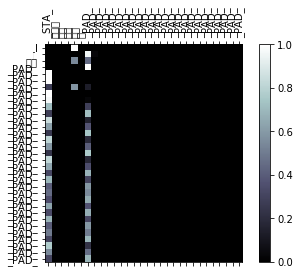

912 Source :  비 가 오는 날 엔 _EOS_
912 Truth :  _STA_ 여행 을 떠나 요 즐거운 마음 으로
912 Prediction :  I 곳 얼굴
912 BLEU Score :  0


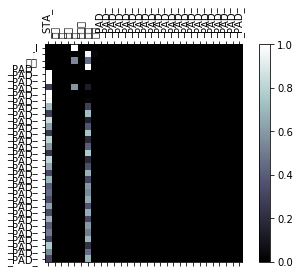

920 Source :  비 가 오는 날 엔 _EOS_
920 Truth :  _STA_ 계곡 속 에 흐르는 물 찾아
920 Prediction :  I 곳 얼굴
920 BLEU Score :  0


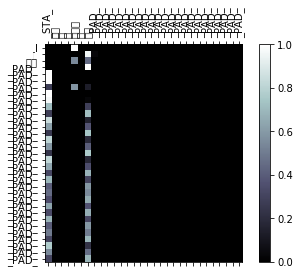

928 Source :  여행 을 떠나 요 _EOS_
928 Truth :  _STA_ 모든 게 무너져 가네
928 Prediction :  _STA_ 그대 이 느껴 들어가
928 BLEU Score :  0


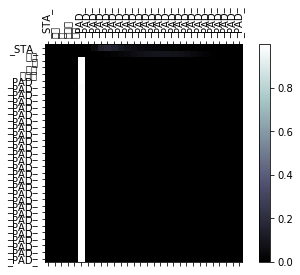

936 Source :  여행 을 떠나 요 _EOS_
936 Truth :  _STA_ 톱니바퀴 안 으로 들어가
936 Prediction :  _STA_ 그대 이 느껴 들어가
936 BLEU Score :  0


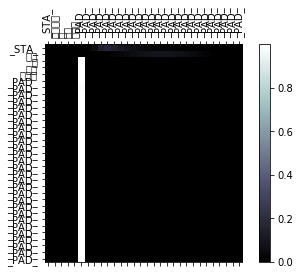

944 Source :  외로움 증폭 장치 ( 브래드 드럼 한판 쉬 기 ) _EOS_
944 Truth :  _STA_ 사랑 참 어렵 네요
944 Prediction :  _STA_ 뜨거운 만이 이
944 BLEU Score :  0


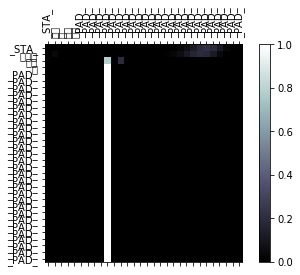

952 Source :  외로움 증폭 장치 ( 브래드 드럼 한판 쉬 기 ) _EOS_
952 Truth :  _STA_ 내 모든 걸 다 주어 도 부족하니 까
952 Prediction :  _STA_ 뜨거운 만이 이
952 BLEU Score :  0


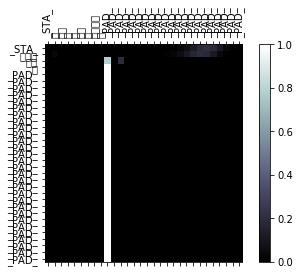

960 Source :  사랑 참 어렵 다 _EOS_
960 Truth :  _STA_ 그대 만이 내 안 에 울린 다
960 Prediction :  _STA_ 요즘 만의 되는 만들 bye
960 BLEU Score :  0


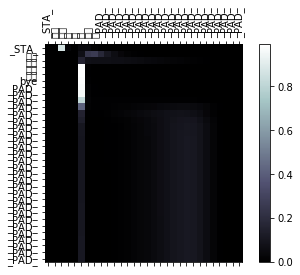

968 Source :  사랑 참 어렵 다 _EOS_
968 Truth :  _STA_ 모를 수 있 나요 그 이름 을
968 Prediction :  _STA_ 요즘 만의 되는 만들 bye
968 BLEU Score :  0


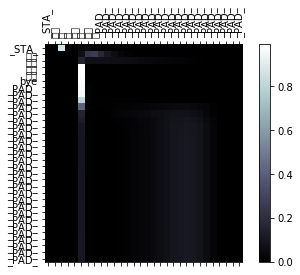

976 Source :  사랑 참 어렵 다 _EOS_
976 Truth :  _STA_ 똑같 은데 그대만 없는 날
976 Prediction :  _STA_ 요즘 만의 되는 만들 bye
976 BLEU Score :  0


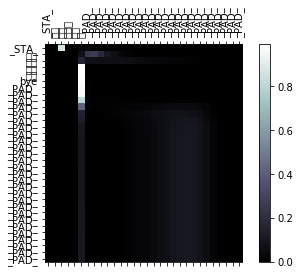

984 Source :  똑같 은 날 _EOS_
984 Truth :  _STA_ 숨 쉴 수도 없어
984 Prediction :  _STA_ 사라지는 어려워 게요
984 BLEU Score :  0


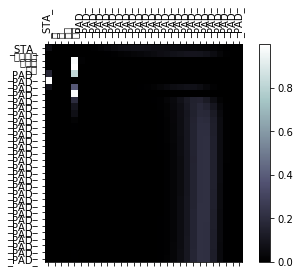

992 Source :  똑같 은 날 _EOS_
992 Truth :  _STA_ 너 를 지우고 나면
992 Prediction :  _STA_ 사라지는 어려워 게요
992 BLEU Score :  0


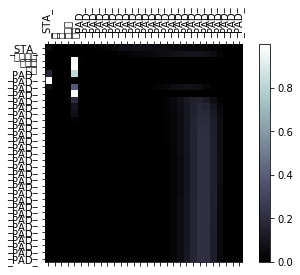

1000 Source :  드림 _EOS_
1000 Truth :  _STA_ 내 탄생 과 같았 던 기적
1000 Prediction :  _STA_ 해줄 라 라 라 라
1000 BLEU Score :  0


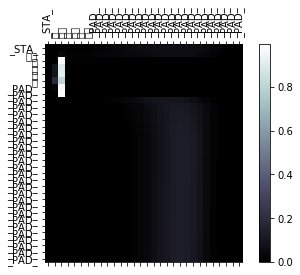

1008 Source :  드림 _EOS_
1008 Truth :  _STA_ I ' m not a plastic
1008 Prediction :  _STA_ 해줄 라 라 라 라
1008 BLEU Score :  0


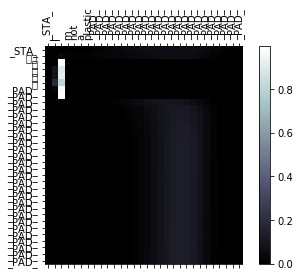

1016 Source :  드림 _EOS_
1016 Truth :  _STA_ 눈물 은 여전히 내리 고 있어
1016 Prediction :  _STA_ 해줄 라 라 라 라
1016 BLEU Score :  0


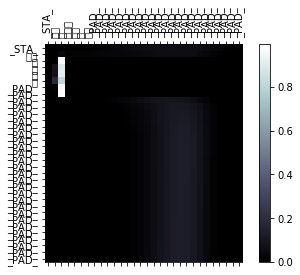

1024 Source :  드림 _EOS_
1024 Truth :  _STA_ 사랑 이 아니 라는 것 도
1024 Prediction :  _STA_ 해줄 라 라 라 라
1024 BLEU Score :  0


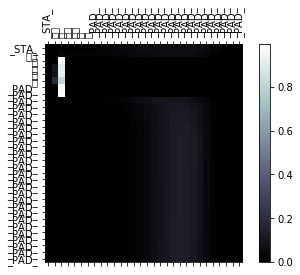

1032 Source :  드림 _EOS_
1032 Truth :  _STA_ 아침 에 일어나 무심코
1032 Prediction :  _STA_ 해줄 라 라 라 라
1032 BLEU Score :  0


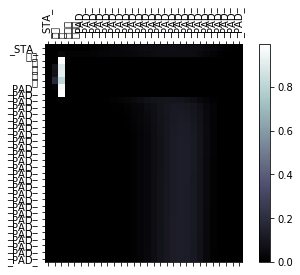

1040 Source :  드림 _EOS_
1040 Truth :  _STA_ I don ' t want to die without you
1040 Prediction :  _STA_ 해줄 라 라 라 라
1040 BLEU Score :  0


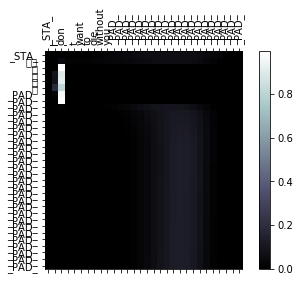

1048 Source :  PLASTIC ( Feat . 비 와 이 _ BewhY ) _EOS_
1048 Truth :  _STA_ 순간 마다 네 가 떠 올라
1048 Prediction :  _STA_ 편하게 밝은 배
1048 BLEU Score :  0


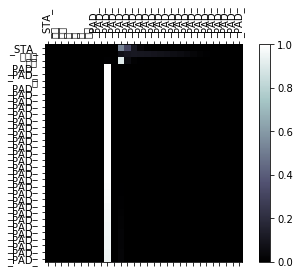

1056 Source :  PLASTIC ( Feat . 비 와 이 _ BewhY ) _EOS_
1056 Truth :  _STA_ 우린 행복했 던 걸 까
1056 Prediction :  _STA_ 편하게 밝은 배
1056 BLEU Score :  0


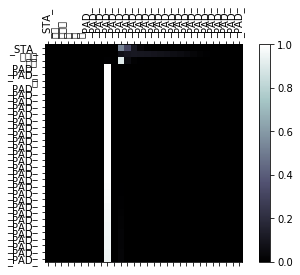

1064 Source :  PLASTIC ( Feat . 비 와 이 _ BewhY ) _EOS_
1064 Truth :  _STA_ 우린 어디 쯤 있 을까
1064 Prediction :  _STA_ 편하게 밝은 배
1064 BLEU Score :  0


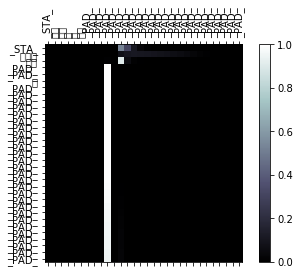

1072 Source :  되돌리 다 _EOS_
1072 Truth :  _STA_ 널 잊어 야 해 힘들어 도
1072 Prediction :  _STA_ 끝나지 수
1072 BLEU Score :  0


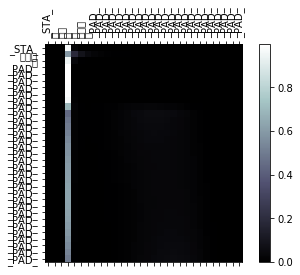

1080 Source :  되돌리 다 _EOS_
1080 Truth :  _STA_ 잊 을께 ( 잊 을께 ) 잊 을께 ( 잊 을께 )
1080 Prediction :  _STA_ 끝나지 수
1080 BLEU Score :  0


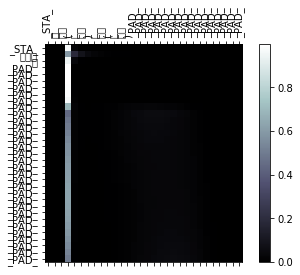

1088 Source :  잊 을께 _EOS_
1088 Truth :  _STA_ 이 세상 엔 아픈 것 들이
1088 Prediction :  몇 를 더 몇 떠
1088 BLEU Score :  0


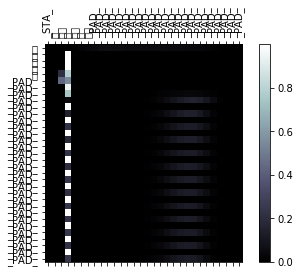

1096 Source :  잊 을께 _EOS_
1096 Truth :  _STA_ 아름답 기 위해 선
1096 Prediction :  몇 를 더 몇 떠
1096 BLEU Score :  0


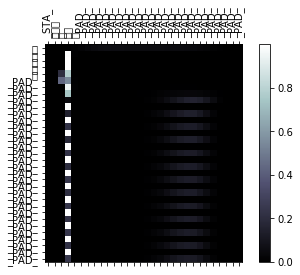

1104 Source :  잊 을께 _EOS_
1104 Truth :  _STA_ 꽃 이 필 때 꽃 이 질 때
1104 Prediction :  몇 를 더 몇 떠
1104 BLEU Score :  0


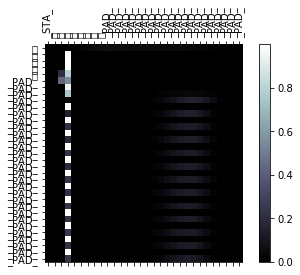

1112 Source :  친구 야 너 는 아니 _EOS_
1112 Truth :  _STA_ 힘겹 게 보내며
1112 Prediction :  우 온
1112 BLEU Score :  0


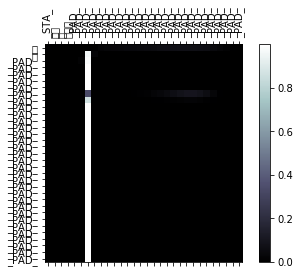

1120 Source :  친구 야 너 는 아니 _EOS_
1120 Truth :  _STA_ 무엇 으로 채워 지 려나
1120 Prediction :  우 온
1120 BLEU Score :  0


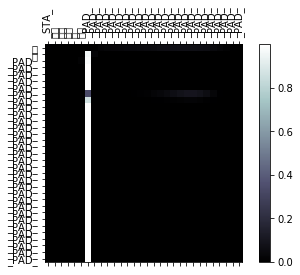

1128 Source :  친구 야 너 는 아니 _EOS_
1128 Truth :  _STA_ 무엇 으로 채워 지 려나
1128 Prediction :  우 온
1128 BLEU Score :  0


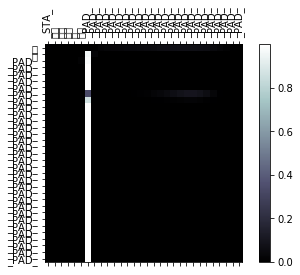

1136 Source :  내 마음 에 비친 내 모습 _EOS_
1136 Truth :  _STA_ 그땐 미처 알 지 못 했 지
1136 Prediction :  _STA_ 너 던 던 소중했 이여
1136 BLEU Score :  0


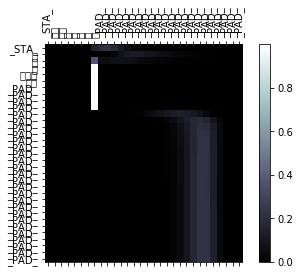

1144 Source :  그땐 미처 알 지 못 했 지 _EOS_
1144 Truth :  _STA_ 그 곳 에 가려 고 하네
1144 Prediction :  _STA_ 멍하니 꿈속 으면
1144 BLEU Score :  0


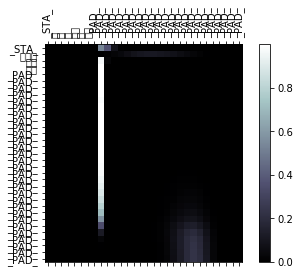

1152 Source :  그땐 미처 알 지 못 했 지 _EOS_
1152 Truth :  _STA_ 달리 보면 그 만인 것 을
1152 Prediction :  _STA_ 멍하니 꿈속 으면
1152 BLEU Score :  0


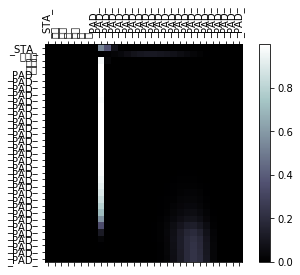

1160 Source :  그땐 미처 알 지 못 했 지 _EOS_
1160 Truth :  _STA_ 달리 보면 그 만인 것 을
1160 Prediction :  _STA_ 멍하니 꿈속 으면
1160 BLEU Score :  0


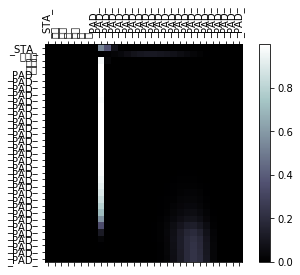

1168 Source :  내 마음 에 비친 내 모습 _EOS_
1168 Truth :  _STA_ 따뜻한 너 의 체온
1168 Prediction :  _STA_ 너 던 던 소중했 이여
1168 BLEU Score :  0


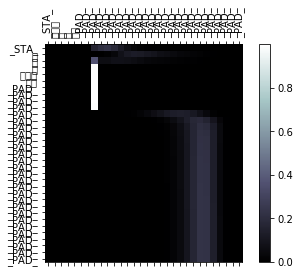

1176 Source :  내 마음 에 비친 내 모습 _EOS_
1176 Truth :  _STA_ 찬란 하게 반짝 이던 눈동자 여
1176 Prediction :  _STA_ 너 던 던 소중했 이여
1176 BLEU Score :  0


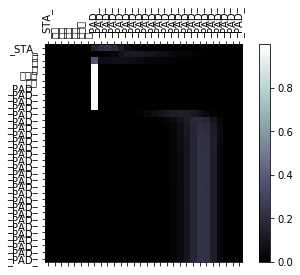

1184 Source :  내 마음 에 비친 내 모습 _EOS_
1184 Truth :  _STA_ 멋있게 살 아 줘
1184 Prediction :  _STA_ 너 던 던 소중했 이여
1184 BLEU Score :  0


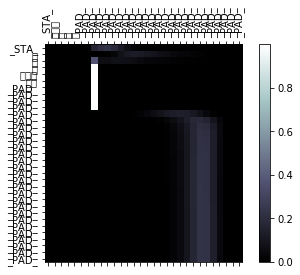

1192 Source :  뜨거운 안녕 ( Vocal 이지형 ) _EOS_
1192 Truth :  _STA_ 잘 되 지 않기 를 바랬는지 도 몰라 요
1192 Prediction :  _STA_ 오늘이 한번 오늘이 요 주고 요 요
1192 BLEU Score :  0


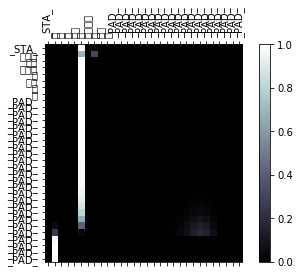

1200 Source :  세상 이 그대 를 속일 지 라도 _EOS_
1200 Truth :  _STA_ 떠난 다는 그 남자
1200 Prediction :  _STA_ 나 다
1200 BLEU Score :  0


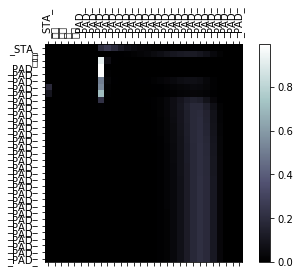

1208 Source :  세상 이 그대 를 속일 지 라도 _EOS_
1208 Truth :  _STA_ 모든 걸 다 주 니까
1208 Prediction :  _STA_ 나 다
1208 BLEU Score :  0


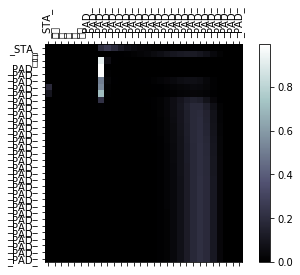

1216 Source :  세상 이 그대 를 속일 지 라도 _EOS_
1216 Truth :  _STA_ 다 믿었 었 어 우리둘 이
1216 Prediction :  _STA_ 나 다
1216 BLEU Score :  0


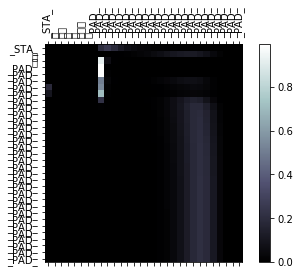

1224 Source :  그 남자 그 여자 ( Feat . 장혜진 ) _EOS_
1224 Truth :  _STA_ 다지는 소 떼 를 몰거 야
1224 Prediction :  _STA_ 그것 잘
1224 BLEU Score :  0


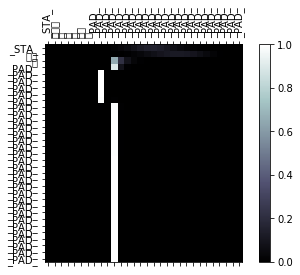

1232 Source :  그 남자 그 여자 ( Feat . 장혜진 ) _EOS_
1232 Truth :  _STA_ 서부 의 총잡이 되 볼까
1232 Prediction :  _STA_ 그것 잘
1232 BLEU Score :  0


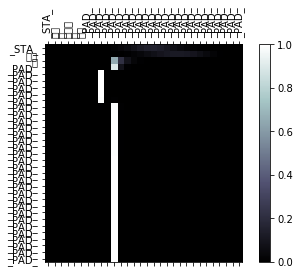

1240 Source :  비망록 ( 스물 의 노래 ) _EOS_
1240 Truth :  _STA_ 얼마나 더 가야 하는 지
1240 Prediction :  _STA_ 굳이 지도 야 중
1240 BLEU Score :  0


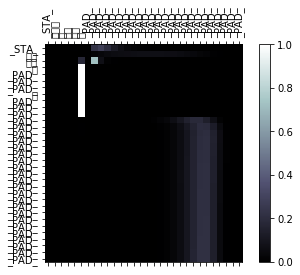

1248 Source :  비망록 ( 스물 의 노래 ) _EOS_
1248 Truth :  _STA_ 지금 이 노래 를 들어 봐 눈 을 감아
1248 Prediction :  _STA_ 굳이 지도 야 중
1248 BLEU Score :  0


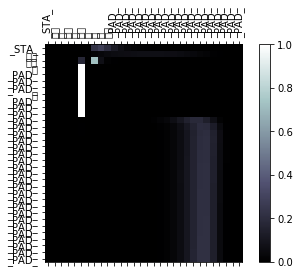

1256 Source :  비망록 ( 스물 의 노래 ) _EOS_
1256 Truth :  _STA_ It ' s gonna be alright
1256 Prediction :  _STA_ 굳이 지도 야 중
1256 BLEU Score :  0


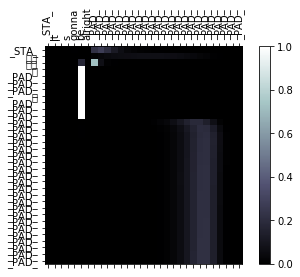

1264 Source :  Gift _EOS_
1264 Truth :  _STA_ 포기할 수 는 없겠 죠
1264 Prediction :  _STA_ 그래 그래
1264 BLEU Score :  0


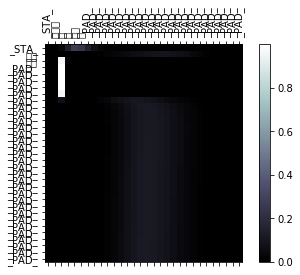

1272 Source :  Gift _EOS_
1272 Truth :  _STA_ 붙잡 을 수 는 없겠 죠
1272 Prediction :  _STA_ 그래 그래
1272 BLEU Score :  0


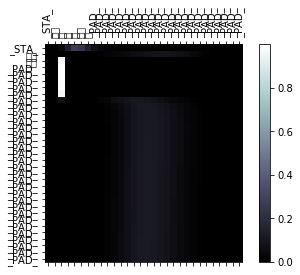

1280 Source :  Gift _EOS_
1280 Truth :  _STA_ 나 는 사실 이 성적 인 게
1280 Prediction :  _STA_ 그래 그래
1280 BLEU Score :  0


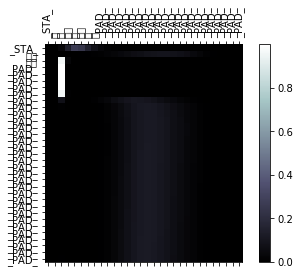

1288 Source :  Gift _EOS_
1288 Truth :  _STA_ 날 안아 주 진 않았 을까요
1288 Prediction :  _STA_ 그래 그래
1288 BLEU Score :  0


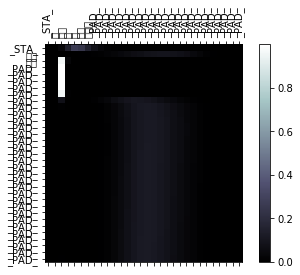

1296 Source :  나 만 안되는 연애 _EOS_
1296 Truth :  _STA_ 언젠가 는 같은 하늘 에 뜰 거야
1296 Prediction :  _STA_ 고개 의 고개 고개
1296 BLEU Score :  0


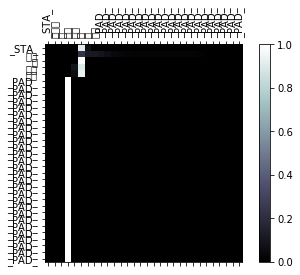

1304 Source :  꿈꾸는 소녀 _EOS_
1304 Truth :  _STA_ 아지 런히 떠오른 많은 기억 이
1304 Prediction :  _STA_ 당신 당신 당신 당신
1304 BLEU Score :  0


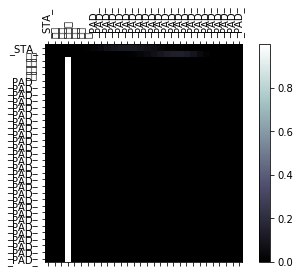

1312 Source :  꿈꾸는 소녀 _EOS_
1312 Truth :  _STA_ 눈물 로 빚어 낸 조각 들 로
1312 Prediction :  _STA_ 당신 당신 당신 당신
1312 BLEU Score :  0


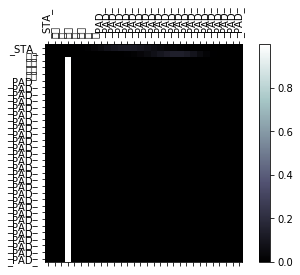

1320 Source :  추억 에 살 아 ( Feat . 이영현 ) _EOS_
1320 Truth :  _STA_ 눈 을 감고 걸어 요
1320 Prediction :  _STA_ 기적 기적 뿐이
1320 BLEU Score :  0


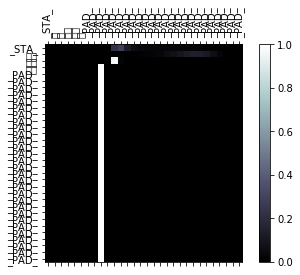

1328 Source :  추억 에 살 아 ( Feat . 이영현 ) _EOS_
1328 Truth :  _STA_ 잠시 만 숨 을 고르 면
1328 Prediction :  _STA_ 기적 기적 뿐이
1328 BLEU Score :  0


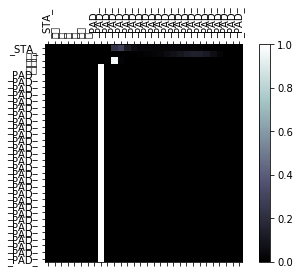

1336 Source :  소나무 _EOS_
1336 Truth :  _STA_ 그냥 홀로 지킬 수 있 는걸 요
1336 Prediction :  _STA_ 조금 많이 거 거 거
1336 BLEU Score :  0


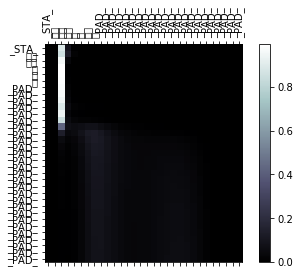

1344 Source :  소나무 _EOS_
1344 Truth :  _STA_ 울 다 지쳐 그대 를 찾겠 죠
1344 Prediction :  _STA_ 조금 많이 거 거 거
1344 BLEU Score :  0


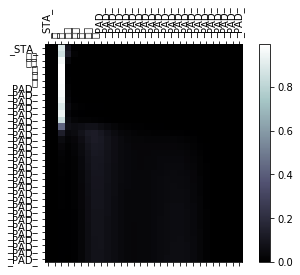

1352 Source :  소나무 _EOS_
1352 Truth :  _STA_ 신경 쓰 지 말 아요
1352 Prediction :  _STA_ 조금 많이 거 거 거
1352 BLEU Score :  0


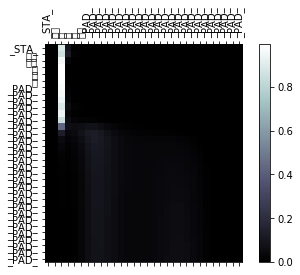

1360 Source :  인형 ( Duet . 신혜성 ) _EOS_
1360 Truth :  _STA_ 너 는 모르 지 너 는 모르 지
1360 Prediction :  _STA_ 나 세월 에
1360 BLEU Score :  0


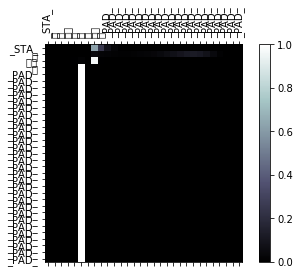

1368 Source :  인형 ( Duet . 신혜성 ) _EOS_
1368 Truth :  _STA_ 너 를 사랑한 내 잘못 이 지
1368 Prediction :  _STA_ 나 세월 에
1368 BLEU Score :  0


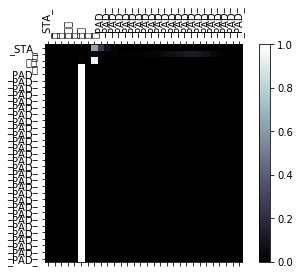

1376 Source :  세 사람 _EOS_
1376 Truth :  _STA_ 나 만의 그대 나 의 그대
1376 Prediction :  _STA_ 더 줄 어도
1376 BLEU Score :  0


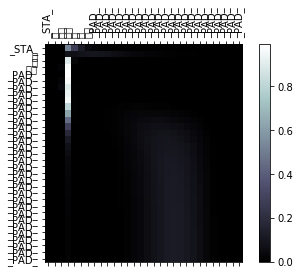

1384 Source :  세 사람 _EOS_
1384 Truth :  _STA_ 내 가 어떻 게 내 가
1384 Prediction :  _STA_ 더 줄 어도
1384 BLEU Score :  0


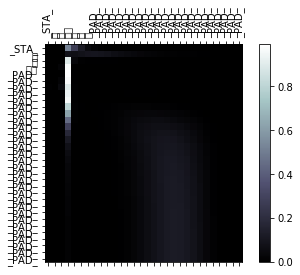

1392 Source :  세 사람 _EOS_
1392 Truth :  _STA_ 무려 우리 함께 잠드는 이 밤 과
1392 Prediction :  _STA_ 더 줄 어도
1392 BLEU Score :  0


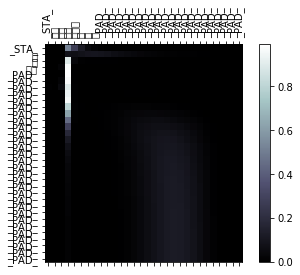

1400 Source :  그대 라는 사치 ( 짐승남 강백호 ) _EOS_
1400 Truth :  _STA_ 우리 이 별하나 봐
1400 Prediction :  너 을 (
1400 BLEU Score :  0.026125057038179193


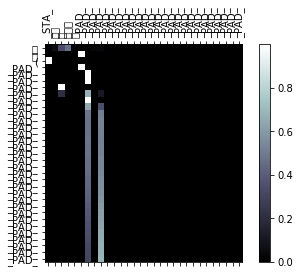

1408 Source :  그대 라는 사치 ( 짐승남 강백호 ) _EOS_
1408 Truth :  _STA_ 그 계절 의 우리 까만 밤 하늘 에
1408 Prediction :  너 을 (
1408 BLEU Score :  0.026125057038179193


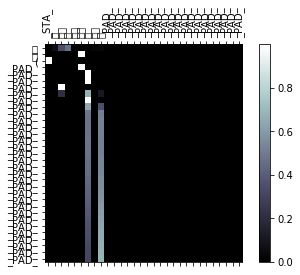

1416 Source :  그 계절 의 우리 _EOS_
1416 Truth :  _STA_ 우리 옛날 에
1416 Prediction :  I '
1416 BLEU Score :  0


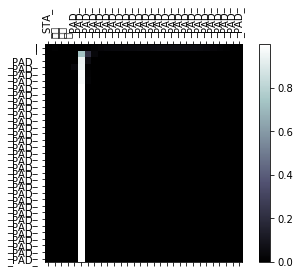

1424 Source :  Fine Thank You And You ? _EOS_
1424 Truth :  _STA_ 그리워 하고 있어 요
1424 Prediction :  _STA_ 음악 라 라
1424 BLEU Score :  0


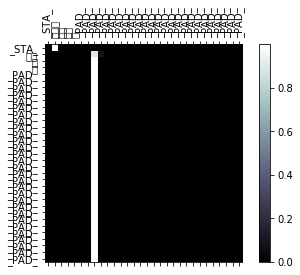

1432 Source :  Fine Thank You And You ? _EOS_
1432 Truth :  _STA_ 난 아 무것 도 할 수 가 없어
1432 Prediction :  _STA_ 음악 라 라
1432 BLEU Score :  0


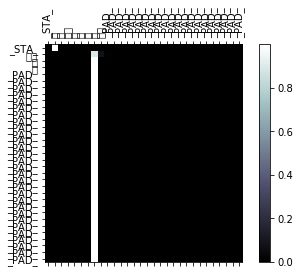

1440 Source :  Fine Thank You And You ? _EOS_
1440 Truth :  _STA_ 이제 다시 만나 요
1440 Prediction :  _STA_ 음악 라 라
1440 BLEU Score :  0


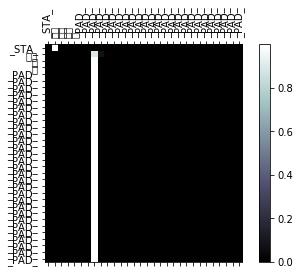

1448 Source :  지금 만나러 가요 _EOS_
1448 Truth :  _STA_ 나란히 걷던 너 와 나
1448 Prediction :  _STA_ 어느 무도 어느
1448 BLEU Score :  0


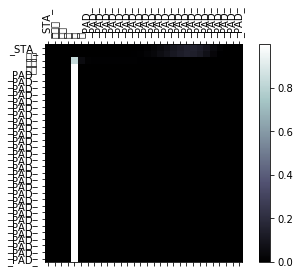

1456 Source :  지금 만나러 가요 _EOS_
1456 Truth :  _STA_ 소리 없이 눈물 만 흐르 네
1456 Prediction :  _STA_ 어느 무도 어느
1456 BLEU Score :  0


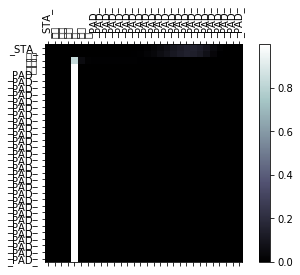

1464 Source :  지금 만나러 가요 _EOS_
1464 Truth :  _STA_ 서 둘 러 도망치 듯 달려온
1464 Prediction :  _STA_ 어느 무도 어느
1464 BLEU Score :  0


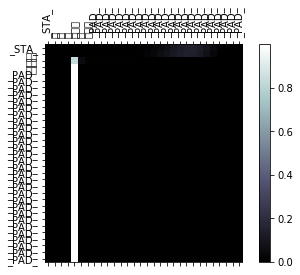

1472 Source :  너 의 바다 에 머무 네 ( With 김동률 ) _EOS_
1472 Truth :  _STA_ 정말 남 이야
1472 Prediction :  _STA_ 언젠가 이대로 하죠
1472 BLEU Score :  0


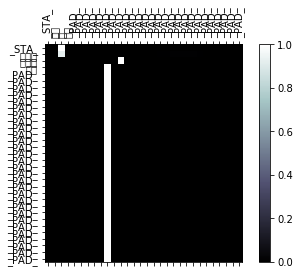

1480 Source :  너 의 바다 에 머무 네 ( With 김동률 ) _EOS_
1480 Truth :  _STA_ 널 잃고 이렇게
1480 Prediction :  _STA_ 언젠가 이대로 하죠
1480 BLEU Score :  0


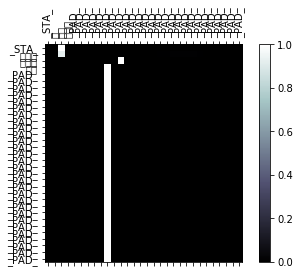

1488 Source :  너 의 바다 에 머무 네 ( With 김동률 ) _EOS_
1488 Truth :  _STA_ 오늘 도 난 술 이야
1488 Prediction :  _STA_ 언젠가 이대로 하죠
1488 BLEU Score :  0


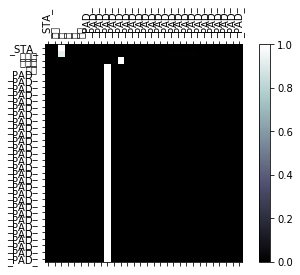

1496 Source :  술 이야 _EOS_
1496 Truth :  _STA_ 빛 은 모두 사라진 걸
1496 Prediction :  하루 그녀 그녀 그녀
1496 BLEU Score :  0


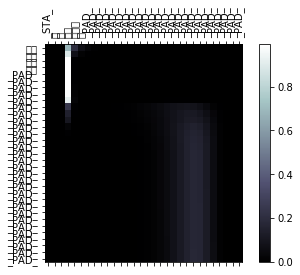

1504 Source :  술 이야 _EOS_
1504 Truth :  _STA_ 조금 더 널 보고 싶 을 뿐 야
1504 Prediction :  하루 그녀 그녀 그녀
1504 BLEU Score :  0


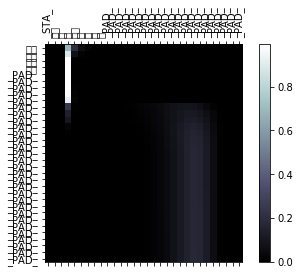

1512 Source :  그녀 가 나를 보네 ... _EOS_
1512 Truth :  _STA_ 그런 질투 어린 모습 이
1512 Prediction :  기회 빠져 고픈 되는
1512 BLEU Score :  0


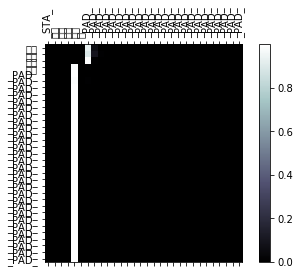

1520 Source :  그녀 가 나를 보네 ... _EOS_
1520 Truth :  _STA_ 세상 예쁜 여자 데려 다 놔 도
1520 Prediction :  기회 빠져 고픈 되는
1520 BLEU Score :  0


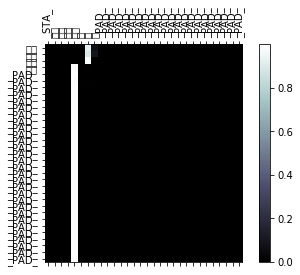

1528 Source :  그녀 가 나를 보네 ... _EOS_
1528 Truth :  _STA_ 그래 나도 너 를
1528 Prediction :  기회 빠져 고픈 되는
1528 BLEU Score :  0


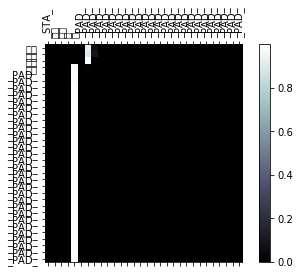

1536 Source :  질투 가 좋 아 _EOS_
1536 Truth :  _STA_ Hey Miss short skirt lady
1536 Prediction :  _STA_ 후회 라도 에게 후회
1536 BLEU Score :  0


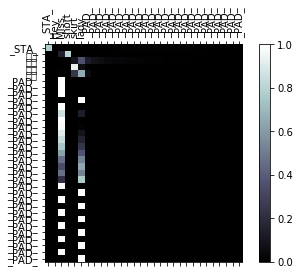

1544 Source :  질투 가 좋 아 _EOS_
1544 Truth :  _STA_ 조금 은 녹아
1544 Prediction :  _STA_ 후회 라도 에게 후회
1544 BLEU Score :  0


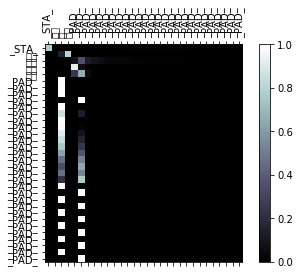

1552 Source :  질투 가 좋 아 _EOS_
1552 Truth :  _STA_ 싫어 이렇게 심술 부리 는 거야
1552 Prediction :  _STA_ 후회 라도 에게 후회
1552 BLEU Score :  0


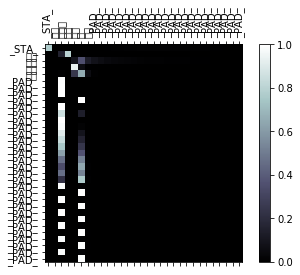

1560 Source :  심술 _EOS_
1560 Truth :  _STA_ 확신 을 해야 돼 넌
1560 Prediction :  사랑해 의 취한
1560 BLEU Score :  0


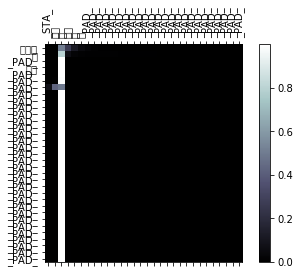

1568 Source :  심술 _EOS_
1568 Truth :  _STA_ 널 참 많이 좋아하는 난 데
1568 Prediction :  사랑해 의 취한
1568 BLEU Score :  0


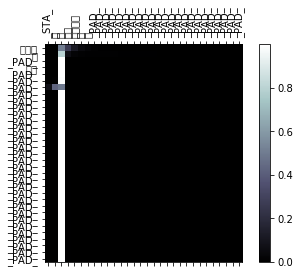

1576 Source :  심술 _EOS_
1576 Truth :  _STA_ And Then I ' m Your Girlfriend
1576 Prediction :  사랑해 의 취한
1576 BLEU Score :  0


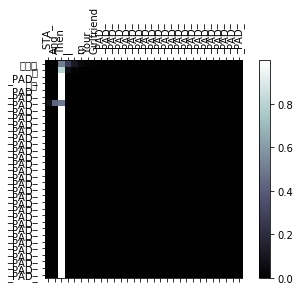

1584 Source :  좋 다고 말해 _EOS_
1584 Truth :  _STA_ 한번 쯤 은 꼭 소리쳐 세상 을
1584 Prediction :  _STA_ 목 목 던
1584 BLEU Score :  0


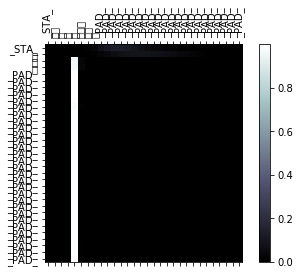

1592 Source :  좋 다고 말해 _EOS_
1592 Truth :  _STA_ 눈물 나도 감추지 말고
1592 Prediction :  _STA_ 목 목 던
1592 BLEU Score :  0


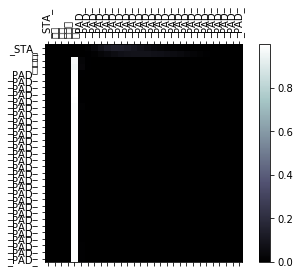

1600 Source :  좋 다고 말해 _EOS_
1600 Truth :  _STA_ 하늘 을 날 아 봐 어때 새롭 게
1600 Prediction :  _STA_ 목 목 던
1600 BLEU Score :  0


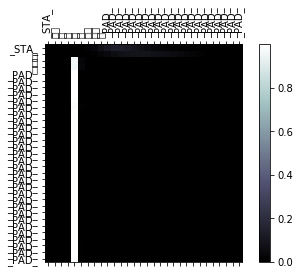

1608 Source :  좋 다고 말해 _EOS_
1608 Truth :  _STA_ 그토록 바라던 꿈 이 갑자기
1608 Prediction :  _STA_ 목 목 던
1608 BLEU Score :  0


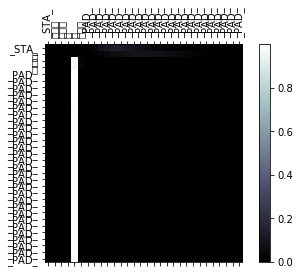

1616 Source :  한번 쯤 은 _EOS_
1616 Truth :  _STA_ 답답하고 지루해 질 땐 그럴 땐 떠나는 거야
1616 Prediction :  _STA_ 나 이 듣고
1616 BLEU Score :  0


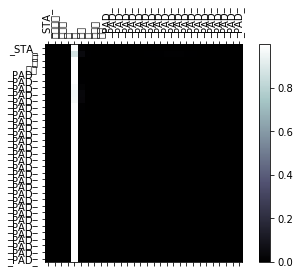

1624 Source :  라디오 를 크게 켜고 _EOS_
1624 Truth :  _STA_ I ’ m missing you I ’ m missing you
1624 Prediction :  _STA_ 술잔 왜 술잔 술잔 술잔
1624 BLEU Score :  0


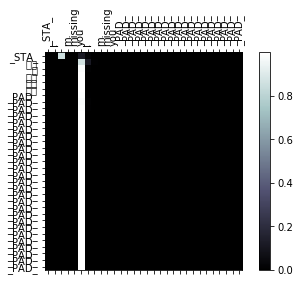

1632 Source :  라디오 를 크게 켜고 _EOS_
1632 Truth :  _STA_ 난 죽어 도 못 살 아 without you
1632 Prediction :  _STA_ 술잔 왜 술잔 술잔 술잔
1632 BLEU Score :  0


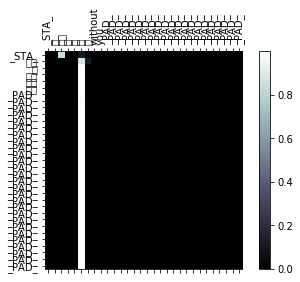

1640 Source :  라디오 를 크게 켜고 _EOS_
1640 Truth :  _STA_ 사랑 에 미쳤 었 던 그 시절 로
1640 Prediction :  _STA_ 술잔 왜 술잔 술잔 술잔
1640 BLEU Score :  0


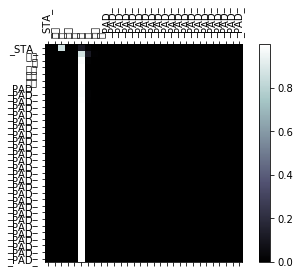

1648 Source :  라디오 를 크게 켜고 _EOS_
1648 Truth :  _STA_ 난 너 없이 못 살 아 without you
1648 Prediction :  _STA_ 술잔 왜 술잔 술잔 술잔
1648 BLEU Score :  0


KeyboardInterrupt: 

In [202]:
for num, source in enumerate(vali_var):
    if num % 8 ==0:
        input_ = source
        truth_ = decode_vail[num]
        truth = Variable(LongTensor(truth_))
        input_embedding = emb(truth).cuda()
        output, hidden, _ = encoder(input_embedding)
        pred,attn = decoder.decode(hidden,output)
        input_ = [index2word[i] for i in input_.data.tolist()]
        pred = [index2word[i] for i in pred.data.tolist()]

        print(str(num)+' Source : ',' '.join([index2word[i] for i in truth_ if index2word[i] not in ['_PAD_']]))
        print(str(num)+' Truth : ',' '.join(i for i in input_ if i not in ["_PAD_"]))
        print(str(num)+' Prediction : ',' '.join([i for i in pred if i not in ['_PAD_']]))
        truths = []
        for i in truth_:
            if index2word[i] not in ["_PAD_"]:
                truths.append(index2word[i])
        print(str(num)+' BLEU Score : ',str(nltk.translate.bleu_score.corpus_bleu([[pred]], [truths])))
        if USE_CUDA:
            attn = attn.cpu()

        show_attention(input_,pred,attn.data)

In [ ]:
for num, source in enumerate(vali_var):
    if num % 8 ==0:
        input_ = source
        truth = decode_vail[num]
        input_embedding = emb(input_).cuda()
        output, hidden = encoder(input_embedding)
        pred,attn = decoder.decode(hidden,output)
        input_ = [index2word[i] for i in input_.data.tolist()]
        pred = [index2word[i] for i in pred.data.tolist()]

        print(str(num)+' Source : ',' '.join([i for i in input_ if i not in ['_PAD_']]))
        print(str(num)+' Truth : ',' '.join(index2word[i] for i in truth if index2word[i] not in ["_PAD_"]))
        print(str(num)+' Prediction : ',' '.join([i for i in pred if i not in ['_PAD_']]))
        truths = []
        for i in truth:
            if index2word[i] not in ["_PAD_"]:
                truths.append(index2word[i])
        print(str(num)+' BLEU Score : ',str(nltk.translate.bleu_score.corpus_bleu([[pred]], [truths])))
        if USE_CUDA:
            attn = attn.cpu()

        show_attention(input_,pred,attn.data)